In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install split-folders pytorch-lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.5 MB/s eta 0:00:00


In [3]:
import os
import random
import copy
from typing import List, Dict, Union, cast
import math
import warnings
from uuid import uuid4
import time


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
from functools import reduce
import cv2
import splitfolders

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import seaborn as sns


# import data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.neighbors import NearestNeighbors

import torch
from torch import nn, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

import torchvision
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [4]:
torch.cuda.empty_cache()

warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')




ALL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/all"
TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/train"
VAL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/val"
MORE_TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/more_train"

FLOWERS_102_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/flowers102"
FLOWERS_KAGGLE_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/flowers_kaggle"

MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"
EMBEDDING_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/embeddings"

SEARCH_NUM_IMAGES = 10

SEED = 42

LEARNING_RATE = 1e-3

ENCODE_DIM = 1000

BATCH_SIZE = 32

In [5]:
print(torch.cuda.is_available())

True


# EDA

### The number of images

In [6]:
def get_images_by_class(dir_path: str):
    images = {}

    for class_name in os.listdir(dir_path):
        images[class_name] = os.listdir(f"{dir_path}/{class_name}")

    return images

In [7]:
def plot_num_per_class(images: dict):
    ans_dict = {
        "name": [],
        "num_images": []
    }

    for k, v in images.items():
        ans_dict["name"].append(k)
        ans_dict["num_images"].append(len(v))

    df = pd.DataFrame.from_dict(ans_dict)
    sns.barplot(df, x="name", y="num_images")
    plt.xticks(rotation=90)
    return df

In [8]:
all_images_by_class = get_images_by_class(ALL_DIR)
plot_num_per_class(all_images_by_class)

name  num_images
0     Hydrangeas         518
1           Babi         931
2      Calimerio         353
3  Chrysanthemum         696
4       Pingpong         360
5     Lisianthus         969
6           Rosy         171
7           Tana         623

In [9]:
def get_images_df(dir_path: str):
    images = []
    for class_name in os.listdir(dir_path):
        images += [(image_name[:-4], class_name, dir_path) for image_name in os.listdir(f"{dir_path}/{class_name}")]

    return pd.DataFrame(images, columns=["image_id", "class", "dir_path"])

In [10]:
all_images_df = get_images_df(ALL_DIR)
print(len(all_images_df))
all_images_df.head()

4621


image_id       class  \
0  hydrangeas_140  Hydrangeas   
1  hydrangeas_121  Hydrangeas   
2  hydrangeas_132  Hydrangeas   
3  hydrangeas_133  Hydrangeas   
4  hydrangeas_134  Hydrangeas   

                                            dir_path  
0  /content/drive/MyDrive/RMIT/machine-learning/m...  
1  /content/drive/MyDrive/RMIT/machine-learning/m...  
2  /content/drive/MyDrive/RMIT/machine-learning/m...  
3  /content/drive/MyDrive/RMIT/machine-learning/m...  
4  /content/drive/MyDrive/RMIT/machine-learning/m...

In [11]:
def plot_random_images(images_df, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    image_idxs = np.random.randint(len(images_df), size=rows * cols)
    
    for idx, image_idx in enumerate(image_idxs):
        image_record = images_df.iloc[image_idx]
        image_path = f"{image_record['dir_path']}/{image_record['class']}/{image_record['image_id']}.jpg"
        image = Image.open(image_path)
        row, col = idx // cols, idx % cols
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

In [12]:
# plot_random_images(all_images_df)

### Image brightness

In [13]:
# def get_image_brightness(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     return np.array(gray).mean()

# def add_brightness(df: pd.DataFrame, dir_path: str):
#     brightness = []
#     for _, row in df.iterrows():
#         img_id = row["image_id"]
#         img_class = row["class"]
#         image_path = f"{dir_path}/{img_class}/{img_id}.jpg"
#         image = cv2.imread(image_path)
#         brightness.append(get_image_brightness(image))

#     brightness_df = pd.DataFrame(brightness, columns=["brightness"])
#     df = pd.concat([df, brightness_df], axis=1)
#     return df

In [14]:
# all_images_df = add_brightness(all_images_df, ALL_DIR)
# all_images_df.head()

In [15]:
# # Plot the image bright distribution
# sns.histplot(all_images_df, x='brightness')

In [16]:
# # Plot the darkest images
# dark_images_df = all_images_df[all_images_df['brightness'] < 70]
# plot_random_images(dark_images_df)

In [17]:
# # Plot the brightest images
# bright_images_df = all_images_df[all_images_df['brightness'] > 200]
# plot_random_images(bright_images_df)

### Image Size

In [18]:
def add_image_size(df: pd.DataFrame):
    width_list, height_list, area_list = [], [], []

    for _, row in df.iterrows():
        img_id = row["image_id"]
        img_class = row["class"]
        dir_path = row["dir_path"]
        image_path = f"{dir_path}/{img_class}/{img_id}.jpg"
        image = cv2.imread(image_path)
        width_list.append(image.shape[1])
        height_list.append(image.shape[0])
        area_list.append(width_list[-1] * height_list[-1])

    size_df = pd.DataFrame({
        "width": width_list,
        "height": height_list,
        "area": area_list
    })
    df = pd.concat([df, size_df], axis=1)
    return df

In [19]:
# all_images_df = add_image_size(all_images_df)
# all_images_df.head()

In [20]:
# all_images_df.sort_values(by="area", ascending=True)

In [21]:
# small_images_df = all_images_df[all_images_df["area"] < 50000]
# plot_random_images(small_images_df)

In [22]:
# large_images_df = all_images_df[all_images_df["area"] > 2.5e6]
# plot_random_images(large_images_df)

## Data 



### Split train and validation set

In [23]:
# splitfolders.ratio(ALL_DIR, output=DATA_DIR,
#     seed=SEED, ratio=(.8, .2), group_prefix=None, move=False)

### Task 1 Dataset

In [24]:
# define transform
# train_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=350),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=256, width=256),
# #         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         # A.RandomBrightnessContrast(p=0.5),
#         # A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# #         A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#         ToTensorV2(),
#     ]
# )

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
#         A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)



val_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
#         A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [25]:
class_2_index = {}
index_2_class = {}

cnt = 0

for class_name in all_images_df["class"].unique():
    class_2_index[class_name] = cnt
    index_2_class[cnt] = class_name
    cnt += 1
    
def class_to_index(class_name: str):
    return class_2_index[class_name]

def index_to_class(index):
    return index_to_class[index]

In [26]:
class ClassificationDataset(Dataset):
    def __init__(self, dir_path, transforms=None):
        self.dir_path, self.transforms = dir_path, transforms
        self.images_df = get_images_df(self.dir_path)
        
    def __len__(self):
        # return len(self.images_df[:256])
        return len(self.images_df)

    
    def __getitem__(self, index):
        row = self.images_df.iloc[index]
        image_class, image_id = row['class'], row["image_id"]
        image_path = f"{self.dir_path}/{image_class}/{image_id}.jpg"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = class_to_index(image_class)
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        
        return image, label

In [27]:
class ImageSimilarityDataset(Dataset):
    pass

In [28]:
train_classification_dataset = ClassificationDataset(TRAIN_DIR, train_transforms)
val_classification_dataset = ClassificationDataset(VAL_DIR, val_transforms)

In [29]:
def plot_random_images_dataset(dataset, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([
        t for t in dataset.transforms if not isinstance(t, (A.Normalize, ToTensorV2))
    ])
    image_idxs = np.random.randint(len(dataset), size=rows * cols)

    
    for idx, image_idx in enumerate(image_idxs):
        image = dataset[image_idx][0]
        row, col = idx // cols, idx % cols
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

In [30]:
# plot_random_images_dataset(train_classification_dataset)

In [31]:
train_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

val_classification_dataloader = DataLoader(
    val_classification_dataset, batch_size=BATCH_SIZE,
    pin_memory=True, num_workers=4
)

In [32]:
print(len(train_classification_dataloader))

115


### Task 2 Dataset

In [33]:
more_train_dataset = ClassificationDataset(MORE_TRAIN_DIR, train_transforms)

more_train_dataloader = DataLoader(
    more_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

more_train_embedding_dataloader = DataLoader(
    more_train_dataset, batch_size=BATCH_SIZE, drop_last=True,
    pin_memory=True, num_workers=4
)

more_train_encoder_dataloader = DataLoader(
    more_train_dataset, batch_size=BATCH_SIZE // 2, drop_last=True,
    pin_memory=True, num_workers=4
)

val_encoder_dataloader = DataLoader(
    more_train_dataset, batch_size=BATCH_SIZE // 2, shuffle=True,
    pin_memory=True, num_workers=4
)


val_dataset = ClassificationDataset(VAL_DIR, val_transforms)

val_dataloader = DataLoader(
    more_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    pin_memory=True, num_workers=4
)

In [34]:
more_train_images_df = get_images_df(MORE_TRAIN_DIR)

In [35]:
def get_image_path(images_df, idx=0):
    row = images_df.iloc[idx]
    return f'{row["dir_path"]}/{row["class"]}/{row["image_id"]}.jpg'

## Train base model

In [36]:
def train_model(model, 
                save_dir,
                name,
                num_epochs=50,
                lr=LEARNING_RATE,
                scheduler=True,
                optimizer='sgd',
                train_dataloader=train_classification_dataloader, 
                val_dataloader=val_classification_dataloader):
    torch.cuda.empty_cache()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    print(f"Device: {device}\n")

    best_loss = 1e9

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    if optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr=lr/10, 
                                                  max_lr=lr)


    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        print(f"Start training epoch {epoch + 1}")
        running_loss = 0.0
        correct, total = 0, 0

        for i, data in enumerate(train_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if scheduler:
              scheduler.step()
            running_loss += loss.item()

            

        train_losses.append(running_loss / total)
        train_accuracies.append(correct / total)

        print(f"Epoch {epoch + 1} train loss: {train_losses[-1]}")
        print(f"Epoch {epoch + 1} train accuracy: {train_accuracies[-1]}")


        with torch.no_grad():
            correct, total = 0, 0
            val_loss = 0.0

            for data in val_dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_losses.append(val_loss / total)
            val_accuracies.append(correct / total)

            print(f"Epoch {epoch + 1} val loss: {val_losses[-1]}")
            print(f"Epoch {epoch + 1} val accuracy: {val_accuracies[-1]} \n")

            if val_accuracies[-1] > best_val_accuracy:
                train_accuracy, val_accuracy = train_accuracies[-1], val_accuracies[-1]
                model_path = f"{save_dir}/{name}_train_{str(train_accuracy * 1000)[:3]}_val_{str(val_accuracy * 1000)[:3]}.pth"
                torch.save(model.state_dict(), model_path)
                best_val_accuracy = val_accuracy

    fig, axes = plt.subplots(ncols=2, figsize=(15, 7))

    axes[0].plot(train_accuracies, label='train_acc')
    axes[0].plot(val_accuracies,label='val_acc')
    axes[0].set_title("Train and val accuracy")
    axes[0].legend()
    
    axes[1].plot(train_losses, label='train_loss')
    axes[1].plot(val_losses,label='val_loss')
    axes[1].set_title("Train and val loss")
    axes[1].legend()

    return model, criterion, optimizer

In [37]:
more_train_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, train_transforms)

more_train_classification_dataloader = DataLoader(
    more_train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [38]:
# Define a new dataset with new transform for augmentation 
more_train_hard_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)



more_train_hard_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_hard_transforms)

more_train_hard_classification_dataloader = DataLoader(
    more_train_hard_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [39]:
# Define a new dataset with new transform for augmentation 
more_train_strong_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=8, g_shift_limit=8, b_shift_limit=8, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.7,2.2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.15, sat_shift_limit=0.4, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3), contrast_limit=(-0.3, 0.3), p=0.5),
        ToTensorV2(),
    ]
)

more_train_strong_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_strong_transforms)

more_train_strong_classification_dataloader = DataLoader(
    more_train_strong_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [40]:
more_train_weather_transformers = A.Compose(
    [
        A.OneOf([
            A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1),
            A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
            A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
            A.RandomFog(fog_coef_lower=0.4, fog_coef_upper=0.6, alpha_coef=0.1, p=1)
        ], p=1),
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=16, g_shift_limit=16, b_shift_limit=16, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[1,2.5], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.5, val_shift_limit=0.3, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.45,0.45), contrast_limit=(-0.45, 0.45), p=0.5),
        ToTensorV2(),
    ]
)

more_train_weather_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_weather_transformers)

more_train_weather_classification_dataloader = DataLoader(
    more_train_weather_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)



In [41]:
class Flowers102Dataset(Dataset):
    def __init__(self, dir_path, transforms=None):
        self.dir_path, self.transforms = dir_path, transforms
        self.images_df = get_images_df(self.dir_path)
        
    def __len__(self):
        return len(self.images_df)
    
    def __getitem__(self, index):
        row = self.images_df.iloc[index]
        image_class, image_id = row['class'], row["image_id"]
        image_path = f"{self.dir_path}/{image_class}/{image_id}.jpg"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = int(image_class) - 1
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        
        return image, label


In [42]:
# flowers102_train_dataset = Flowers102Dataset(dir_path=f"{FLOWERS_102_DIR}/train", transforms=train_transforms)
# flowers102_train_dataloader = DataLoader(
#     flowers102_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
#     pin_memory=True, num_workers=4
# )

# flowers102_train_hard_dataset = Flowers102Dataset(dir_path=f"{FLOWERS_102_DIR}/train", transforms=more_train_hard_transforms)
# flowers102_train_hard_dataloader = DataLoader(
#     flowers102_train_hard_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
#     pin_memory=True, num_workers=4
# )

# flowers102_val_dataset = Flowers102Dataset(dir_path=f"{FLOWERS_102_DIR}/val", transforms=val_transforms)
# flowers102_val_dataloader = DataLoader(
#     flowers102_val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
#     pin_memory=True, num_workers=4
# )

### AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, (11, 11), (4, 4), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(64, 192, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(192, 384, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(384, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06492856306874234
Epoch 1 train accuracy: 0.1595108695652174
Epoch 1 val loss: 0.06565996522986732
Epoch 1 val accuracy: 0.16921397379912664 

Start training epoch 2
Epoch 2 train loss: 0.06468659969775573
Epoch 2 train accuracy: 0.20244565217391305
Epoch 2 val loss: 0.06535816244683411
Epoch 2 val accuracy: 0.21506550218340612 

Start training epoch 3
Epoch 3 train loss: 0.06436332438303077
Epoch 3 train accuracy: 0.1983695652173913
Epoch 3 val loss: 0.06496891522511644
Epoch 3 val accuracy: 0.20851528384279475 

Start training epoch 4
Epoch 4 train loss: 0.06385917028655176
Epoch 4 train accuracy: 0.20978260869565218
Epoch 4 val loss: 0.06425625098844803
Epoch 4 val accuracy: 0.21179039301310043 

Start training epoch 5
Epoch 5 train loss: 0.06283353716135025
Epoch 5 train accuracy: 0.20978260869565218
Epoch 5 val loss: 0.06264598791255702
Epoch 5 val accuracy: 0.21179039301310043 

Start training epoch 6
Epoch 6 train loss

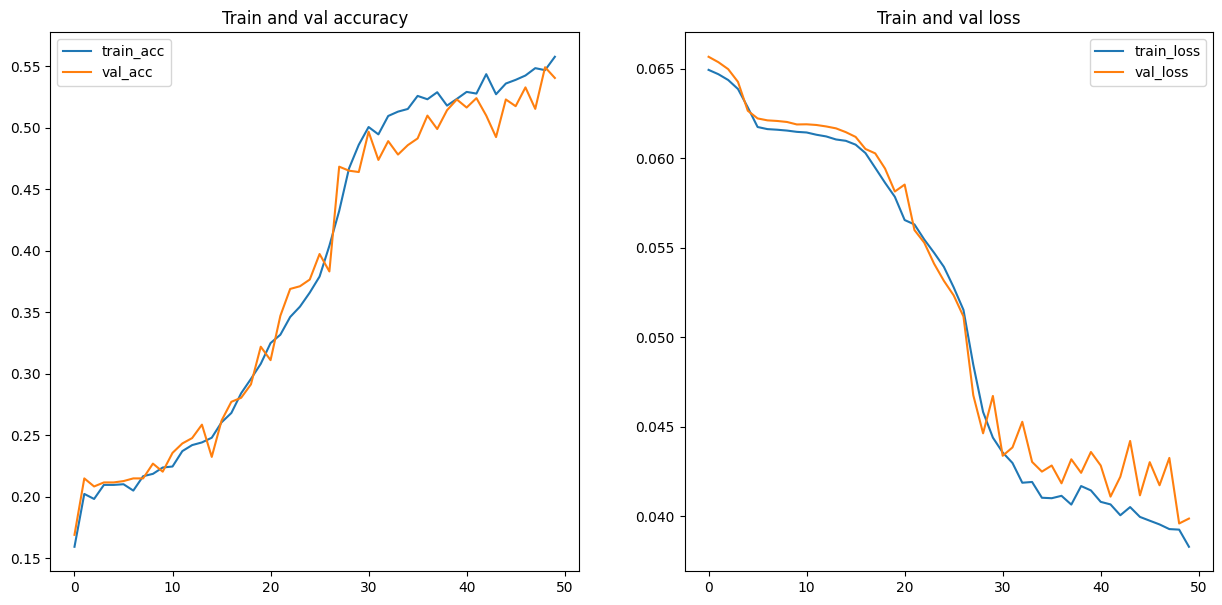

In [ ]:
alexnet_model = AlexNet(num_classes=8)
alexnet_trained_model, _, _ = train_model(alexnet_model)

In [ ]:
# Continue train the current model more 100 epoch 
alexnet_trained_model, _, _ = train_model(alexnet_trained_model, num_epochs=100)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03658660838137502
Epoch 1 train accuracy: 0.5796195652173913
Epoch 1 val loss: 0.03852815044368719
Epoch 1 val accuracy: 0.5524017467248908 

Start training epoch 2
Epoch 2 train loss: 0.036511250747286755
Epoch 2 train accuracy: 0.5836956521739131
Epoch 2 val loss: 0.03951817432084979
Epoch 2 val accuracy: 0.5567685589519651 

Start training epoch 3
Epoch 3 train loss: 0.0366656773602185
Epoch 3 train accuracy: 0.5760869565217391
Epoch 3 val loss: 0.038084769125328315
Epoch 3 val accuracy: 0.5731441048034934 

Start training epoch 4
Epoch 4 train loss: 0.036376570829230806
Epoch 4 train accuracy: 0.5834239130434783
Epoch 4 val loss: 0.038668622941950004
Epoch 4 val accuracy: 0.5545851528384279 

Start training epoch 5
Epoch 5 train loss: 0.0366543467440035
Epoch 5 train accuracy: 0.5766304347826087
Epoch 5 val loss: 0.03920204280245252
Epoch 5 val accuracy: 0.5633187772925764 

Start training epoch 6
Epoch 6 train loss: 0.03

### VGG

In [ ]:
__all__ = [
    "VGG",
    "vgg11", "vgg13", "vgg16", "vgg19",
    "vgg11_bn", "vgg13_bn", "vgg16_bn", "vgg19_bn",
]

vgg_cfgs: Dict[str, List[Union[str, int]]] = {
    "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "vgg19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


def _make_layers(vgg_cfg: List[Union[str, int]], batch_norm: bool = False, dropout_rate=0.0) -> nn.Sequential:
    layers: nn.Sequential[nn.Module] = nn.Sequential()
    in_channels = 3
    for v in vgg_cfg:
        if v == "M":
            layers.append(nn.MaxPool2d((2, 2), (2, 2)))
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, (3, 3), (1, 1), (1, 1))
            if batch_norm:
                layers.append(conv2d)
                layers.append(nn.BatchNorm2d(v))
                layers.append(nn.ReLU(True))
            else:
                layers.append(conv2d)
                layers.append(nn.ReLU(True))
            in_channels = v
            if dropout_rate > 0:
                layers.append(nn.Dropout2d(dropout_rate))

    return layers


class VGG(nn.Module):
    def __init__(self, vgg_cfg: List[Union[str, int]], batch_norm: bool = False, num_classes: int = 1000, dropout_rate=0.0) -> None:
        super(VGG, self).__init__()
        self.features = _make_layers(vgg_cfg, batch_norm, dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        # Initialize neural network weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)


def VGG11(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], False, **kwargs)

    return model


def VGG13(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], False, **kwargs)

    return model


def VGG16(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], False, **kwargs)

    return model


def VGG19(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], False, **kwargs)

    return model


def VGG11_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], True, **kwargs)

    return model


def VGG13_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], True, **kwargs)

    return model


def VGG16_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], True, **kwargs)

    return model


def VGG19_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], True, **kwargs)

    return model

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.05211609568730427
Epoch 1 train accuracy: 0.37426181102362205
Epoch 1 val loss: 0.06352717269976586
Epoch 1 val accuracy: 0.27729257641921395 

Start training epoch 2
Epoch 2 train loss: 0.052128893819459156
Epoch 2 train accuracy: 0.3781988188976378
Epoch 2 val loss: 0.06399329924166984
Epoch 2 val accuracy: 0.2740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.05212839978338853
Epoch 3 train accuracy: 0.3759022309711286
Epoch 3 val loss: 0.06203936072936745
Epoch 3 val accuracy: 0.287117903930131 

Start training epoch 4
Epoch 4 train loss: 0.05186438809816293
Epoch 4 train accuracy: 0.37286745406824146
Epoch 4 val loss: 0.06349211749031033
Epoch 4 val accuracy: 0.2718340611353712 

Start training epoch 5
Epoch 5 train loss: 0.051595911100076566
Epoch 5 train accuracy: 0.380987532808399
Epoch 5 val loss: 0.06352667230706027
Epoch 5 val accuracy: 0.27729257641921395 

Start training epoch 6
Epoch 6 train loss: 0.

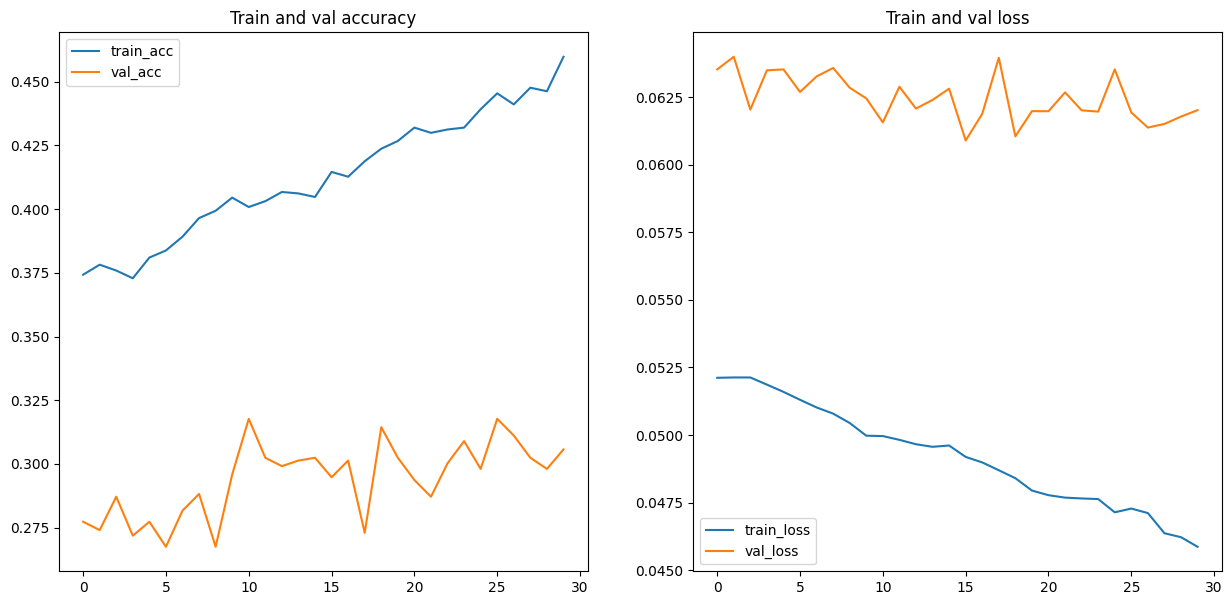

In [ ]:
vgg_model = VGG11_bn(num_classes=8, dropout_rate=0.2)
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=30, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.045773050936031845
Epoch 1 train accuracy: 0.45570866141732286
Epoch 1 val loss: 0.06045313888762195
Epoch 1 val accuracy: 0.32096069868995636 

Start training epoch 2
Epoch 2 train loss: 0.04544467804586794
Epoch 2 train accuracy: 0.45898950131233596
Epoch 2 val loss: 0.06206915719540359
Epoch 2 val accuracy: 0.3296943231441048 

Start training epoch 3
Epoch 3 train loss: 0.045161824028088354
Epoch 3 train accuracy: 0.4654691601049869
Epoch 3 val loss: 0.061478241302040465
Epoch 3 val accuracy: 0.3056768558951965 

Start training epoch 4
Epoch 4 train loss: 0.04533404620300754
Epoch 4 train accuracy: 0.46227034120734906
Epoch 4 val loss: 0.062159523823375785
Epoch 4 val accuracy: 0.324235807860262 

Start training epoch 5
Epoch 5 train loss: 0.0449961206320859
Epoch 5 train accuracy: 0.46776574803149606
Epoch 5 val loss: 0.06187278800135616
Epoch 5 val accuracy: 0.3002183406113537 

Start training epoch 6
Epoch 6 train loss:

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03928487410578202
Epoch 1 train accuracy: 0.5354330708661418
Epoch 1 val loss: 0.06058248773412413
Epoch 1 val accuracy: 0.3558951965065502 

Start training epoch 2
Epoch 2 train loss: 0.039341434631056674
Epoch 2 train accuracy: 0.5328083989501312
Epoch 2 val loss: 0.06029432972966323
Epoch 2 val accuracy: 0.3384279475982533 

Start training epoch 3
Epoch 3 train loss: 0.03908371814866391
Epoch 3 train accuracy: 0.5353510498687664
Epoch 3 val loss: 0.059896147407298525
Epoch 3 val accuracy: 0.3460698689956332 

Start training epoch 4
Epoch 4 train loss: 0.039023395749957855
Epoch 4 train accuracy: 0.5391240157480315
Epoch 4 val loss: 0.05897354845396816
Epoch 4 val accuracy: 0.36572052401746724 

Start training epoch 5
Epoch 5 train loss: 0.039242756912323436
Epoch 5 train accuracy: 0.5382217847769029
Epoch 5 val loss: 0.06249910241651743
Epoch 5 val accuracy: 0.32751091703056767 

Start training epoch 6
Epoch 6 train loss: 

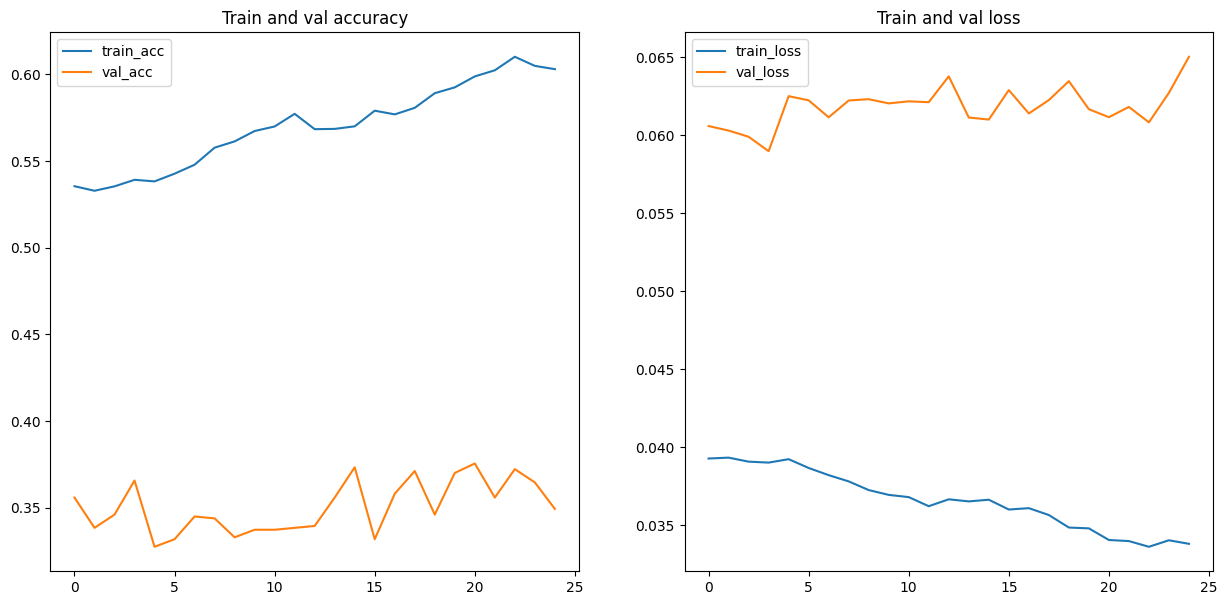

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                             dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE * 3 / 5,
                                      train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02289475845246334
Epoch 1 train accuracy: 0.7500820209973753
Epoch 1 val loss: 0.04291839887872013
Epoch 1 val accuracy: 0.5862445414847162 

Start training epoch 2
Epoch 2 train loss: 0.020254544199999235
Epoch 2 train accuracy: 0.7738681102362205
Epoch 2 val loss: 0.045519386706914446
Epoch 2 val accuracy: 0.5644104803493449 

Start training epoch 3
Epoch 3 train loss: 0.018379194107092427
Epoch 3 train accuracy: 0.791994750656168
Epoch 3 val loss: 0.04529013051997106
Epoch 3 val accuracy: 0.5884279475982532 

Start training epoch 4
Epoch 4 train loss: 0.016174420298827603
Epoch 4 train accuracy: 0.8216863517060368
Epoch 4 val loss: 0.04891825047642904
Epoch 4 val accuracy: 0.5829694323144105 

Start training epoch 5
Epoch 5 train loss: 0.014225198760178928
Epoch 5 train accuracy: 0.8421916010498688
Epoch 5 val loss: 0.05188987339037474
Epoch 5 val accuracy: 0.5884279475982532 

Start training epoch 6
Epoch 6 train loss: 0.

In [ ]:
more_train_hard_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

more_train_hard_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_hard_transforms)

more_train_hard_classification_dataloader = DataLoader(
    more_train_hard_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.05652961407707432
Epoch 1 train accuracy: 0.32209645669291337
Epoch 1 val loss: 0.04152567723692765
Epoch 1 val accuracy: 0.5305676855895196 

Start training epoch 2
Epoch 2 train loss: 0.05308277501169778
Epoch 2 train accuracy: 0.3609744094488189
Epoch 2 val loss: 0.04222599016787183
Epoch 2 val accuracy: 0.50764192139738 

Start training epoch 3
Epoch 3 train loss: 0.051874294525056375
Epoch 3 train accuracy: 0.3735236220472441
Epoch 3 val loss: 0.040666176177008184
Epoch 3 val accuracy: 0.5513100436681223 

Start training epoch 4
Epoch 4 train loss: 0.05049992111215754
Epoch 4 train accuracy: 0.39066601049868765
Epoch 4 val loss: 0.03930056967068968
Epoch 4 val accuracy: 0.5807860262008734 

Start training epoch 5
Epoch 5 train loss: 0.050306231995892965
Epoch 5 train accuracy: 0.39058398950131235
Epoch 5 val loss: 0.03889003298428381
Epoch 5 val accuracy: 0.584061135371179 

Start training epoch 6
Epoch 6 train loss: 0.0

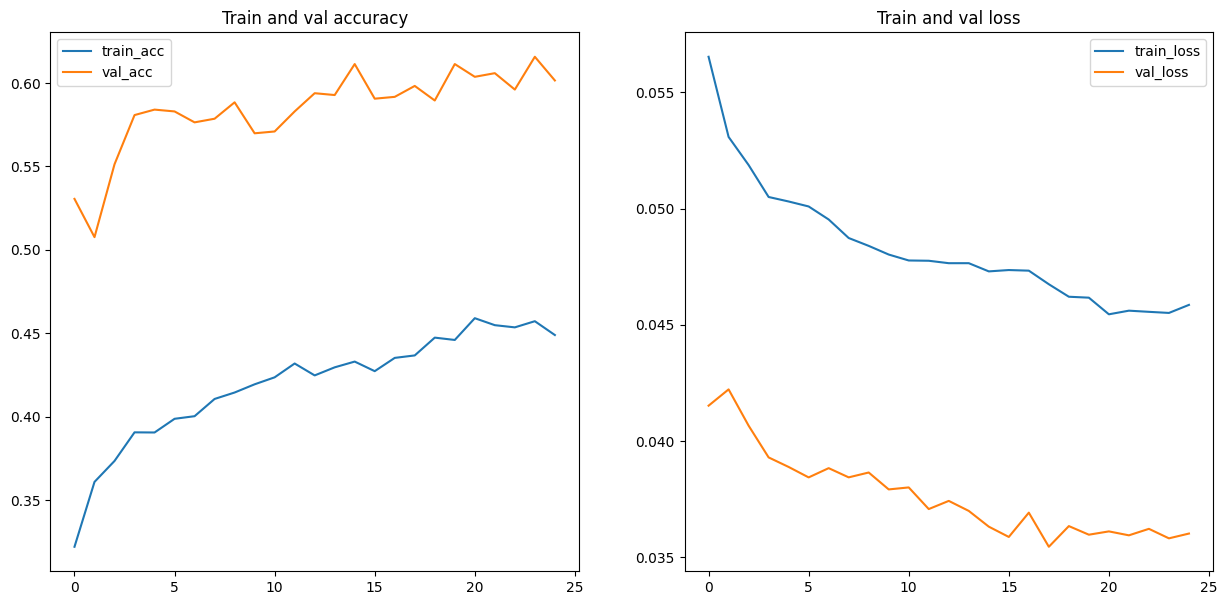

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.04483170365900036
Epoch 1 train accuracy: 0.4612040682414698
Epoch 1 val loss: 0.03434372651004375
Epoch 1 val accuracy: 0.6244541484716157 

Start training epoch 2
Epoch 2 train loss: 0.04496491898897439
Epoch 2 train accuracy: 0.4567749343832021
Epoch 2 val loss: 0.036226282278523175
Epoch 2 val accuracy: 0.6058951965065502 

Start training epoch 3
Epoch 3 train loss: 0.04512284667258031
Epoch 3 train accuracy: 0.4625984251968504
Epoch 3 val loss: 0.035910202361090215
Epoch 3 val accuracy: 0.5949781659388647 

Start training epoch 4
Epoch 4 train loss: 0.044832784276739195
Epoch 4 train accuracy: 0.46243438320209973
Epoch 4 val loss: 0.03513860663472305
Epoch 4 val accuracy: 0.6080786026200873 

Start training epoch 5
Epoch 5 train loss: 0.04500360632427721
Epoch 5 train accuracy: 0.46104002624671914
Epoch 5 val loss: 0.03601285307688484
Epoch 5 val accuracy: 0.618995633187773 

Start training epoch 6
Epoch 6 train loss: 0.

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.038642428463368905
Epoch 1 train accuracy: 0.5435531496062992
Epoch 1 val loss: 0.032227522421091406
Epoch 1 val accuracy: 0.665938864628821 

Start training epoch 2
Epoch 2 train loss: 0.03849811241852017
Epoch 2 train accuracy: 0.5473261154855643
Epoch 2 val loss: 0.031848887884460685
Epoch 2 val accuracy: 0.665938864628821 

Start training epoch 3
Epoch 3 train loss: 0.038895654602078944
Epoch 3 train accuracy: 0.5344488188976378
Epoch 3 val loss: 0.0344604335107137
Epoch 3 val accuracy: 0.6266375545851528 

Start training epoch 4
Epoch 4 train loss: 0.03915150234294845
Epoch 4 train accuracy: 0.5372375328083989
Epoch 4 val loss: 0.0343638621433333
Epoch 4 val accuracy: 0.6233624454148472 

Start training epoch 5
Epoch 5 train loss: 0.038774344522574444
Epoch 5 train accuracy: 0.5350229658792651
Epoch 5 val loss: 0.033869504147741994
Epoch 5 val accuracy: 0.6408296943231441 

Start training epoch 6
Epoch 6 train loss: 0.03

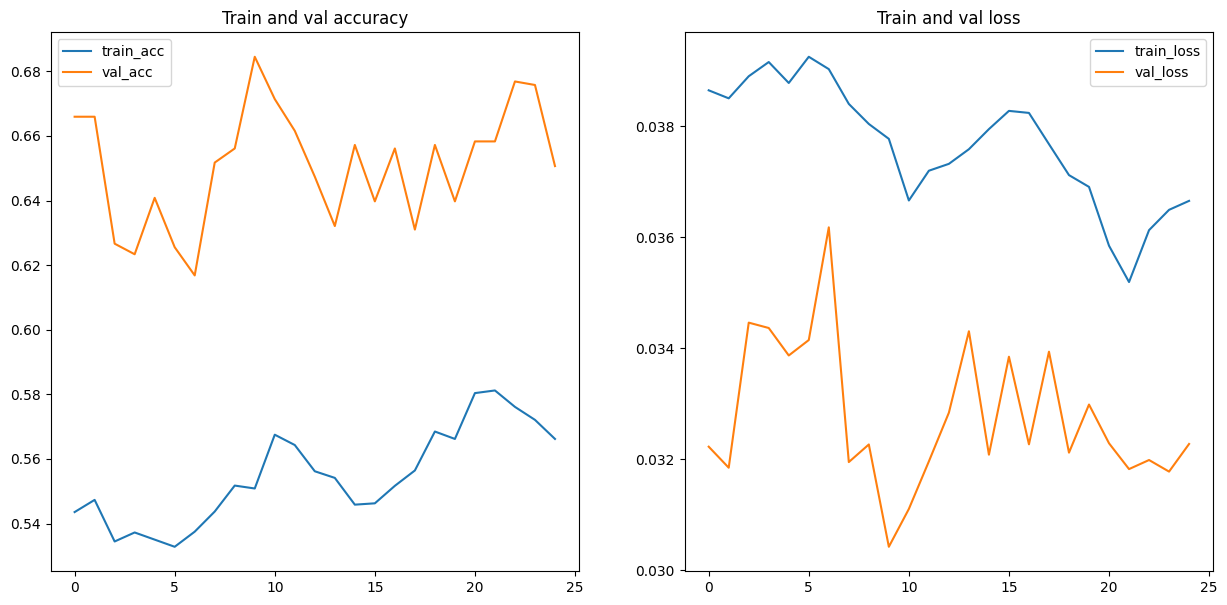

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.035054150910124066
Epoch 1 train accuracy: 0.5910433070866141
Epoch 1 val loss: 0.03137704053299916
Epoch 1 val accuracy: 0.6844978165938864 

Start training epoch 2
Epoch 2 train loss: 0.034987805244999295
Epoch 2 train accuracy: 0.5906332020997376
Epoch 2 val loss: 0.03167936905372611
Epoch 2 val accuracy: 0.6626637554585153 

Start training epoch 3
Epoch 3 train loss: 0.03503277218287072
Epoch 3 train accuracy: 0.5884186351706037
Epoch 3 val loss: 0.03124410772948286
Epoch 3 val accuracy: 0.6834061135371179 

Start training epoch 4
Epoch 4 train loss: 0.03499694979136071
Epoch 4 train accuracy: 0.5838254593175853
Epoch 4 val loss: 0.0317219280715072
Epoch 4 val accuracy: 0.6713973799126638 

Start training epoch 5
Epoch 5 train loss: 0.03499978961144376
Epoch 5 train accuracy: 0.5862040682414699
Epoch 5 val loss: 0.03254138671805244
Epoch 5 val accuracy: 0.6593886462882096 

Start training epoch 6
Epoch 6 train loss: 0.034

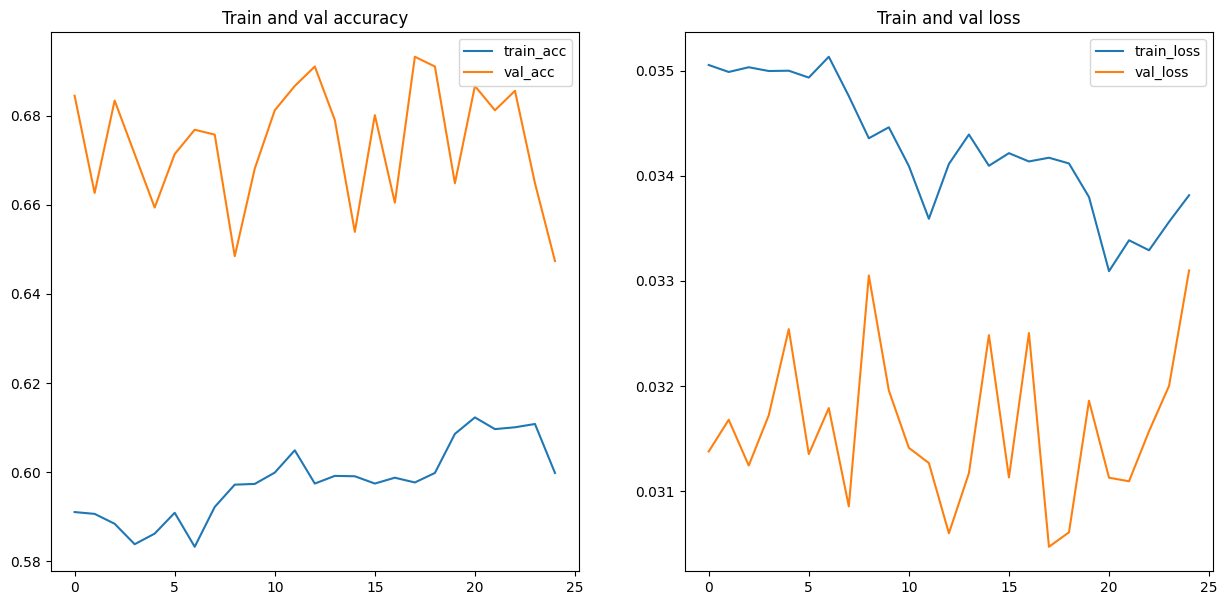

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 5,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03462012514980446
Epoch 1 train accuracy: 0.5948162729658792
Epoch 1 val loss: 0.0313321051704311
Epoch 1 val accuracy: 0.6746724890829694 

Start training epoch 2
Epoch 2 train loss: 0.03440783812794003
Epoch 2 train accuracy: 0.599245406824147
Epoch 2 val loss: 0.03179938229020506
Epoch 2 val accuracy: 0.6582969432314411 

Start training epoch 3
Epoch 3 train loss: 0.0346706248819828
Epoch 3 train accuracy: 0.598999343832021
Epoch 3 val loss: 0.03170356635964073
Epoch 3 val accuracy: 0.6713973799126638 

Start training epoch 4
Epoch 4 train loss: 0.03420701889893201
Epoch 4 train accuracy: 0.6017060367454068
Epoch 4 val loss: 0.03199993897083024
Epoch 4 val accuracy: 0.6692139737991266 

Start training epoch 5
Epoch 5 train loss: 0.0346893234584197
Epoch 5 train accuracy: 0.5883366141732284
Epoch 5 val loss: 0.03175007252583858
Epoch 5 val accuracy: 0.6768558951965066 

Start training epoch 6
Epoch 6 train loss: 0.034218684

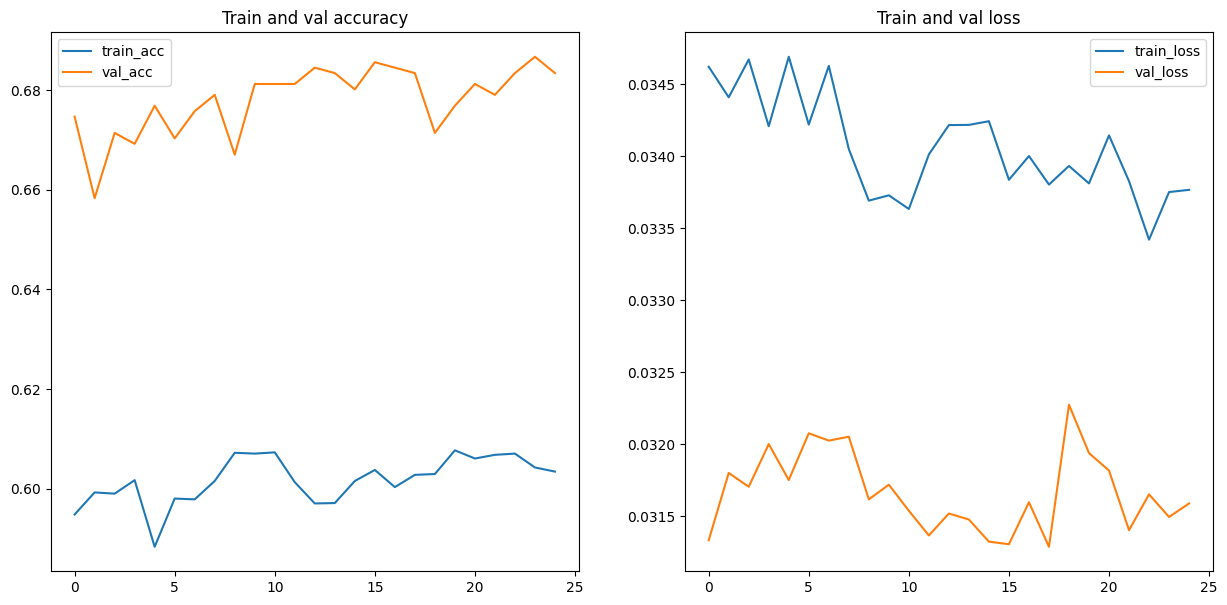

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 20,
                                      train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard_603%.pth")

### ResNet

In [ ]:
dropout_rate = 0.4

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x = self.dropout(x)
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout2d(dropout_rate)


    def forward(self, x):
        identity = x.clone()
        
        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))
        
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
            
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.dropout(x)
        x = self.relu(x)
        return x


        
        
class ResNet(nn.Module):
    
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

def ResNet18(num_classes, channels=3):
    return ResNet(Bottleneck, [2,2,2,2], num_classes, channels)
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

### MobilenetV2

In [ ]:
class MobilenetV2(nn.Module):
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def __init__(self):
        super().__init__()
        self.mobilenet_v2 = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
        self.mobilenet_v2.classifier[1] = torch.nn.Linear(in_features=self.mobilenet_v2.classifier[1].in_features, out_features=10)
        self.init_weights(self.mobilenet_v2)

    def forward(self, x):
        out = self.mobilenet_v2(x)
        return out

In [ ]:
torch.cuda.empty_cache()

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06687908719374439
Epoch 1 train accuracy: 0.13828740157480315
Epoch 1 val loss: 0.06652031546076312
Epoch 1 val accuracy: 0.1277292576419214 

Start training epoch 2
Epoch 2 train loss: 0.06466810723028471
Epoch 2 train accuracy: 0.15666010498687663
Epoch 2 val loss: 0.06608613896057595
Epoch 2 val accuracy: 0.1299126637554585 

Start training epoch 3
Epoch 3 train loss: 0.06364949252896422
Epoch 3 train accuracy: 0.1755249343832021
Epoch 3 val loss: 0.06697994496624543
Epoch 3 val accuracy: 0.1648471615720524 

Start training epoch 4
Epoch 4 train loss: 0.06105978526859459
Epoch 4 train accuracy: 0.2246555118110236
Epoch 4 val loss: 0.07034786780848774
Epoch 4 val accuracy: 0.15065502183406113 

Start training epoch 5
Epoch 5 train loss: 0.056660643360746187
Epoch 5 train accuracy: 0.2828904199475066
Epoch 5 val loss: 0.07330382520975505
Epoch 5 val accuracy: 0.18449781659388648 

Start training epoch 6
Epoch 6 train loss: 0

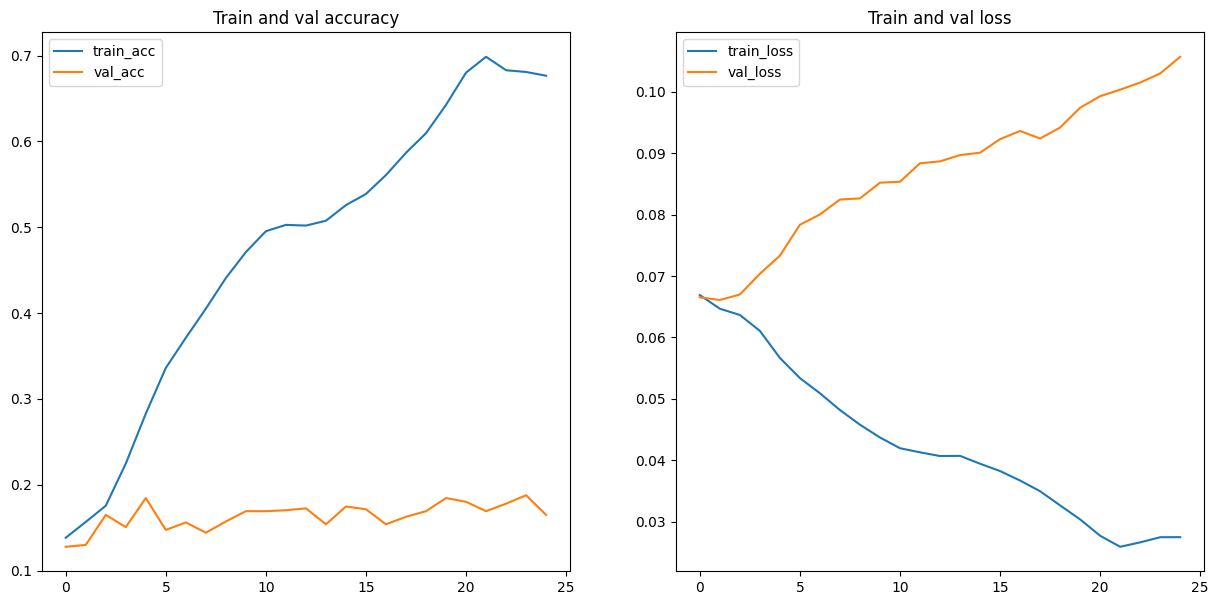

In [ ]:
mobilenet_v2_model = MobilenetV2()
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE,
                                               train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0235872189819891
Epoch 1 train accuracy: 0.7298228346456693
Epoch 1 val loss: 0.1033150715078329
Epoch 1 val accuracy: 0.1615720524017467 

Start training epoch 2
Epoch 2 train loss: 0.02189737747318241
Epoch 2 train accuracy: 0.7538549868766404
Epoch 2 val loss: 0.103806006596078
Epoch 2 val accuracy: 0.17576419213973798 

Start training epoch 3
Epoch 3 train loss: 0.020374709720725775
Epoch 3 train accuracy: 0.7751804461942258
Epoch 3 val loss: 0.10454787281402854
Epoch 3 val accuracy: 0.17139737991266377 

Start training epoch 4
Epoch 4 train loss: 0.019590271834841393
Epoch 4 train accuracy: 0.7798556430446194
Epoch 4 val loss: 0.10564513888421538
Epoch 4 val accuracy: 0.17139737991266377 

Start training epoch 5
Epoch 5 train loss: 0.018841124635942653
Epoch 5 train accuracy: 0.7931430446194225
Epoch 5 val loss: 0.10758178801515737
Epoch 5 val accuracy: 0.17139737991266377 

Start training epoch 6
Epoch 6 train loss: 0.0

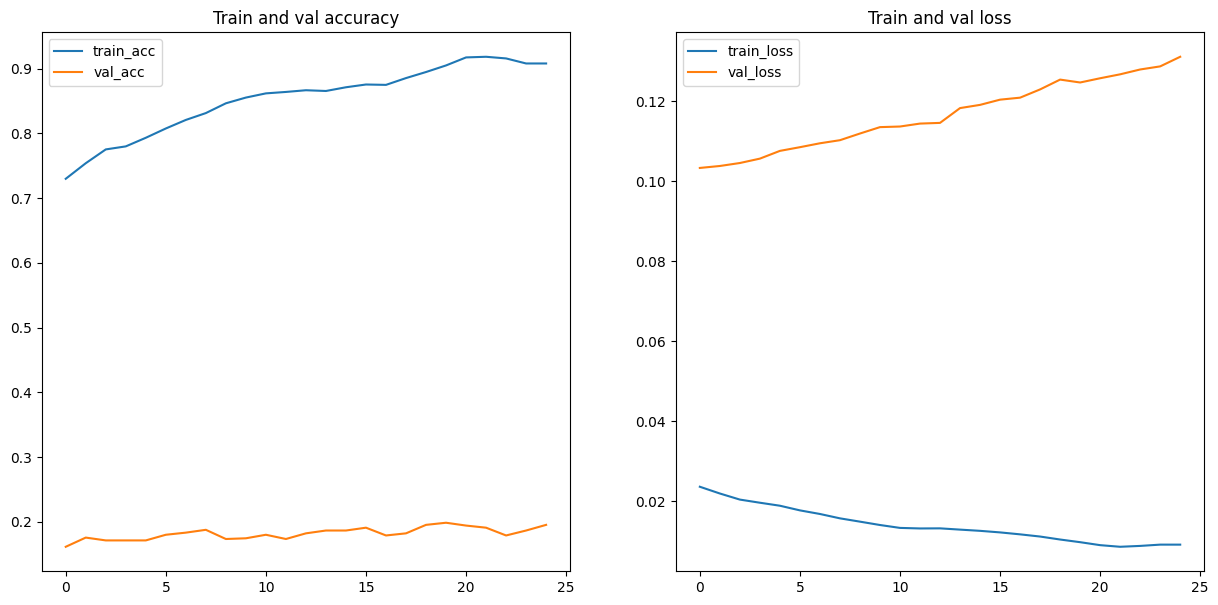

In [ ]:
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_trained_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE / 5,
                                               train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(mobilenet_v2_trained_model.state_dict(), f"{MODEL_DIR}/mobilenet/mobilenet_195.pth")

In [ ]:
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_trained_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE / 10,
                                               train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.007971873184851814
Epoch 1 train accuracy: 0.9233103674540682
Epoch 1 val loss: 0.1304507700636918
Epoch 1 val accuracy: 0.18777292576419213 

Start training epoch 2
Epoch 2 train loss: 0.007866181904667612
Epoch 2 train accuracy: 0.9245406824146981
Epoch 2 val loss: 0.13138004005215573
Epoch 2 val accuracy: 0.18340611353711792 

Start training epoch 3
Epoch 3 train loss: 0.0074974820005592555
Epoch 3 train accuracy: 0.9316765091863517
Epoch 3 val loss: 0.13161493518987596
Epoch 3 val accuracy: 0.17903930131004367 

Start training epoch 4
Epoch 4 train loss: 0.00710146828662125
Epoch 4 train accuracy: 0.9325787401574803
Epoch 4 val loss: 0.13136825837422667
Epoch 4 val accuracy: 0.1965065502183406 

Start training epoch 5
Epoch 5 train loss: 0.007360770092089111
Epoch 5 train accuracy: 0.9299540682414699
Epoch 5 val loss: 0.13276545527720557
Epoch 5 val accuracy: 0.18777292576419213 

Start training epoch 6
Epoch 6 train loss

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(mobilenet_v2_trained_model.state_dict(), f"{MODEL_DIR}/mobilenet/mobilenet_train_953.pth")

In [ ]:
mobilenet_v2_model = MobilenetV2()
mobilenet_v2_model.load_state_dict(torch.load(f"{MODEL_DIR}/mobilenet/mobilenet_train_953.pth"))
mobilenet_v2_model.eval()

mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model, 
                                               num_epochs=10, 
                                               lr=LEARNING_RATE / 10,
                                               optimizer='adamw',
                                               train_dataloader=more_train_classification_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.005561495800514821
Epoch 1 train accuracy: 0.9398786089238845
Epoch 1 val loss: 0.05998311699347725
Epoch 1 val accuracy: 0.6004366812227074 

Start training epoch 2
Epoch 2 train loss: 0.0056548668849639465
Epoch 2 train accuracy: 0.9378280839895013
Epoch 2 val loss: 0.06774334876297863
Epoch 2 val accuracy: 0.5796943231441049 

Start training epoch 3
Epoch 3 train loss: 0.007906496621823559
Epoch 3 train accuracy: 0.9128937007874016
Epoch 3 val loss: 0.06377029269282995
Epoch 3 val accuracy: 0.5545851528384279 

Start training epoch 4
Epoch 4 train loss: 0.007991423462352562
Epoch 4 train accuracy: 0.9096128608923885
Epoch 4 val loss: 0.06239598657626773
Epoch 4 val accuracy: 0.5895196506550219 

Start training epoch 5
Epoch 5 train loss: 0.010680771071654488
Epoch 5 train accuracy: 0.8786089238845144
Epoch 5 val loss: 0.058407546618880146
Epoch 5 val accuracy: 0.5917030567685589 

Start training epoch 6
Epoch 6 train loss:

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(mobilenet_v2_trained_model.state_dict(), f"{MODEL_DIR}/mobilenet/mobilenet_train_905_val_609.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06103553700204596
Epoch 1 train accuracy: 0.27698490813648297
Epoch 1 val loss: 0.04512869794426006
Epoch 1 val accuracy: 0.43122270742358076 

Start training epoch 2
Epoch 2 train loss: 0.05614555374843868
Epoch 2 train accuracy: 0.3048720472440945
Epoch 2 val loss: 0.04751590896381561
Epoch 2 val accuracy: 0.4410480349344978 

Start training epoch 3
Epoch 3 train loss: 0.05487363377776672
Epoch 3 train accuracy: 0.327755905511811
Epoch 3 val loss: 0.04164689896408647
Epoch 3 val accuracy: 0.5382096069868996 

Start training epoch 4
Epoch 4 train loss: 0.053775231532380965
Epoch 4 train accuracy: 0.3410433070866142
Epoch 4 val loss: 0.046142938485832716
Epoch 4 val accuracy: 0.48799126637554585 

Start training epoch 5
Epoch 5 train loss: 0.053616708472097326
Epoch 5 train accuracy: 0.34375
Epoch 5 val loss: 0.04141061821358693
Epoch 5 val accuracy: 0.5633187772925764 

Start training epoch 6
Epoch 6 train loss: 0.0520860937

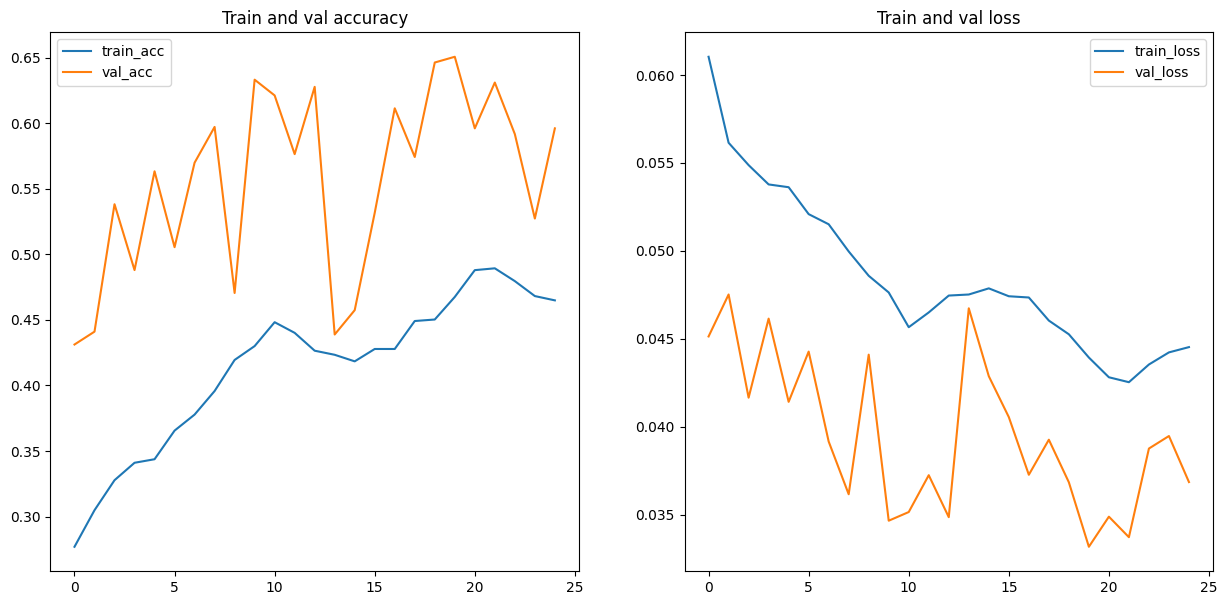

In [ ]:
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_trained_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE,
                                               optimizer='adamw',
                                               train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
torch.save(mobilenet_v2_trained_model.state_dict(), f"{MODEL_DIR}/mobilenet/mobilenet_hard_train_464_val_596.pth")

In [ ]:
mobilenet_v2_model = MobilenetV2()
mobilenet_v2_model.load_state_dict(torch.load(f"{MODEL_DIR}/mobilenet/mobilenet_hard_train_464_val_596.pth"))
mobilenet_v2_model.eval()

mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model, 
                                               num_epochs=10, 
                                               lr=LEARNING_RATE / 5,
                                               optimizer='sgd',
                                               train_dataloader=more_train_hard_classification_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.041817525773262726
Epoch 1 train accuracy: 0.5009022309711286
Epoch 1 val loss: 0.03341477315498752
Epoch 1 val accuracy: 0.6517467248908297 

Start training epoch 2
Epoch 2 train loss: 0.04118573712062804
Epoch 2 train accuracy: 0.5092683727034121
Epoch 2 val loss: 0.03378364762624799
Epoch 2 val accuracy: 0.6550218340611353 

Start training epoch 3
Epoch 3 train loss: 0.04086335511325695
Epoch 3 train accuracy: 0.5163221784776902
Epoch 3 val loss: 0.03416745403708329
Epoch 3 val accuracy: 0.6277292576419214 

Start training epoch 4
Epoch 4 train loss: 0.0403846993093963
Epoch 4 train accuracy: 0.5123031496062992
Epoch 4 val loss: 0.032803892829012145
Epoch 4 val accuracy: 0.6593886462882096 

Start training epoch 5
Epoch 5 train loss: 0.040720030626286985
Epoch 5 train accuracy: 0.5123851706036745
Epoch 5 val loss: 0.03372397036271324
Epoch 5 val accuracy: 0.62117903930131 

Start training epoch 6
Epoch 6 train loss: 0.0407

In [ ]:
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_trained_model, 
                                               save_dir=f"{MODEL_DIR}/mobilenet",
                                               name="mobilenet",
                                               num_epochs=10, 
                                               lr=LEARNING_RATE / 5,
                                               optimizer='sgd',
                                               train_dataloader=more_train_hard_classification_dataloader)


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0394019832262608
Epoch 1 train accuracy: 0.5343667979002624
Epoch 1 val loss: 0.03421842733064593
Epoch 1 val accuracy: 0.6255458515283843 

Start training epoch 2
Epoch 2 train loss: 0.03980773621852317
Epoch 2 train accuracy: 0.5286253280839895
Epoch 2 val loss: 0.032419095653633885
Epoch 2 val accuracy: 0.6604803493449781 

Start training epoch 3
Epoch 3 train loss: 0.039935549100240074
Epoch 3 train accuracy: 0.5236220472440944
Epoch 3 val loss: 0.035098819493206306
Epoch 3 val accuracy: 0.5829694323144105 

Start training epoch 4
Epoch 4 train loss: 0.04006875170458333
Epoch 4 train accuracy: 0.5173884514435696
Epoch 4 val loss: 0.03290885956917267
Epoch 4 val accuracy: 0.638646288209607 

Start training epoch 5
Epoch 5 train loss: 0.04026509267021352
Epoch 5 train accuracy: 0.5220636482939632
Epoch 5 val loss: 0.03243830071266041
Epoch 5 val accuracy: 0.6539301310043668 

Start training epoch 6
Epoch 6 train loss: 0.039

### EfficientNetV2

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                nn.SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=1000, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()


def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model,
                                       save_dir=f"{MODEL_DIR}/effnetv2",
                                       name="effnetv2_m",
                                       lr=LEARNING_RATE,
                                       optimizer='adamw',
                                       train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06465701891837783
Epoch 1 train accuracy: 0.15083661417322836
Epoch 1 val loss: 0.06691429942976439
Epoch 1 val accuracy: 0.12554585152838427 

Start training epoch 2
Epoch 2 train loss: 0.06382688391083495
Epoch 2 train accuracy: 0.16978346456692914
Epoch 2 val loss: 0.06674362803650735
Epoch 2 val accuracy: 0.1462882096069869 

Start training epoch 3
Epoch 3 train loss: 0.06302300321422225
Epoch 3 train accuracy: 0.1845472440944882
Epoch 3 val loss: 0.06684836016471729
Epoch 3 val accuracy: 0.15283842794759825 

Start training epoch 4
Epoch 4 train loss: 0.062052621254379665
Epoch 4 train accuracy: 0.203248031496063
Epoch 4 val loss: 0.0679337364096829
Epoch 4 val accuracy: 0.14737991266375547 

Start training epoch 5
Epoch 5 train loss: 0.05797587202133469
Epoch 5 train accuracy: 0.2588582677165354
Epoch 5 val loss: 0.07289889819236822
Epoch 5 val accuracy: 0.17576419213973798 

Start training epoch 6
Epoch 6 train loss: 0

In [ ]:
torch.save(effnetv2_m_model.state_dict(), f"{MODEL_DIR}/effnetv2/effnetv2_m_train_899_177.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.05692889117036905
Epoch 1 train accuracy: 0.31167979002624674
Epoch 1 val loss: 0.04315341930982848
Epoch 1 val accuracy: 0.49563318777292575 

Start training epoch 2
Epoch 2 train loss: 0.052428366210595205
Epoch 2 train accuracy: 0.36491141732283466
Epoch 2 val loss: 0.04453975111896815
Epoch 2 val accuracy: 0.5262008733624454 

Start training epoch 3
Epoch 3 train loss: 0.05123999609252599
Epoch 3 train accuracy: 0.3805774278215223
Epoch 3 val loss: 0.04358184096854847
Epoch 3 val accuracy: 0.5065502183406113 

Start training epoch 4
Epoch 4 train loss: 0.05084096586571278
Epoch 4 train accuracy: 0.38795931758530183
Epoch 4 val loss: 0.038623036580835365
Epoch 4 val accuracy: 0.5895196506550219 

Start training epoch 5
Epoch 5 train loss: 0.049451920206308994
Epoch 5 train accuracy: 0.4063320209973753
Epoch 5 val loss: 0.038625018825697584
Epoch 5 val accuracy: 0.574235807860262 

Start training epoch 6
Epoch 6 train loss:

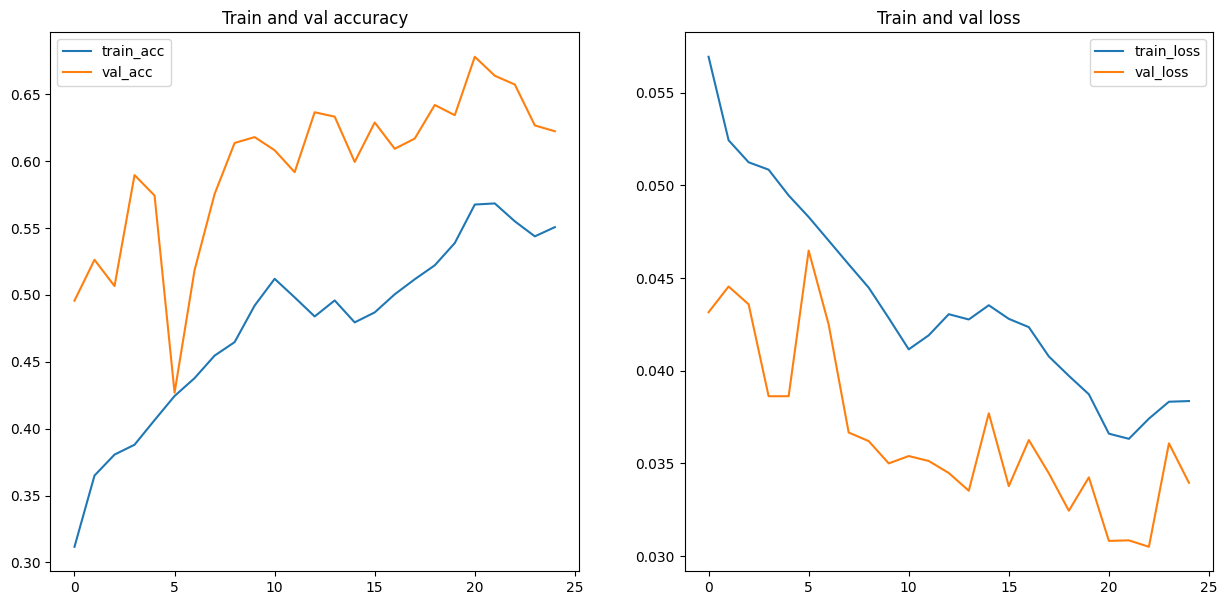

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_model.load_state_dict(torch.load(f"{MODEL_DIR}/effnetv2/effnetv2_m_train_899_177.pth"))
effnetv2_m_model.eval()

effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model,
                                       save_dir=f"{MODEL_DIR}/effnetv2",
                                       name="effnetv2_m",
                                       lr=LEARNING_RATE,
                                       optimizer='adamw',
                                       train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03473796959956643
Epoch 1 train accuracy: 0.5875984251968503
Epoch 1 val loss: 0.030927561613930364
Epoch 1 val accuracy: 0.6735807860262009 

Start training epoch 2
Epoch 2 train loss: 0.034677885453219176
Epoch 2 train accuracy: 0.5894028871391076
Epoch 2 val loss: 0.030484332235359207
Epoch 2 val accuracy: 0.6812227074235808 

Start training epoch 3
Epoch 3 train loss: 0.0348619658969284
Epoch 3 train accuracy: 0.5917814960629921
Epoch 3 val loss: 0.032352015701443866
Epoch 3 val accuracy: 0.6582969432314411 

Start training epoch 4
Epoch 4 train loss: 0.034848372869956214
Epoch 4 train accuracy: 0.5877624671916011
Epoch 4 val loss: 0.03170745120298394
Epoch 4 val accuracy: 0.6495633187772926 

Start training epoch 5
Epoch 5 train loss: 0.03455114834929702
Epoch 5 train accuracy: 0.5916174540682415
Epoch 5 val loss: 0.03086040523635248
Epoch 5 val accuracy: 0.6703056768558951 

Start training epoch 6
Epoch 6 train loss: 0.

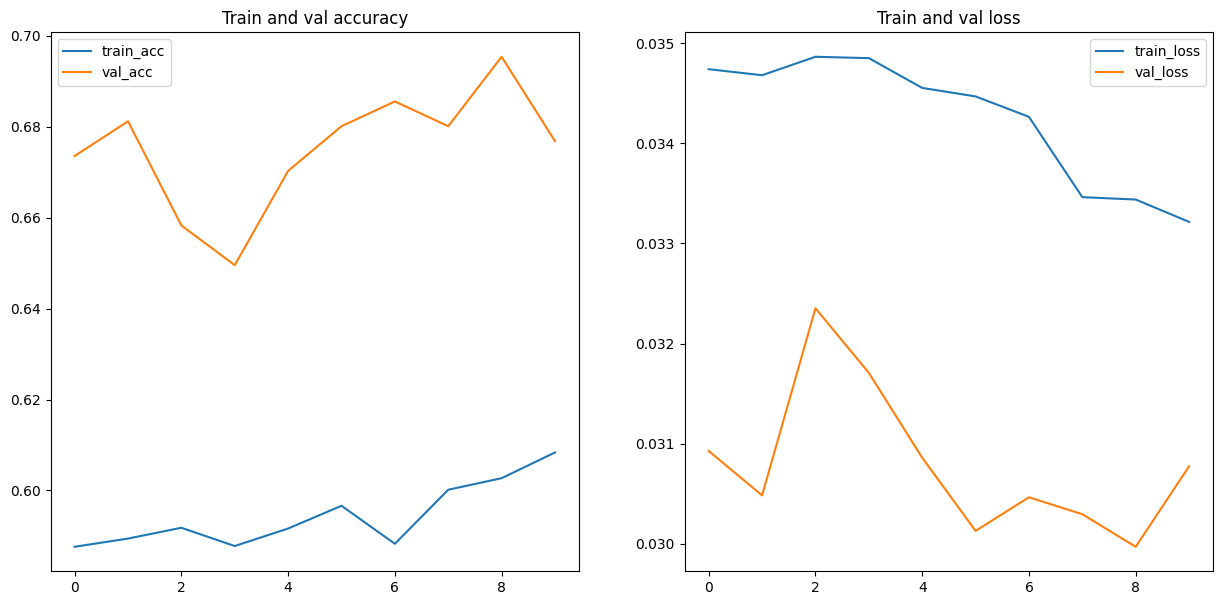

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_model.load_state_dict(torch.load(f"{MODEL_DIR}/effnetv2/effnetv2_m_train_56._val_67..pth"))
effnetv2_m_model.eval()

effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model,
                                       save_dir=f"{MODEL_DIR}/effnetv2",
                                       name="effnetv2_m",
                                       lr=LEARNING_RATE / 5,
                                       num_epochs=10,
                                       optimizer='sgd',
                                       train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.032649325074877326
Epoch 1 train accuracy: 0.6172900262467191
Epoch 1 val loss: 0.03012251121898926
Epoch 1 val accuracy: 0.6844978165938864 

Start training epoch 2
Epoch 2 train loss: 0.032314236625403246
Epoch 2 train accuracy: 0.6189304461942258
Epoch 2 val loss: 0.031048002396608543
Epoch 2 val accuracy: 0.6746724890829694 

Start training epoch 3
Epoch 3 train loss: 0.03225826592309269
Epoch 3 train accuracy: 0.6184383202099738
Epoch 3 val loss: 0.02978747578817684
Epoch 3 val accuracy: 0.6910480349344978 

Start training epoch 4
Epoch 4 train loss: 0.032328746816891386
Epoch 4 train accuracy: 0.6178641732283464
Epoch 4 val loss: 0.03008786826414833
Epoch 4 val accuracy: 0.6844978165938864 

Start training epoch 5
Epoch 5 train loss: 0.03241500693551824
Epoch 5 train accuracy: 0.6167979002624672
Epoch 5 val loss: 0.029882044088111695
Epoch 5 val accuracy: 0.6866812227074236 

Start training epoch 6
Epoch 6 train loss: 0

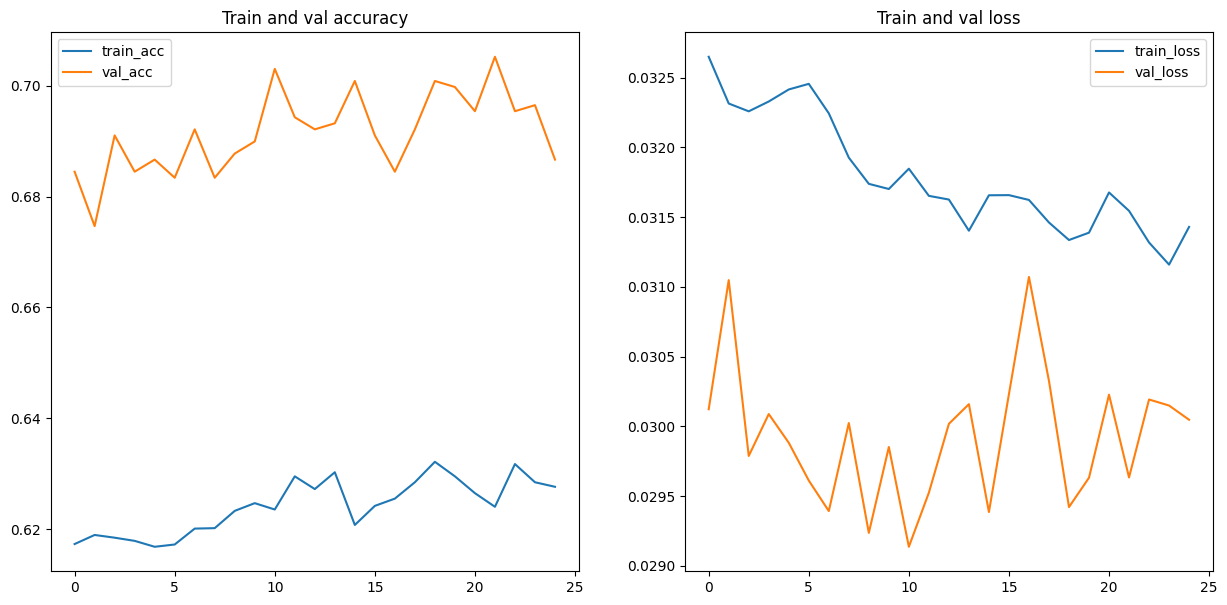

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_model.load_state_dict(torch.load(f"{MODEL_DIR}/effnetv2/effnetv2_m_train_602_val_695.pth"))
effnetv2_m_model.eval()

effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model,
                                       save_dir=f"{MODEL_DIR}/effnetv2",
                                       name="effnetv2_m",
                                       lr=LEARNING_RATE / 25,
                                       num_epochs=25,
                                       optimizer='sgd',
                                       train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_model.load_state_dict(torch.load(f"{MODEL_DIR}/effnetv2/effnetv2_m_train_624_val_705.pth"))
effnetv2_m_model.eval()

effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model,
                                       save_dir=f"{MODEL_DIR}/effnetv2",
                                       name="effnetv2_m",
                                       lr=LEARNING_RATE,
                                       num_epochs=20,
                                       optimizer='sgd',
                                       train_dataloader=more_train_weather_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03998827744578439
Epoch 1 train accuracy: 0.5243602362204725
Epoch 1 val loss: 0.036016743125873885
Epoch 1 val accuracy: 0.5862445414847162 

Start training epoch 2
Epoch 2 train loss: 0.04147073846026825
Epoch 2 train accuracy: 0.5074639107611548
Epoch 2 val loss: 0.03345617638925277
Epoch 2 val accuracy: 0.6179039301310044 

Start training epoch 3
Epoch 3 train loss: 0.041543337391821415
Epoch 3 train accuracy: 0.5058234908136483
Epoch 3 val loss: 0.03178106960901527
Epoch 3 val accuracy: 0.6473799126637555 

Start training epoch 4
Epoch 4 train loss: 0.04230894129772199
Epoch 4 train accuracy: 0.4970472440944882
Epoch 4 val loss: 0.03245627248911878
Epoch 4 val accuracy: 0.6473799126637555 

Start training epoch 5
Epoch 5 train loss: 0.04241579562288726
Epoch 5 train accuracy: 0.48876312335958005
Epoch 5 val loss: 0.03601633161957087
Epoch 5 val accuracy: 0.5633187772925764 

Start training epoch 6
Epoch 6 train loss: 0.0

KeyboardInterrupt: ignored

### DarkNet53

In [ ]:
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())


# Residual block
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out


class Darknet53(nn.Module):
    def __init__(self, block, num_classes):
        super(Darknet53, self).__init__()

        self.num_classes = num_classes

        self.conv1 = conv_batch(3, 32)
        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)

        return out

    def extract(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.global_avg_pool(out)
        return out 

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)


def darknet53(num_classes):
    return Darknet53(DarkResidualBlock, num_classes)

In [ ]:
torch.cuda.empty_cache()

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06439800866515305
Epoch 1 train accuracy: 0.18594160104986876
Epoch 1 val loss: 0.06971190590004733
Epoch 1 val accuracy: 0.1572052401746725 

Start training epoch 2
Epoch 2 train loss: 0.059757498452278575
Epoch 2 train accuracy: 0.2800196850393701
Epoch 2 val loss: 0.07247998698830084
Epoch 2 val accuracy: 0.18231441048034935 

Start training epoch 3
Epoch 3 train loss: 0.05614597245737949
Epoch 3 train accuracy: 0.33226706036745407
Epoch 3 val loss: 0.07616605092344325
Epoch 3 val accuracy: 0.2096069868995633 

Start training epoch 4
Epoch 4 train loss: 0.05163142442937911
Epoch 4 train accuracy: 0.3893536745406824
Epoch 4 val loss: 0.08042034623924822
Epoch 4 val accuracy: 0.1539301310043668 

Start training epoch 5
Epoch 5 train loss: 0.049115331061282186
Epoch 5 train accuracy: 0.4229002624671916
Epoch 5 val loss: 0.08067000107473682
Epoch 5 val accuracy: 0.18995633187772926 

Start training epoch 6
Epoch 6 train loss: 

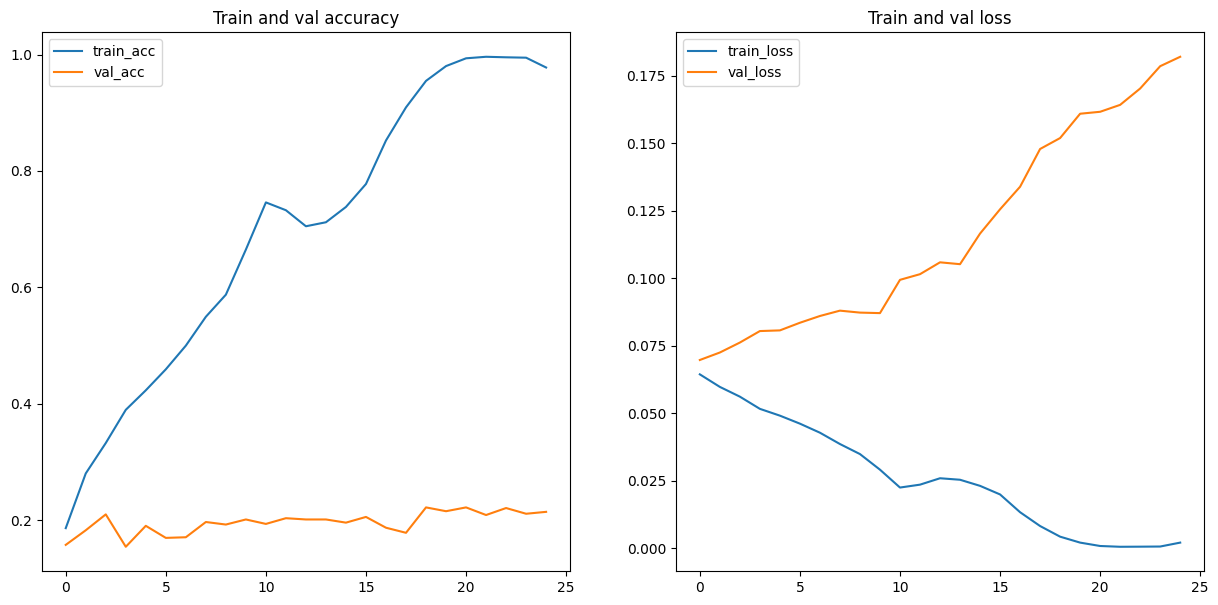

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            num_epochs=25,
                                            lr=LEARNING_RATE,
                                            train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_208.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06499509868307377
Epoch 1 train accuracy: 0.23531824146981628
Epoch 1 val loss: 0.04548153307240082
Epoch 1 val accuracy: 0.4148471615720524 

Start training epoch 2
Epoch 2 train loss: 0.05726539512749106
Epoch 2 train accuracy: 0.3052821522309711
Epoch 2 val loss: 0.04365846683885333
Epoch 2 val accuracy: 0.5010917030567685 

Start training epoch 3
Epoch 3 train loss: 0.0563032136462492
Epoch 3 train accuracy: 0.3092191601049869
Epoch 3 val loss: 0.040050836564672045
Epoch 3 val accuracy: 0.5775109170305677 

Start training epoch 4
Epoch 4 train loss: 0.05479292957762408
Epoch 4 train accuracy: 0.33111876640419946
Epoch 4 val loss: 0.0450312717122282
Epoch 4 val accuracy: 0.4781659388646288 

Start training epoch 5
Epoch 5 train loss: 0.05338202619294482
Epoch 5 train accuracy: 0.35211614173228345
Epoch 5 val loss: 0.04885750215126437
Epoch 5 val accuracy: 0.39192139737991266 

Start training epoch 6
Epoch 6 train loss: 0.0

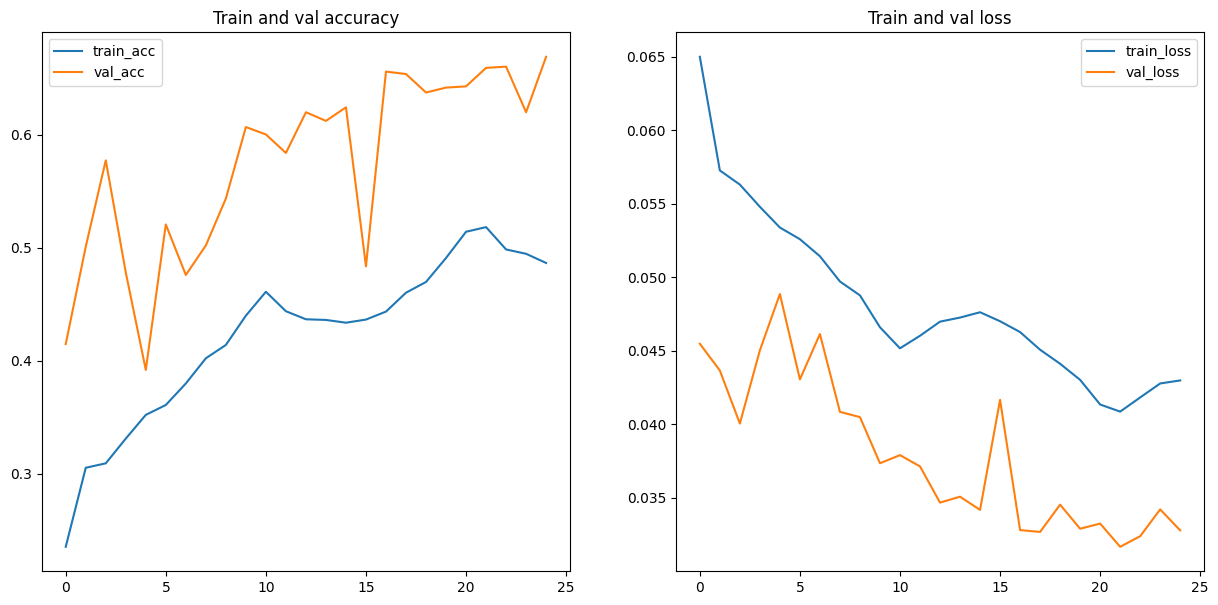

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_208.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE,
                                               train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_669.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.039189140696146985
Epoch 1 train accuracy: 0.5359251968503937
Epoch 1 val loss: 0.03184084867546132
Epoch 1 val accuracy: 0.6670305676855895 

Start training epoch 2
Epoch 2 train loss: 0.03862152584972657
Epoch 2 train accuracy: 0.5434711286089239
Epoch 2 val loss: 0.03253832765281461
Epoch 2 val accuracy: 0.6593886462882096 

Start training epoch 3
Epoch 3 train loss: 0.03822095974243376
Epoch 3 train accuracy: 0.543225065616798
Epoch 3 val loss: 0.03466250230131191
Epoch 3 val accuracy: 0.6277292576419214 

Start training epoch 4
Epoch 4 train loss: 0.038397775645174693
Epoch 4 train accuracy: 0.5455216535433071
Epoch 4 val loss: 0.03228615686362487
Epoch 4 val accuracy: 0.6604803493449781 

Start training epoch 5
Epoch 5 train loss: 0.03827487961865786
Epoch 5 train accuracy: 0.5501148293963255
Epoch 5 val loss: 0.03349441136985887
Epoch 5 val accuracy: 0.6528384279475983 

Start training epoch 6
Epoch 6 train loss: 0.037

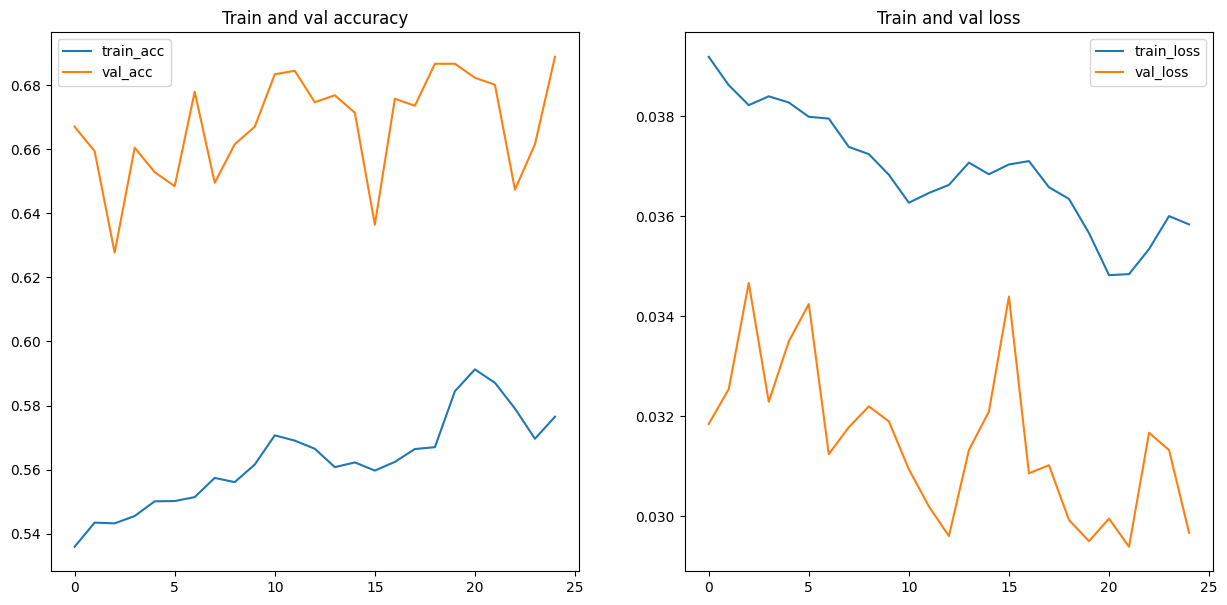

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=25, 
                                            lr=LEARNING_RATE / 5,
                                            train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_718.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03271281186813914
Epoch 1 train accuracy: 0.6112204724409449
Epoch 1 val loss: 0.028491222441977288
Epoch 1 val accuracy: 0.7117903930131004 

Start training epoch 2
Epoch 2 train loss: 0.03234260413903264
Epoch 2 train accuracy: 0.6206528871391076
Epoch 2 val loss: 0.028314640037878112
Epoch 2 val accuracy: 0.7106986899563319 

Start training epoch 3
Epoch 3 train loss: 0.03187088482570773
Epoch 3 train accuracy: 0.6284448818897638
Epoch 3 val loss: 0.028432873496582415
Epoch 3 val accuracy: 0.7096069868995634 

Start training epoch 4
Epoch 4 train loss: 0.03177825003627717
Epoch 4 train accuracy: 0.6273786089238845
Epoch 4 val loss: 0.028010209412293662
Epoch 4 val accuracy: 0.7139737991266376 

Start training epoch 5
Epoch 5 train loss: 0.031684676742577175
Epoch 5 train accuracy: 0.6255741469816273
Epoch 5 val loss: 0.02791868631756462
Epoch 5 val accuracy: 0.7150655021834061 

Start training epoch 6
Epoch 6 train loss: 0

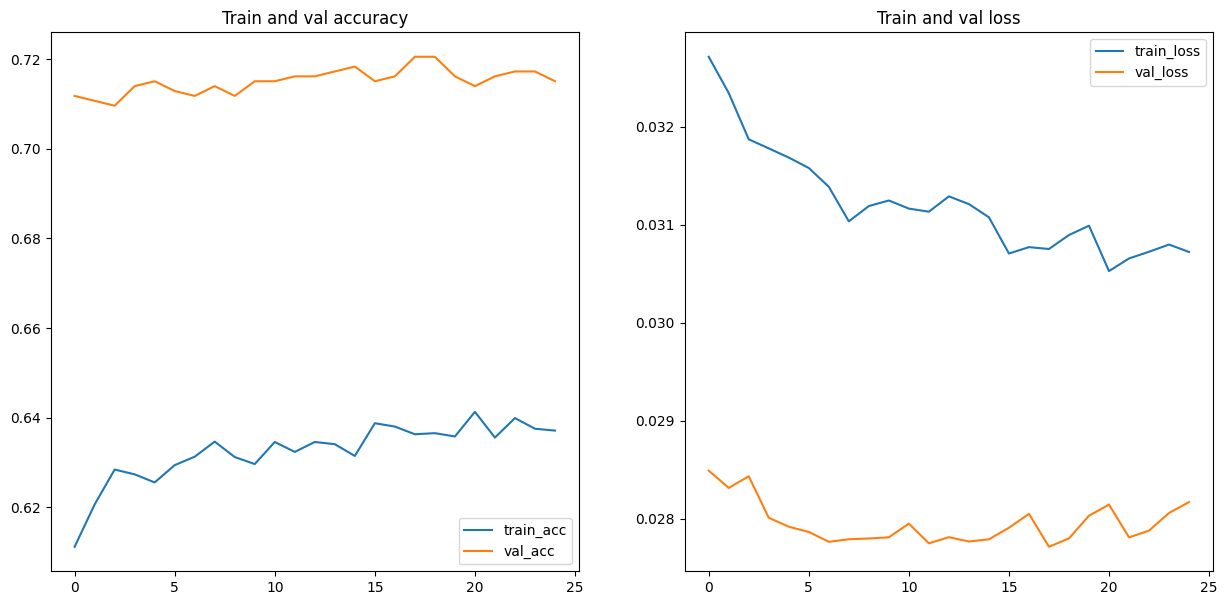

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_718.pth"))
darknet53_model.eval()

# SGD
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=25, 
                                            lr=LEARNING_RATE / 25,
                                            train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.020058464020578644
Epoch 1 train accuracy: 0.769274934383202
Epoch 1 val loss: 0.028421005827891255
Epoch 1 val accuracy: 0.7139737991266376 

Start training epoch 2
Epoch 2 train loss: 0.01894114535116148
Epoch 2 train accuracy: 0.7776410761154856
Epoch 2 val loss: 0.028271127313245333
Epoch 2 val accuracy: 0.7205240174672489 

Start training epoch 3
Epoch 3 train loss: 0.018067588138680056
Epoch 3 train accuracy: 0.7883858267716536
Epoch 3 val loss: 0.030601925432161472
Epoch 3 val accuracy: 0.7052401746724891 

Start training epoch 4
Epoch 4 train loss: 0.016713202236772678
Epoch 4 train accuracy: 0.8026574803149606
Epoch 4 val loss: 0.03431629415552689
Epoch 4 val accuracy: 0.6626637554585153 

Start training epoch 5
Epoch 5 train loss: 0.0156314901914692
Epoch 5 train accuracy: 0.8126640419947506
Epoch 5 val loss: 0.029520589809490603
Epoch 5 val accuracy: 0.7434497816593887 

Start training epoch 6
Epoch 6 train loss: 0

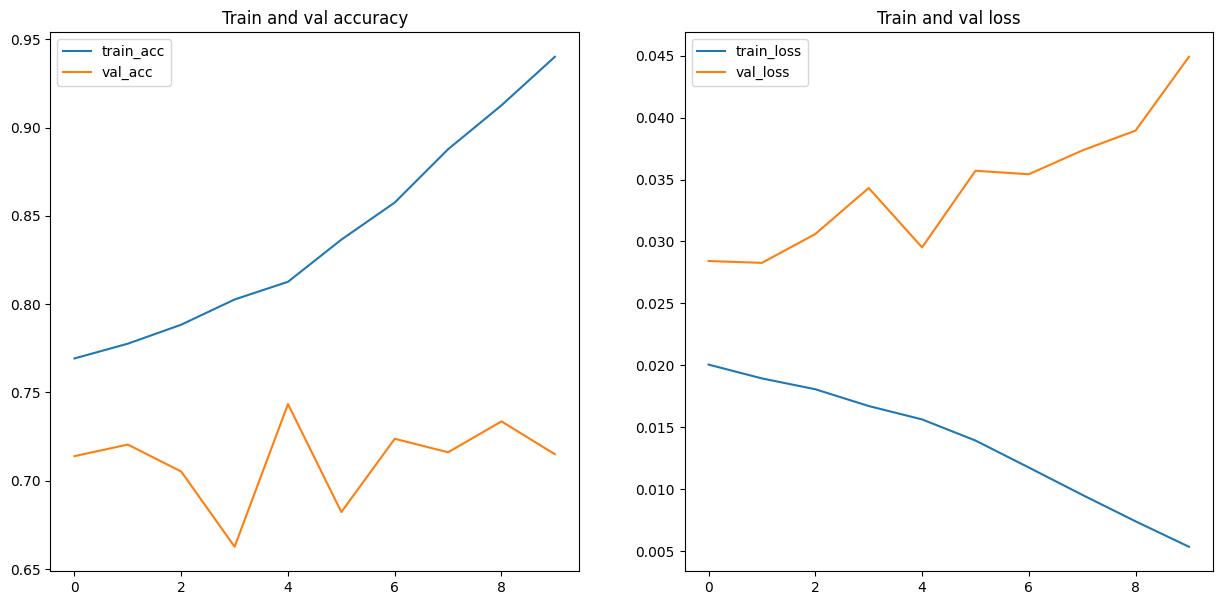

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=10, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_train_940_val_715.pth")

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=10, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.04054190615910714
Epoch 1 train accuracy: 0.5342027559055118
Epoch 1 val loss: 0.029767365760157722
Epoch 1 val accuracy: 0.7205240174672489 

Start training epoch 2
Epoch 2 train loss: 0.037407083461290895
Epoch 2 train accuracy: 0.5561843832020997
Epoch 2 val loss: 0.026946576466726945
Epoch 2 val accuracy: 0.732532751091703 

Start training epoch 3
Epoch 3 train loss: 0.03744670682222512
Epoch 3 train accuracy: 0.5530675853018373
Epoch 3 val loss: 0.029889723277898857
Epoch 3 val accuracy: 0.7085152838427947 

Start training epoch 4
Epoch 4 train loss: 0.03817187323970744
Epoch 4 train accuracy: 0.5454396325459318
Epoch 4 val loss: 0.027103431213761
Epoch 4 val accuracy: 0.7161572052401747 

Start training epoch 5
Epoch 5 train loss: 0.037499194314551794
Epoch 5 train accuracy: 0.5547080052493438
Epoch 5 val loss: 0.028906527304753467
Epoch 5 val accuracy: 0.7041484716157205 

Start training epoch 6
Epoch 6 train loss: 0.0

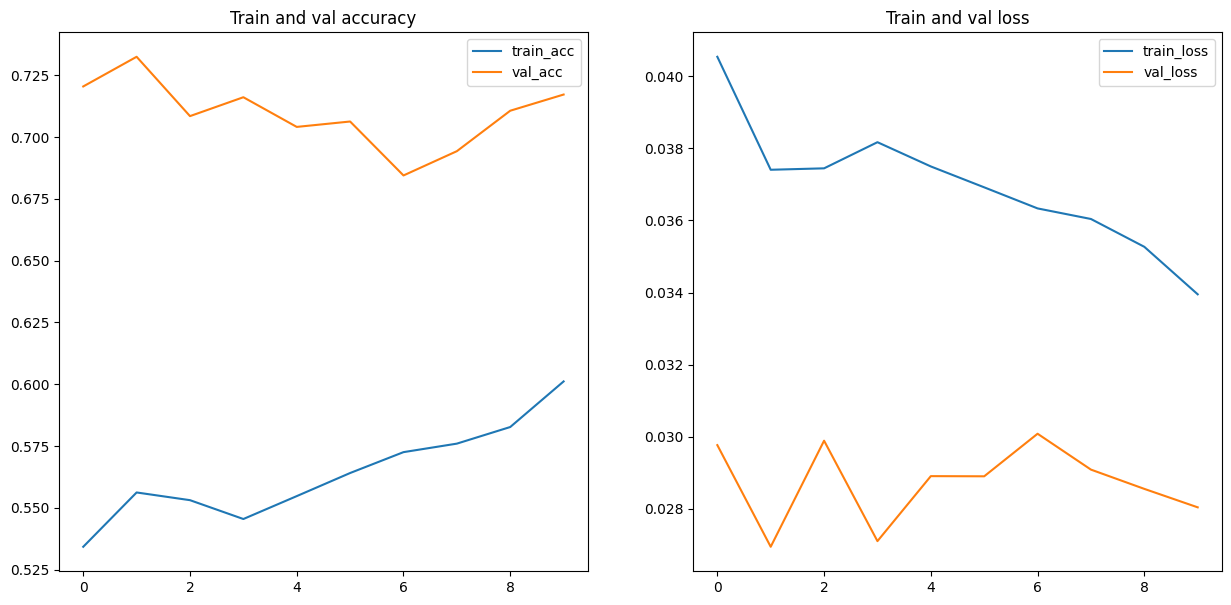

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=10, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_weather_train_601_val_717.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.032755485508502935
Epoch 1 train accuracy: 0.6106463254593176
Epoch 1 val loss: 0.027811097038104544
Epoch 1 val accuracy: 0.7172489082969432 

Start training epoch 2
Epoch 2 train loss: 0.032904503480812385
Epoch 2 train accuracy: 0.6129429133858267
Epoch 2 val loss: 0.03047286894774333
Epoch 2 val accuracy: 0.6790393013100436 

Start training epoch 3
Epoch 3 train loss: 0.033323553368801204
Epoch 3 train accuracy: 0.6085958005249343
Epoch 3 val loss: 0.029840470222536653
Epoch 3 val accuracy: 0.7019650655021834 

Start training epoch 4
Epoch 4 train loss: 0.0334056910430509
Epoch 4 train accuracy: 0.6022801837270341
Epoch 4 val loss: 0.027645762586827882
Epoch 4 val accuracy: 0.7150655021834061 

Start training epoch 5
Epoch 5 train loss: 0.03287078346323779
Epoch 5 train accuracy: 0.6110564304461942
Epoch 5 val loss: 0.02755444316299201
Epoch 5 val accuracy: 0.722707423580786 

Start training epoch 6
Epoch 6 train loss: 0.

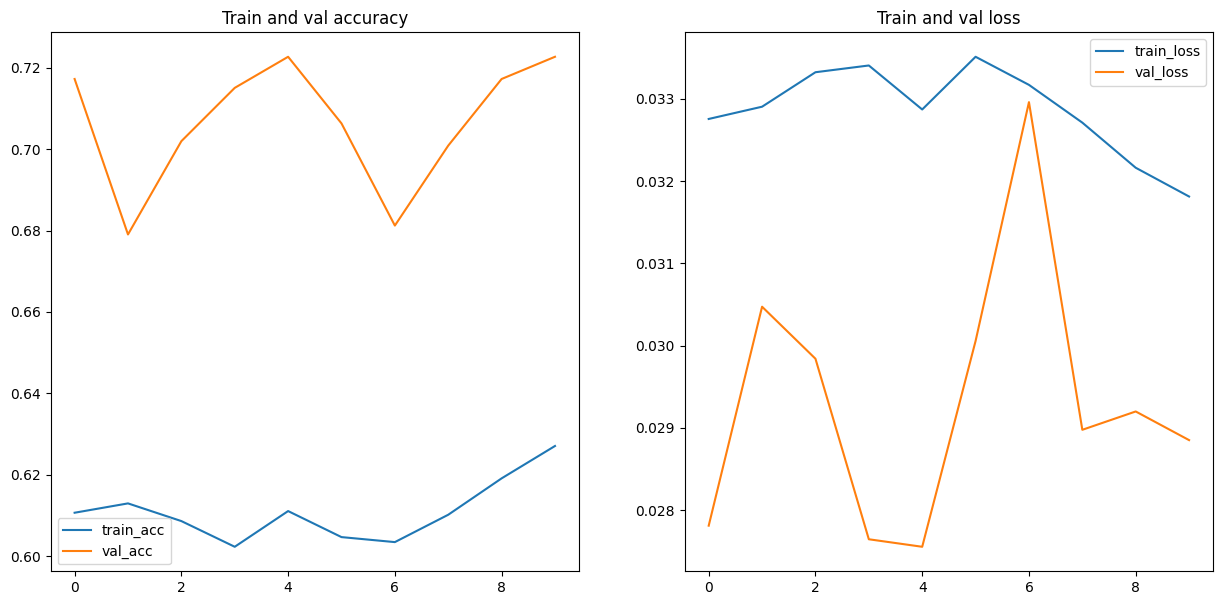

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_trained_model, 
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 2,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_weather_train_627_val_722.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02816338815391455
Epoch 1 train accuracy: 0.6744586614173228
Epoch 1 val loss: 0.027208017307337715
Epoch 1 val accuracy: 0.7336244541484717 

Start training epoch 2
Epoch 2 train loss: 0.02858659938672005
Epoch 2 train accuracy: 0.6656824146981627
Epoch 2 val loss: 0.026545406396472297
Epoch 2 val accuracy: 0.740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.02892450070169967
Epoch 3 train accuracy: 0.6633858267716536
Epoch 3 val loss: 0.028688606769497218
Epoch 3 val accuracy: 0.7336244541484717 

Start training epoch 4
Epoch 4 train loss: 0.029464339837431908
Epoch 4 train accuracy: 0.6523950131233596
Epoch 4 val loss: 0.028597867026860017
Epoch 4 val accuracy: 0.740174672489083 

Start training epoch 5
Epoch 5 train loss: 0.02887451070852167
Epoch 5 train accuracy: 0.6611712598425197
Epoch 5 val loss: 0.027954159442774594
Epoch 5 val accuracy: 0.7368995633187773 

Start training epoch 6
Epoch 6 train loss: 0.

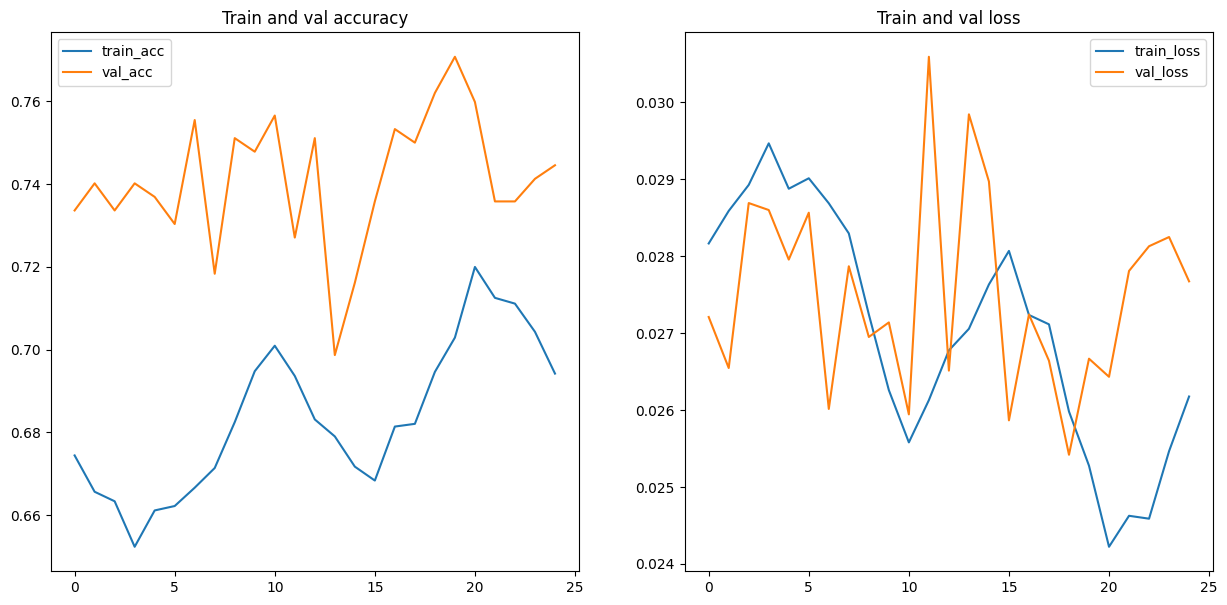

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_weather_train_627_val_722.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=25, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02366390216636063
Epoch 1 train accuracy: 0.7230150918635171
Epoch 1 val loss: 0.026156643592634577
Epoch 1 val accuracy: 0.767467248908297 

Start training epoch 2
Epoch 2 train loss: 0.023479765361746934
Epoch 2 train accuracy: 0.7267880577427821
Epoch 2 val loss: 0.026575617134310794
Epoch 2 val accuracy: 0.7609170305676856 

Start training epoch 3
Epoch 3 train loss: 0.022998580616211954
Epoch 3 train accuracy: 0.7311351706036745
Epoch 3 val loss: 0.02565748854560623
Epoch 3 val accuracy: 0.7751091703056768 

Start training epoch 4
Epoch 4 train loss: 0.023356541519461496
Epoch 4 train accuracy: 0.7256397637795275
Epoch 4 val loss: 0.026059368454472986
Epoch 4 val accuracy: 0.777292576419214 

Start training epoch 5
Epoch 5 train loss: 0.023138086003522705
Epoch 5 train accuracy: 0.7324475065616798
Epoch 5 val loss: 0.026200105578488137
Epoch 5 val accuracy: 0.7762008733624454 

Start training epoch 6
Epoch 6 train loss: 

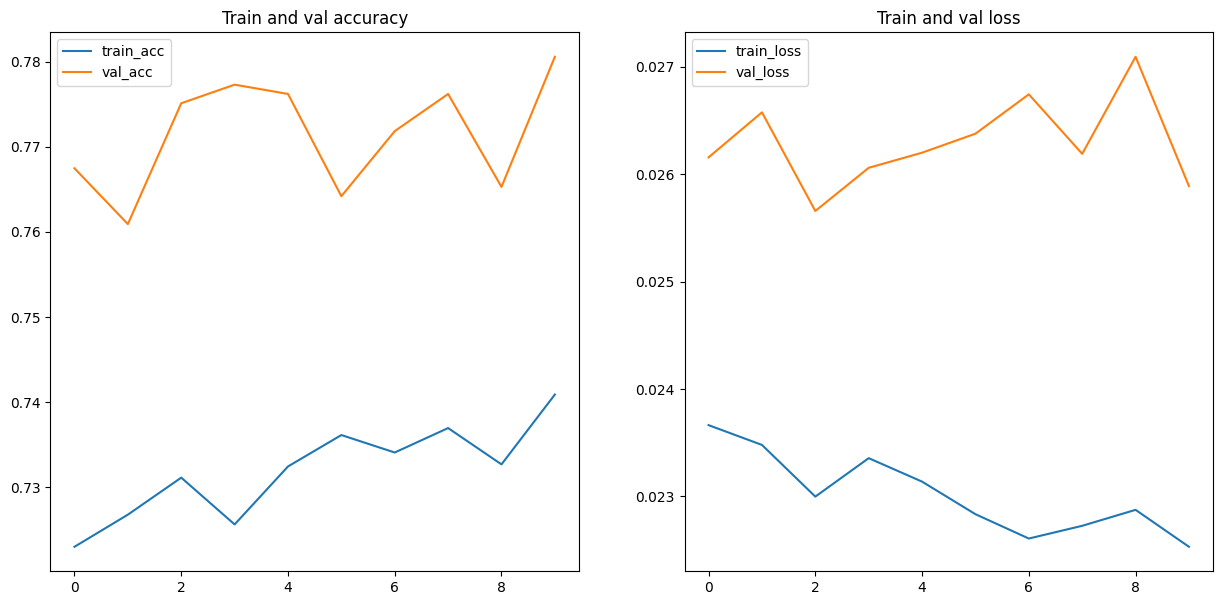

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_702_val_770.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='sgd',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0224617668733079
Epoch 1 train accuracy: 0.7410597112860893
Epoch 1 val loss: 0.026688867130654347
Epoch 1 val accuracy: 0.7707423580786026 

Start training epoch 2
Epoch 2 train loss: 0.022642196549635545
Epoch 2 train accuracy: 0.7322014435695539
Epoch 2 val loss: 0.026388580670913753
Epoch 2 val accuracy: 0.7685589519650655 

Start training epoch 3
Epoch 3 train loss: 0.022549464487106468
Epoch 3 train accuracy: 0.7360564304461942
Epoch 3 val loss: 0.026725739403322794
Epoch 3 val accuracy: 0.7718340611353712 

Start training epoch 4
Epoch 4 train loss: 0.0227630222289581
Epoch 4 train accuracy: 0.7360564304461942
Epoch 4 val loss: 0.026675960805478575
Epoch 4 val accuracy: 0.7631004366812227 

Start training epoch 5
Epoch 5 train loss: 0.022447983682976933
Epoch 5 train accuracy: 0.739501312335958
Epoch 5 val loss: 0.027279933044223284
Epoch 5 val accuracy: 0.7565502183406113 

Start training epoch 6
Epoch 6 train loss: 0

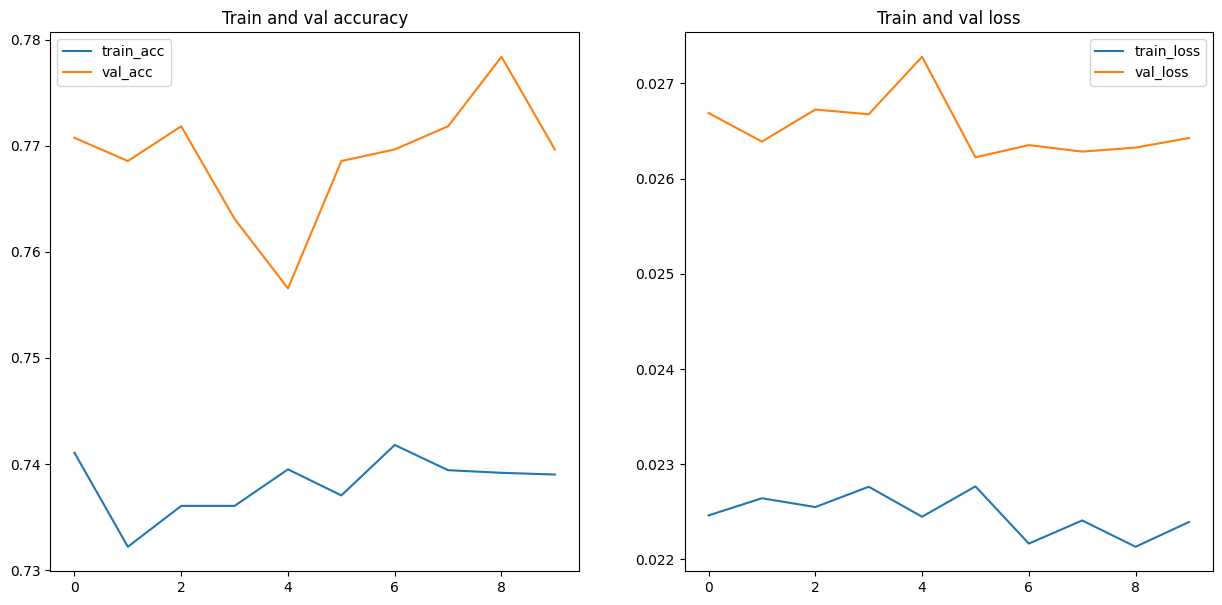

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 15,
                                            optimizer='sgd',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03525616984393966
Epoch 1 train accuracy: 0.5870242782152231
Epoch 1 val loss: 0.029417481159539204
Epoch 1 val accuracy: 0.7063318777292577 

Start training epoch 2
Epoch 2 train loss: 0.035557687952332294
Epoch 2 train accuracy: 0.5808727034120735
Epoch 2 val loss: 0.02802024301808474
Epoch 2 val accuracy: 0.7412663755458515 

Start training epoch 3
Epoch 3 train loss: 0.0362756762047374
Epoch 3 train accuracy: 0.5696358267716536
Epoch 3 val loss: 0.025973004707863238
Epoch 3 val accuracy: 0.740174672489083 

Start training epoch 4
Epoch 4 train loss: 0.03643152129951268
Epoch 4 train accuracy: 0.5767716535433071
Epoch 4 val loss: 0.026904101975620053
Epoch 4 val accuracy: 0.7358078602620087 

Start training epoch 5
Epoch 5 train loss: 0.03667577502765055
Epoch 5 train accuracy: 0.5707841207349081
Epoch 5 val loss: 0.02582507139665591
Epoch 5 val accuracy: 0.7368995633187773 

Start training epoch 6
Epoch 6 train loss: 0.03

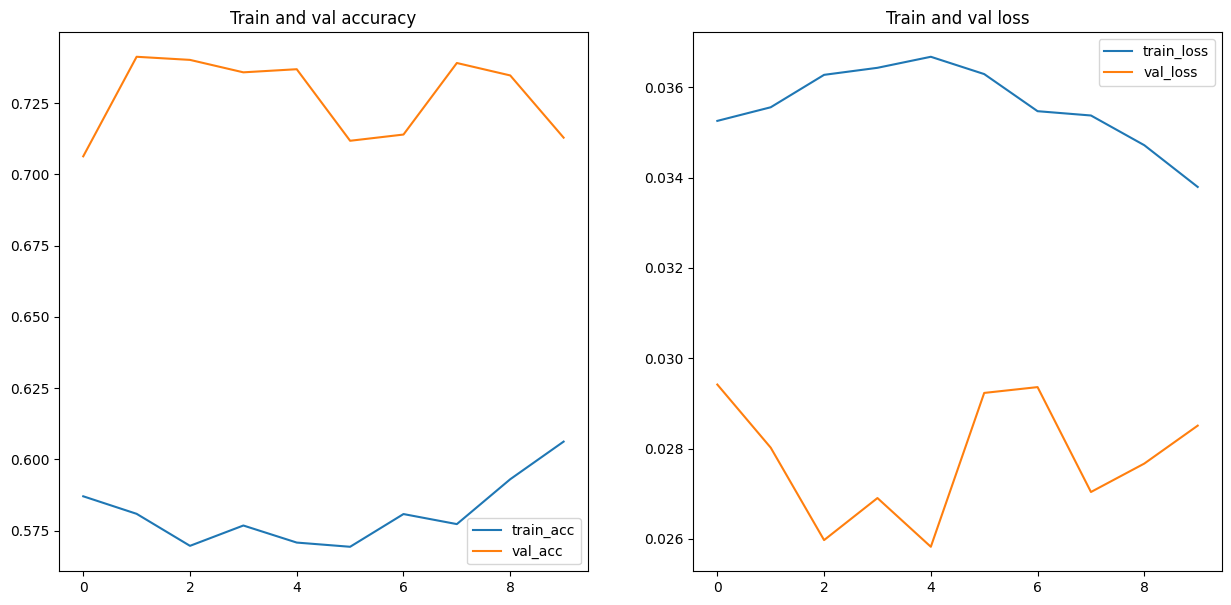

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_702_val_770.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_weather",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(darknet53_trained_model.state_dict(), f"{MODEL_DIR}/darknet53/darknet53_weather_train_627_val_722.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02816338815391455
Epoch 1 train accuracy: 0.6744586614173228
Epoch 1 val loss: 0.027208017307337715
Epoch 1 val accuracy: 0.7336244541484717 

Start training epoch 2
Epoch 2 train loss: 0.02858659938672005
Epoch 2 train accuracy: 0.6656824146981627
Epoch 2 val loss: 0.026545406396472297
Epoch 2 val accuracy: 0.740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.02892450070169967
Epoch 3 train accuracy: 0.6633858267716536
Epoch 3 val loss: 0.028688606769497218
Epoch 3 val accuracy: 0.7336244541484717 

Start training epoch 4
Epoch 4 train loss: 0.029464339837431908
Epoch 4 train accuracy: 0.6523950131233596
Epoch 4 val loss: 0.028597867026860017
Epoch 4 val accuracy: 0.740174672489083 

Start training epoch 5
Epoch 5 train loss: 0.02887451070852167
Epoch 5 train accuracy: 0.6611712598425197
Epoch 5 val loss: 0.027954159442774594
Epoch 5 val accuracy: 0.7368995633187773 

Start training epoch 6
Epoch 6 train loss: 0.

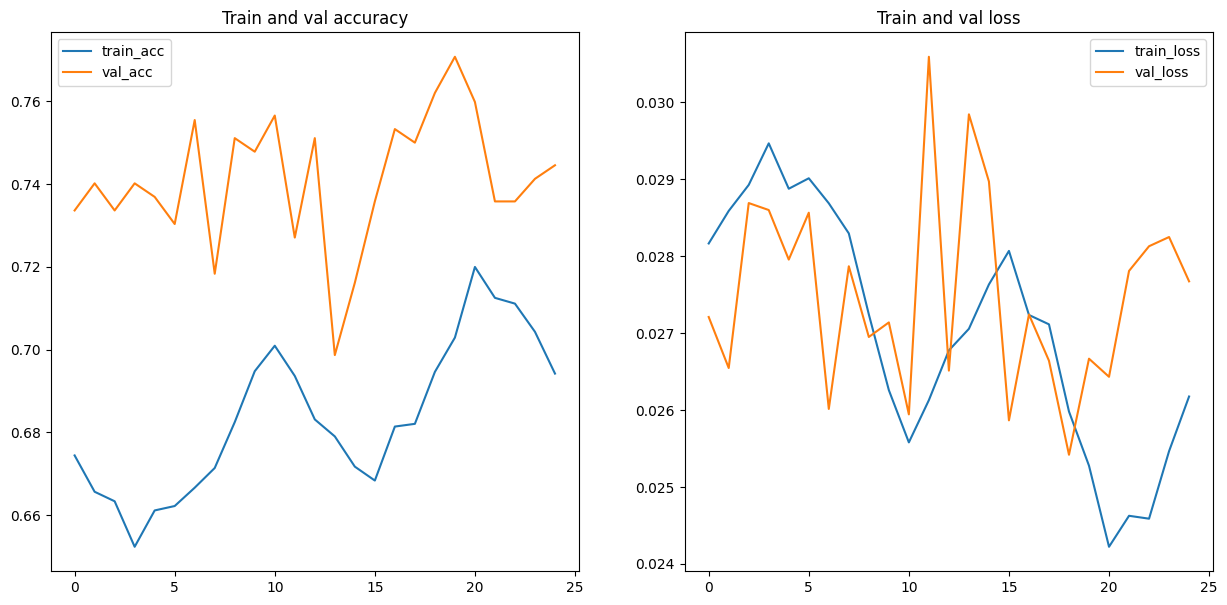

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_weather_train_627_val_722.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=25, 
                                            lr=LEARNING_RATE,
                                            optimizer='adamw',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02366390216636063
Epoch 1 train accuracy: 0.7230150918635171
Epoch 1 val loss: 0.026156643592634577
Epoch 1 val accuracy: 0.767467248908297 

Start training epoch 2
Epoch 2 train loss: 0.023479765361746934
Epoch 2 train accuracy: 0.7267880577427821
Epoch 2 val loss: 0.026575617134310794
Epoch 2 val accuracy: 0.7609170305676856 

Start training epoch 3
Epoch 3 train loss: 0.022998580616211954
Epoch 3 train accuracy: 0.7311351706036745
Epoch 3 val loss: 0.02565748854560623
Epoch 3 val accuracy: 0.7751091703056768 

Start training epoch 4
Epoch 4 train loss: 0.023356541519461496
Epoch 4 train accuracy: 0.7256397637795275
Epoch 4 val loss: 0.026059368454472986
Epoch 4 val accuracy: 0.777292576419214 

Start training epoch 5
Epoch 5 train loss: 0.023138086003522705
Epoch 5 train accuracy: 0.7324475065616798
Epoch 5 val loss: 0.026200105578488137
Epoch 5 val accuracy: 0.7762008733624454 

Start training epoch 6
Epoch 6 train loss: 

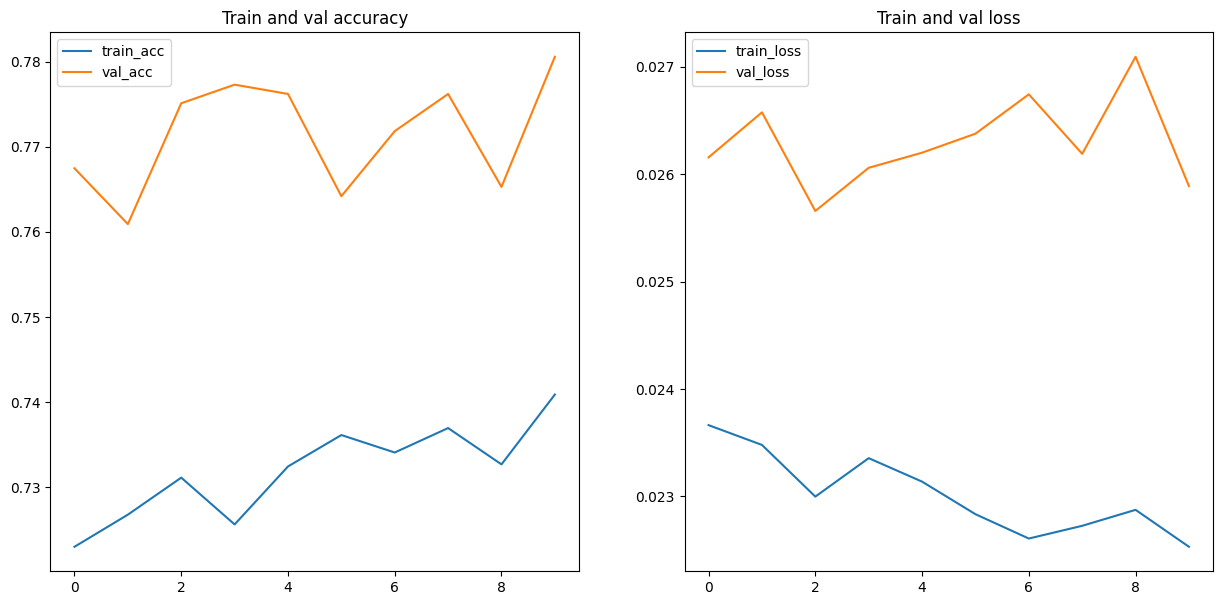

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_702_val_770.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='sgd',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0224617668733079
Epoch 1 train accuracy: 0.7410597112860893
Epoch 1 val loss: 0.026688867130654347
Epoch 1 val accuracy: 0.7707423580786026 

Start training epoch 2
Epoch 2 train loss: 0.022642196549635545
Epoch 2 train accuracy: 0.7322014435695539
Epoch 2 val loss: 0.026388580670913753
Epoch 2 val accuracy: 0.7685589519650655 

Start training epoch 3
Epoch 3 train loss: 0.022549464487106468
Epoch 3 train accuracy: 0.7360564304461942
Epoch 3 val loss: 0.026725739403322794
Epoch 3 val accuracy: 0.7718340611353712 

Start training epoch 4
Epoch 4 train loss: 0.0227630222289581
Epoch 4 train accuracy: 0.7360564304461942
Epoch 4 val loss: 0.026675960805478575
Epoch 4 val accuracy: 0.7631004366812227 

Start training epoch 5
Epoch 5 train loss: 0.022447983682976933
Epoch 5 train accuracy: 0.739501312335958
Epoch 5 val loss: 0.027279933044223284
Epoch 5 val accuracy: 0.7565502183406113 

Start training epoch 6
Epoch 6 train loss: 0

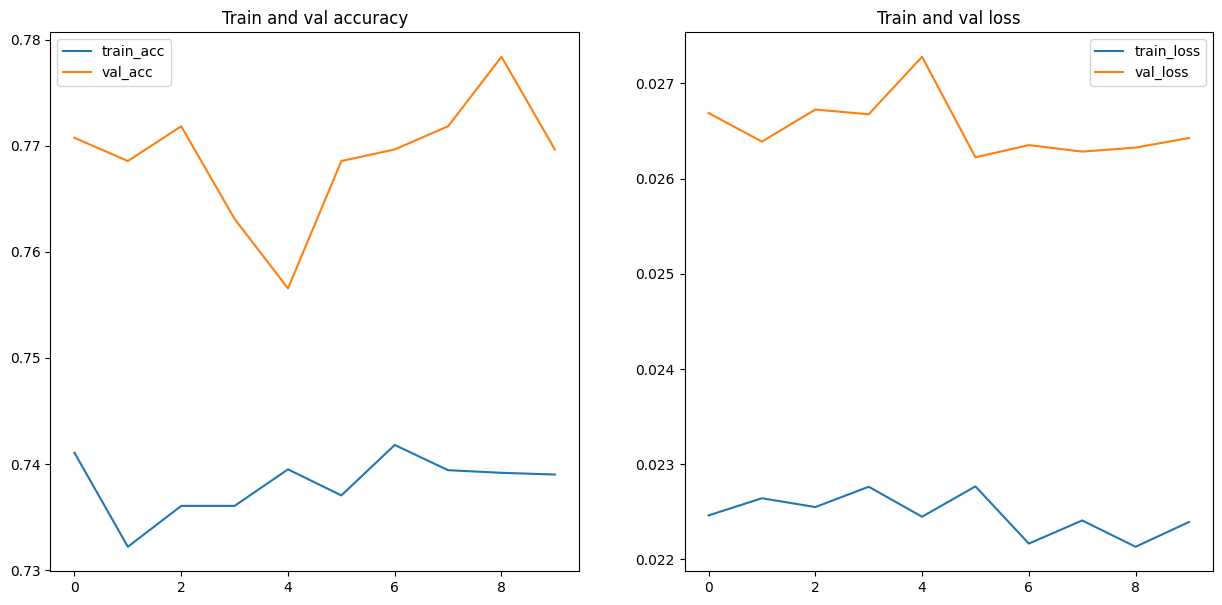

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 15,
                                            optimizer='sgd',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03465501999780731
Epoch 1 train accuracy: 0.5928477690288714
Epoch 1 val loss: 0.027478127240093516
Epoch 1 val accuracy: 0.74235807860262 

Start training epoch 2
Epoch 2 train loss: 0.03370558698307185
Epoch 2 train accuracy: 0.6058891076115486
Epoch 2 val loss: 0.025897155910339937
Epoch 2 val accuracy: 0.7620087336244541 

Start training epoch 3
Epoch 3 train loss: 0.03330930593738875
Epoch 3 train accuracy: 0.6161417322834646
Epoch 3 val loss: 0.027041631006517786
Epoch 3 val accuracy: 0.7434497816593887 

Start training epoch 4
Epoch 4 train loss: 0.03390898622005317
Epoch 4 train accuracy: 0.6031824146981627
Epoch 4 val loss: 0.026561619575627506
Epoch 4 val accuracy: 0.7521834061135371 

Start training epoch 5
Epoch 5 train loss: 0.033360038035771665
Epoch 5 train accuracy: 0.6064632545931758
Epoch 5 val loss: 0.025807183642574793
Epoch 5 val accuracy: 0.7565502183406113 

Start training epoch 6
Epoch 6 train loss: 0.

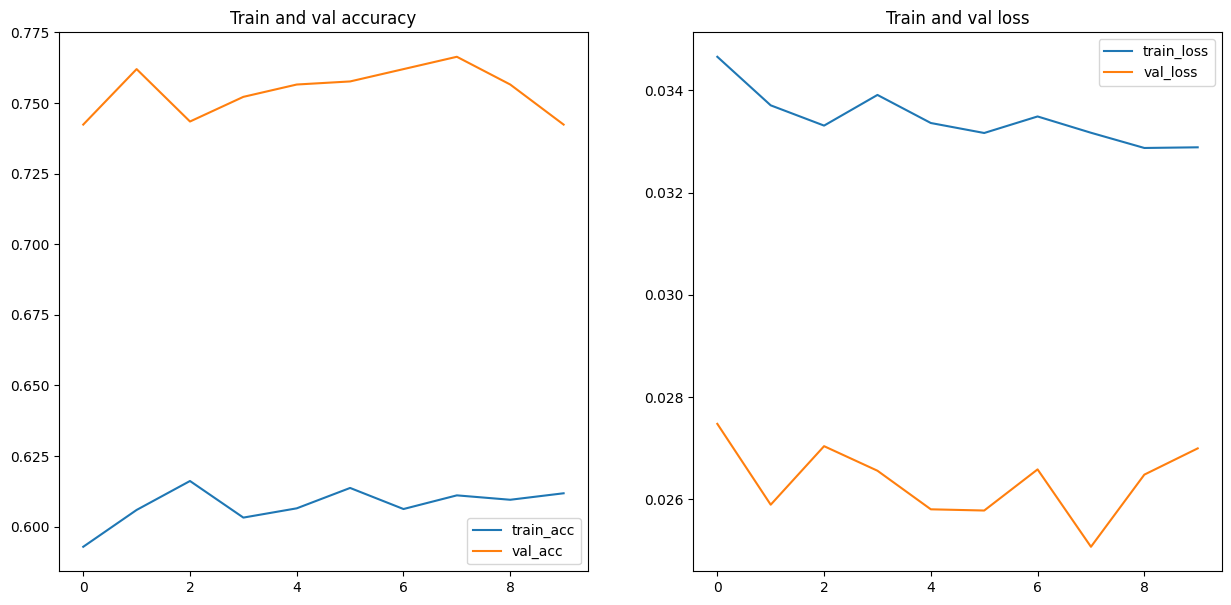

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_weather",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.032830755712752895
Epoch 1 train accuracy: 0.615239501312336
Epoch 1 val loss: 0.026287347501282088
Epoch 1 val accuracy: 0.7510917030567685 

Start training epoch 2
Epoch 2 train loss: 0.0327796110800245
Epoch 2 train accuracy: 0.6167979002624672
Epoch 2 val loss: 0.025678817556935105
Epoch 2 val accuracy: 0.7565502183406113 

Start training epoch 3
Epoch 3 train loss: 0.03257150728539063
Epoch 3 train accuracy: 0.6191765091863517
Epoch 3 val loss: 0.027715563318614876
Epoch 3 val accuracy: 0.7412663755458515 

Start training epoch 4
Epoch 4 train loss: 0.03235013708178922
Epoch 4 train accuracy: 0.6270505249343832
Epoch 4 val loss: 0.026525697251985166
Epoch 4 val accuracy: 0.7478165938864629 

Start training epoch 5
Epoch 5 train loss: 0.032786433294102586
Epoch 5 train accuracy: 0.6090879265091863
Epoch 5 val loss: 0.02787669279559731
Epoch 5 val accuracy: 0.7281659388646288 

Start training epoch 6
Epoch 6 train loss: 0.

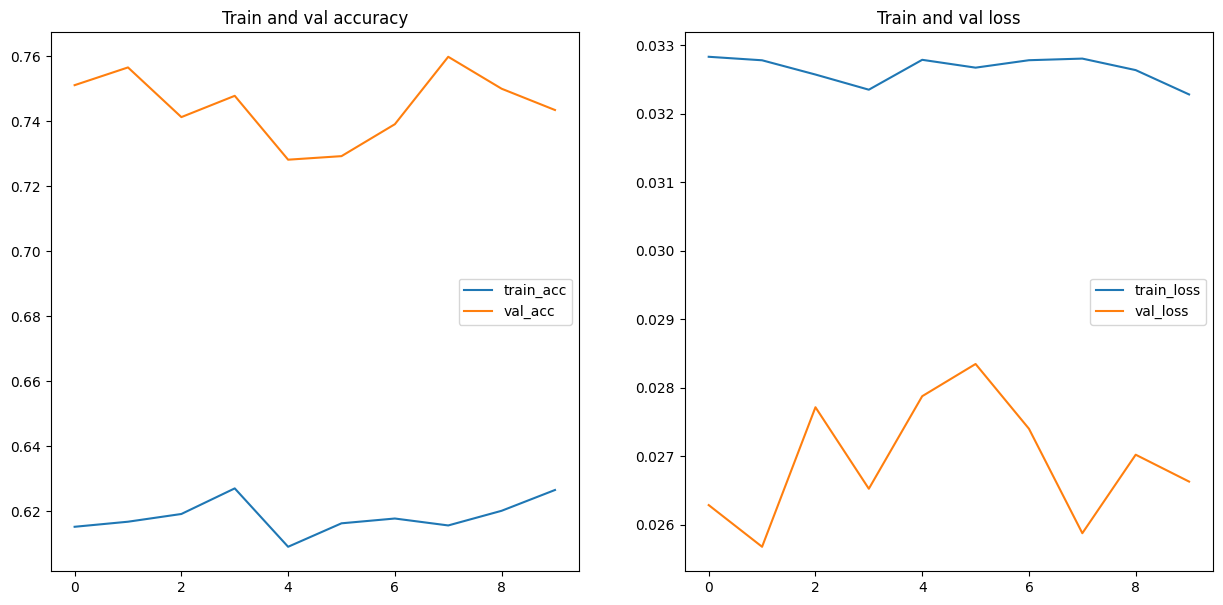

In [ ]:
darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_weather",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='adamw',
                                            train_dataloader=more_train_weather_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.027829994423085154
Epoch 1 train accuracy: 0.6702755905511811
Epoch 1 val loss: 0.02692006585314284
Epoch 1 val accuracy: 0.740174672489083 

Start training epoch 2
Epoch 2 train loss: 0.02924677803916881
Epoch 2 train accuracy: 0.6599409448818898
Epoch 2 val loss: 0.026883946560876337
Epoch 2 val accuracy: 0.7368995633187773 

Start training epoch 3
Epoch 3 train loss: 0.029970327401998162
Epoch 3 train accuracy: 0.650016404199475
Epoch 3 val loss: 0.026587184583646242
Epoch 3 val accuracy: 0.7478165938864629 

Start training epoch 4
Epoch 4 train loss: 0.029889353629191873
Epoch 4 train accuracy: 0.6526410761154856
Epoch 4 val loss: 0.02577240522706873
Epoch 4 val accuracy: 0.7510917030567685 

Start training epoch 5
Epoch 5 train loss: 0.02990483209549442
Epoch 5 train accuracy: 0.6484580052493438
Epoch 5 val loss: 0.027596581336842875
Epoch 5 val accuracy: 0.7554585152838428 

Start training epoch 6
Epoch 6 train loss: 0.

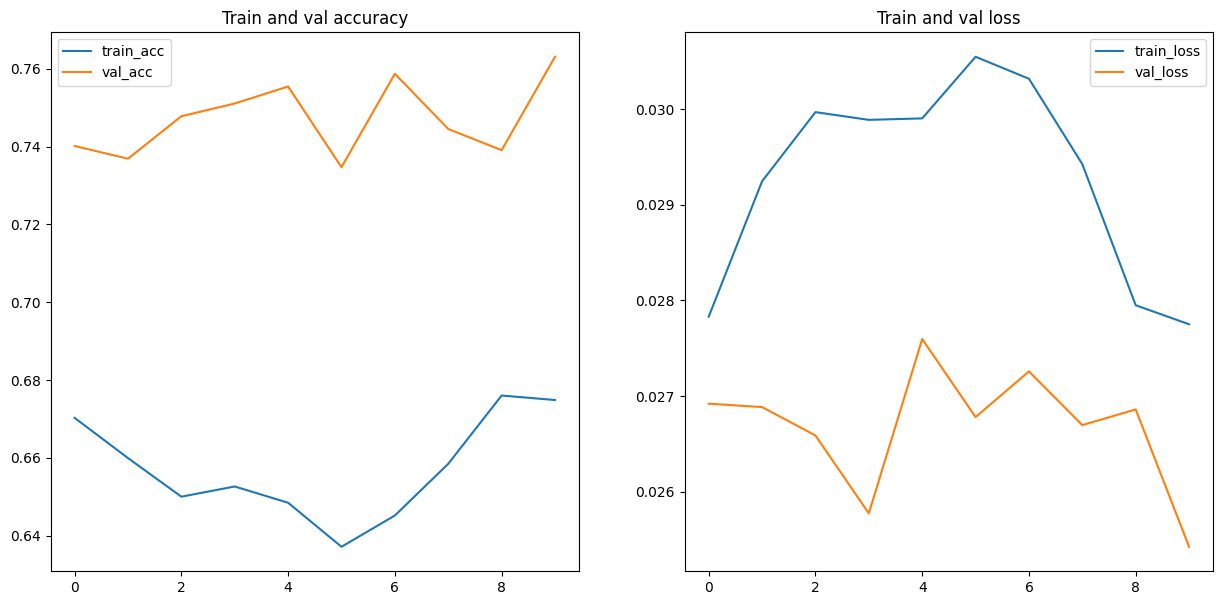

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_intense",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE,
                                            optimizer='sgd',
                                            train_dataloader=more_train_intense_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.026662980396975212
Epoch 1 train accuracy: 0.6870898950131233
Epoch 1 val loss: 0.02523552532019053
Epoch 1 val accuracy: 0.7685589519650655 

Start training epoch 2
Epoch 2 train loss: 0.025828949843100676
Epoch 2 train accuracy: 0.7007053805774278
Epoch 2 val loss: 0.025512797635975883
Epoch 2 val accuracy: 0.7641921397379913 

Start training epoch 3
Epoch 3 train loss: 0.026175247930635616
Epoch 3 train accuracy: 0.6960301837270341
Epoch 3 val loss: 0.025526945296203207
Epoch 3 val accuracy: 0.769650655021834 

Start training epoch 4
Epoch 4 train loss: 0.026033081236512955
Epoch 4 train accuracy: 0.6961942257217848
Epoch 4 val loss: 0.025720523873661284
Epoch 4 val accuracy: 0.7663755458515283 

Start training epoch 5
Epoch 5 train loss: 0.025642045475346993
Epoch 5 train accuracy: 0.6997211286089239
Epoch 5 val loss: 0.026162755817955758
Epoch 5 val accuracy: 0.767467248908297 

Start training epoch 6
Epoch 6 train loss:

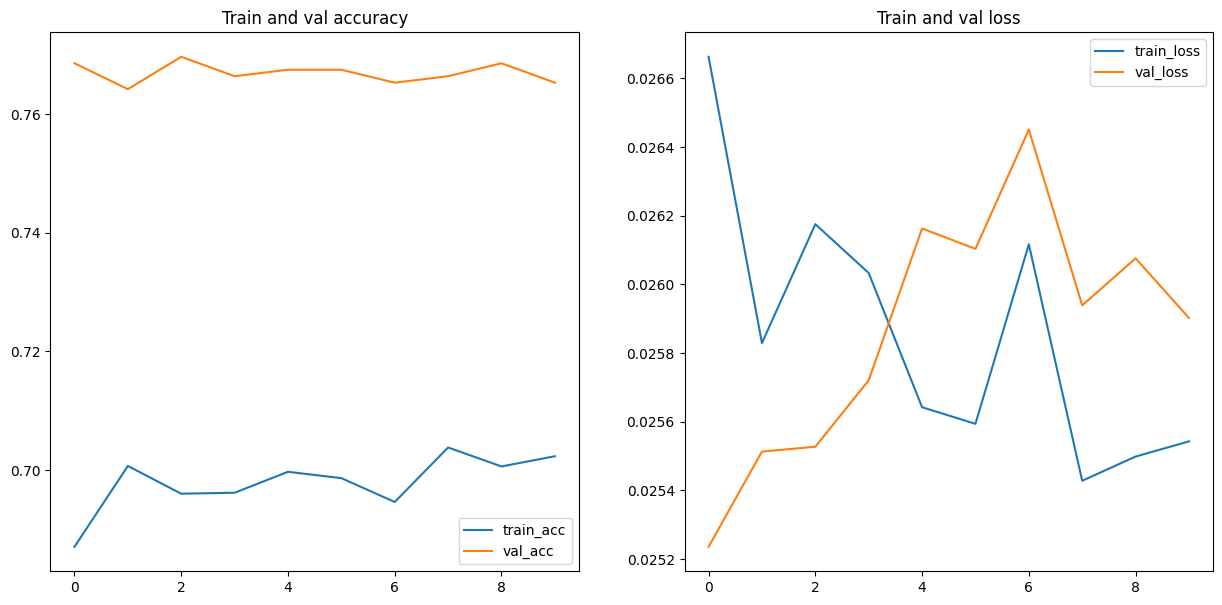

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_intense_train_674_val_763.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_intense",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 25,
                                            optimizer='sgd',
                                            train_dataloader=more_train_intense_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.007419906383052742
Epoch 1 train accuracy: 0.917732939632546
Epoch 1 val loss: 0.02824782752574271
Epoch 1 val accuracy: 0.7652838427947598 

Start training epoch 2
Epoch 2 train loss: 0.0067791895894455945
Epoch 2 train accuracy: 0.9250328083989501
Epoch 2 val loss: 0.029238824386914223
Epoch 2 val accuracy: 0.7707423580786026 

Start training epoch 3
Epoch 3 train loss: 0.006228111244021888
Epoch 3 train accuracy: 0.9299540682414699
Epoch 3 val loss: 0.029890547608183982
Epoch 3 val accuracy: 0.7816593886462883 

Start training epoch 4
Epoch 4 train loss: 0.005686735009879675
Epoch 4 train accuracy: 0.9352034120734908
Epoch 4 val loss: 0.031126945332408472
Epoch 4 val accuracy: 0.7740174672489083 

Start training epoch 5
Epoch 5 train loss: 0.005191072571675569
Epoch 5 train accuracy: 0.9411089238845144
Epoch 5 val loss: 0.03327469940919543
Epoch 5 val accuracy: 0.767467248908297 

Start training epoch 6
Epoch 6 train loss:

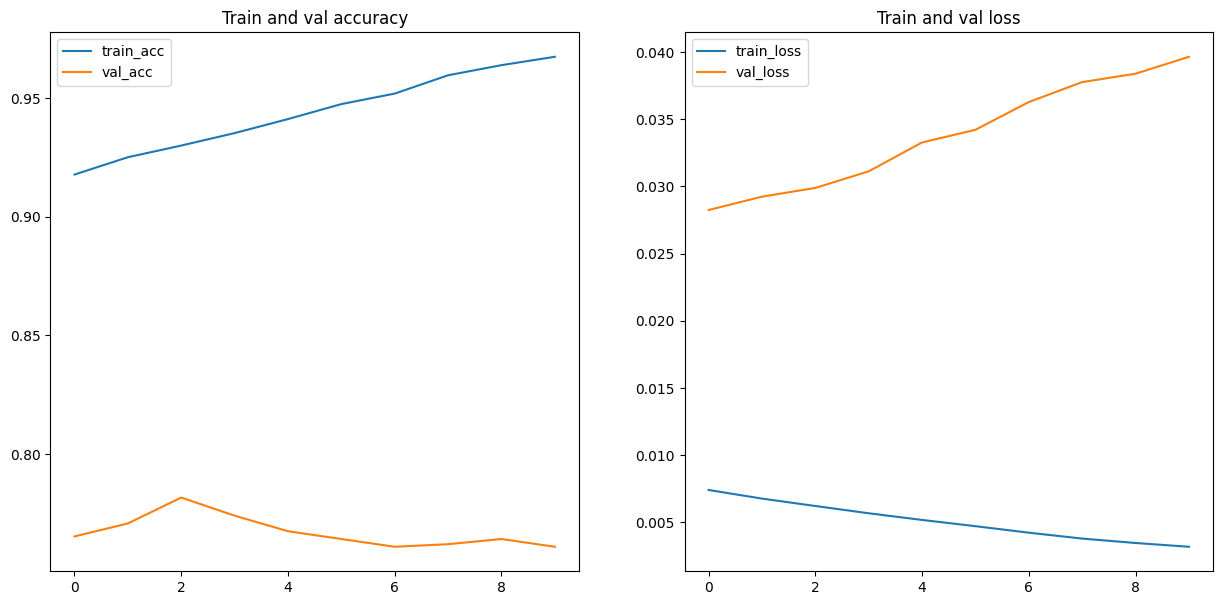

In [ ]:

darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='adamw',
                                            train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02354250889115055
Epoch 1 train accuracy: 0.7319553805774278
Epoch 1 val loss: 0.027915355224796778
Epoch 1 val accuracy: 0.769650655021834 

Start training epoch 2
Epoch 2 train loss: 0.022960102664712535
Epoch 2 train accuracy: 0.7339238845144357
Epoch 2 val loss: 0.026991681240531556
Epoch 2 val accuracy: 0.7729257641921398 

Start training epoch 3
Epoch 3 train loss: 0.022562131850327564
Epoch 3 train accuracy: 0.7395833333333334
Epoch 3 val loss: 0.027289137569577415
Epoch 3 val accuracy: 0.7652838427947598 

Start training epoch 4
Epoch 4 train loss: 0.022330844623288458
Epoch 4 train accuracy: 0.7404035433070866
Epoch 4 val loss: 0.026579883714169916
Epoch 4 val accuracy: 0.7707423580786026 

Start training epoch 5
Epoch 5 train loss: 0.02268829521309985
Epoch 5 train accuracy: 0.7371227034120735
Epoch 5 val loss: 0.026457210750559013
Epoch 5 val accuracy: 0.7762008733624454 

Start training epoch 6
Epoch 6 train loss:

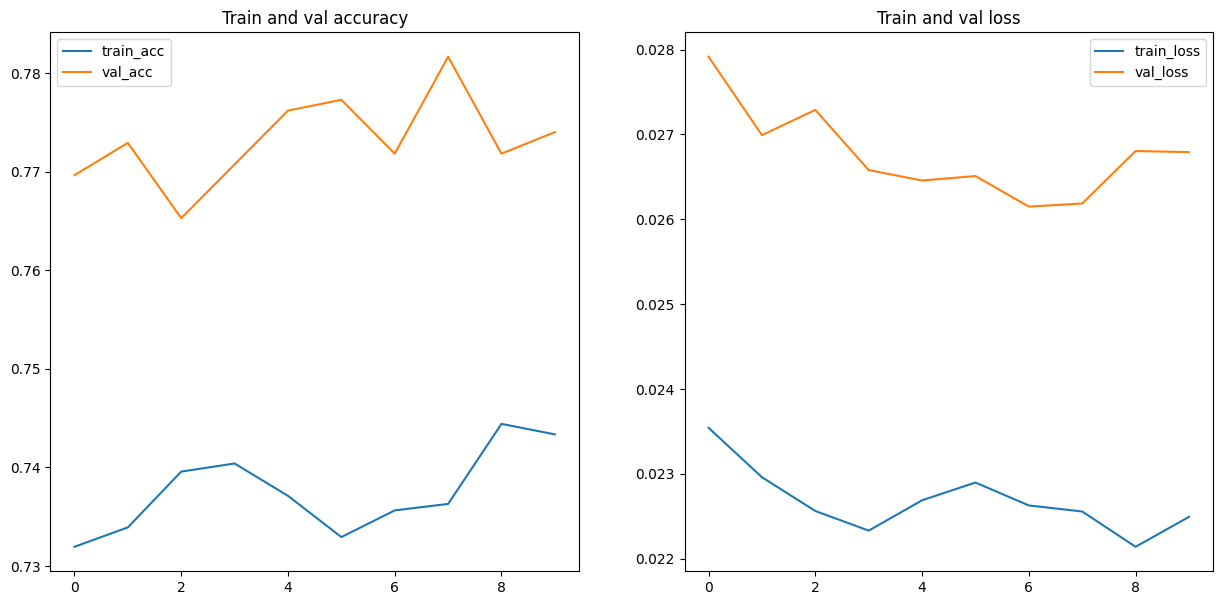

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_train_929_val_781.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_strong",
                                            num_epochs=10, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='sgd',
                                            train_dataloader=more_train_strong_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.021502647460914973
Epoch 1 train accuracy: 0.755495406824147
Epoch 1 val loss: 0.026544206462572755
Epoch 1 val accuracy: 0.7740174672489083 

Start training epoch 2
Epoch 2 train loss: 0.021689607994019828
Epoch 2 train accuracy: 0.7486876640419947
Epoch 2 val loss: 0.026493238927755815
Epoch 2 val accuracy: 0.7740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.02152762235462509
Epoch 3 train accuracy: 0.7445866141732284
Epoch 3 val loss: 0.026264559298623598
Epoch 3 val accuracy: 0.7762008733624454 

Start training epoch 4
Epoch 4 train loss: 0.02201538957567431
Epoch 4 train accuracy: 0.7435203412073491
Epoch 4 val loss: 0.027086804690059096
Epoch 4 val accuracy: 0.7718340611353712 

Start training epoch 5
Epoch 5 train loss: 0.02149641040829927
Epoch 5 train accuracy: 0.7473753280839895
Epoch 5 val loss: 0.027373007811833678
Epoch 5 val accuracy: 0.7631004366812227 



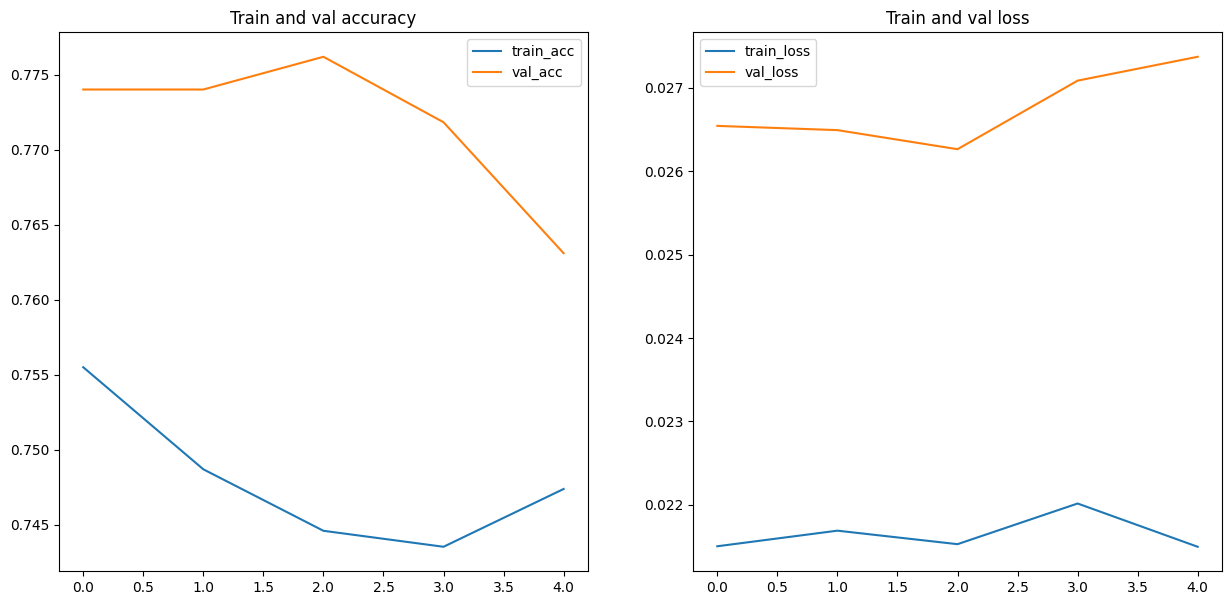

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_736_val_781.pth"))
darknet53_model.eval()

darknet53_trained_model, _, _ = train_model(darknet53_model, 
                                            save_dir=f"{MODEL_DIR}/darknet53",
                                            name="darknet53_hard",
                                            num_epochs=5, 
                                            lr=LEARNING_RATE / 10,
                                            optimizer='sgd',
                                            train_dataloader=more_train_hard_classification_dataloader)

### CSPDarkNet53

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


ACTIVATIONS = {
    'mish': Mish(),
    'leaky': nn.LeakyReLU(negative_slope=0.1),
    'linear': nn.Identity()
}


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='mish'):
        super(Conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            ACTIVATIONS[activation]
        )

    def forward(self, x):
        return self.conv(x)


class CSPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, residual_activation='linear'):
        super(CSPBlock, self).__init__()

        if hidden_channels is None:
            hidden_channels = out_channels

        self.block = nn.Sequential(
            Conv(in_channels, hidden_channels, 1),
            Conv(hidden_channels, out_channels, 3)
        )

        self.activation = ACTIVATIONS[residual_activation]

    def forward(self, x):
        return self.activation(x+self.block(x))


class CSPFirstStage(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPFirstStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels, 1)
        self.split_conv1 = Conv(out_channels, out_channels, 1)

        self.blocks_conv = nn.Sequential(
            CSPBlock(out_channels, out_channels, in_channels),
            Conv(out_channels, out_channels, 1)
        )

        self.concat_conv = Conv(out_channels*2, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks):
        super(CSPStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels//2, 1)
        self.split_conv1 = Conv(out_channels, out_channels//2, 1)

        self.blocks_conv = nn.Sequential(
            *[CSPBlock(out_channels//2, out_channels//2)
                       for _ in range(num_blocks)],
            Conv(out_channels//2, out_channels//2, 1)
        )

        self.concat_conv = Conv(out_channels, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPDarknet53(nn.Module):
    def __init__(self, 
               stem_channels=32, 
               feature_channels=[64, 128, 256, 512, 1024], 
               num_features=3,
               num_classes=1000):
        super(CSPDarknet53, self).__init__()
        self.stem_conv = Conv(3, stem_channels, 3)
        self.stages = nn.ModuleList([
      CSPFirstStage(stem_channels, feature_channels[0]),
      CSPStage(feature_channels[0], feature_channels[1], 2),
      CSPStage(feature_channels[1], feature_channels[2], 8),
      CSPStage(feature_channels[2], feature_channels[3], 8),
      CSPStage(feature_channels[3], feature_channels[4], 4)
    ])

        self.feature_channels = feature_channels
        self.num_classes = num_classes

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(1024, self.num_classes, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                    
    def extract_features(self, x):
        features = []

        x = self.stem_conv(x)

        x = self.stages[0](x)#//2
        x = self.stages[1](x)#//4
        x8 = self.stages[2](x)#//8
        features.append(x8)

        x16 = self.stages[3](x8)#//16
        features.append(x16)

        x32 = self.stages[4](x16)#//32
        features.append(x32)

        return features
    
    def forward(self, x):
        features = self.extract_features(x)
        x = self.gap(features[-1])
        x = self.fc(x)
        x = x.flatten(start_dim=1)
        return x

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.08387849730221932
Epoch 1 train accuracy: 0.1985728346456693
Epoch 1 val loss: 0.08478605018432483
Epoch 1 val accuracy: 0.13646288209606988 

Start training epoch 2
Epoch 2 train loss: 0.06501405963825742
Epoch 2 train accuracy: 0.2733759842519685
Epoch 2 val loss: 0.08623727570454627
Epoch 2 val accuracy: 0.13537117903930132 

Start training epoch 3
Epoch 3 train loss: 0.05641351840666586
Epoch 3 train accuracy: 0.34744094488188976
Epoch 3 val loss: 0.08136777820545513
Epoch 3 val accuracy: 0.13973799126637554 

Start training epoch 4
Epoch 4 train loss: 0.05098609387718161
Epoch 4 train accuracy: 0.41297572178477693
Epoch 4 val loss: 0.08439569220792778
Epoch 4 val accuracy: 0.1539301310043668 

Start training epoch 5
Epoch 5 train loss: 0.045694465634078175
Epoch 5 train accuracy: 0.4734251968503937
Epoch 5 val loss: 0.08637015710230998
Epoch 5 val accuracy: 0.1703056768558952 

Start training epoch 6
Epoch 6 train loss: 

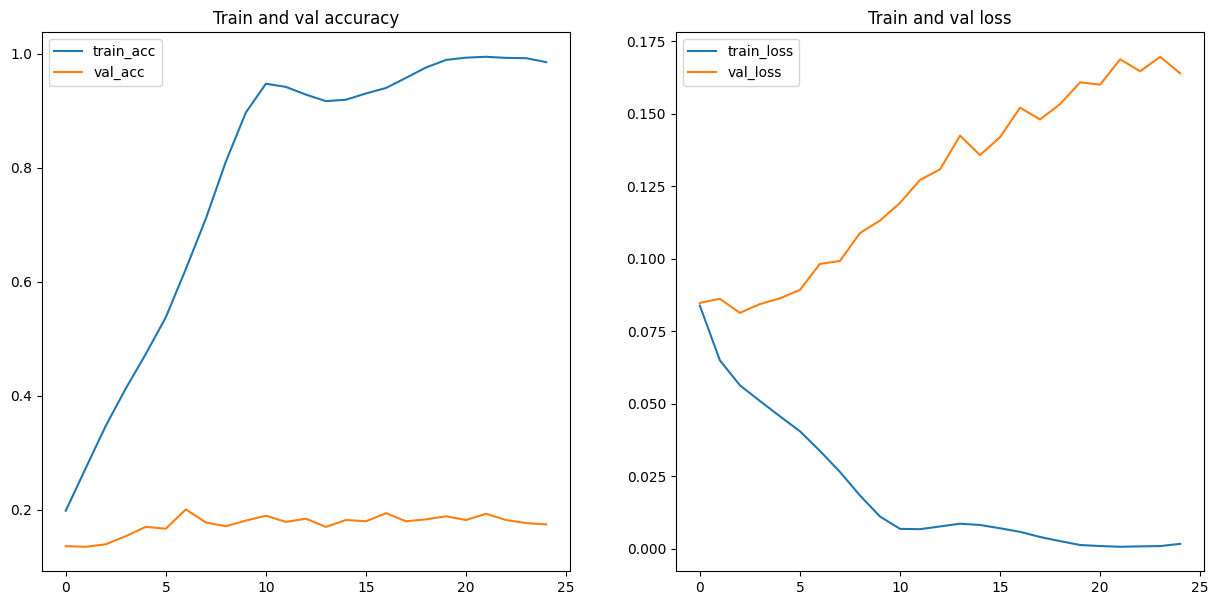

In [ ]:
cspdarknet53_model = CSPDarknet53(num_classes=8)
cspdarknet53_trained_model, _, _ = train_model(cspdarknet53_model,
                                       save_dir=f"{MODEL_DIR}/cspdarknet53",
                                       num_epochs=25,
                                       name="cspdarknet53",
                                       lr=LEARNING_RATE,
                                       optimizer='adamw',
                                       train_dataloader=more_train_classification_dataloader)

In [ ]:
torch.save(cspdarknet53_trained_model.state_dict(), f"{MODEL_DIR}/cspdarknet53/cspdarknet53_train_985_val_174.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.08009521834298068
Epoch 1 train accuracy: 0.22276902887139108
Epoch 1 val loss: 0.058961706976182596
Epoch 1 val accuracy: 0.3951965065502183 

Start training epoch 2
Epoch 2 train loss: 0.0651632360331812
Epoch 2 train accuracy: 0.2637795275590551
Epoch 2 val loss: 0.04892405893604828
Epoch 2 val accuracy: 0.41593886462882096 

Start training epoch 3
Epoch 3 train loss: 0.06119824821750323
Epoch 3 train accuracy: 0.2828083989501312
Epoch 3 val loss: 0.049289144933484005
Epoch 3 val accuracy: 0.43013100436681223 

Start training epoch 4
Epoch 4 train loss: 0.06048957191974785
Epoch 4 train accuracy: 0.2943733595800525
Epoch 4 val loss: 0.0459934532251941
Epoch 4 val accuracy: 0.5141921397379913 

Start training epoch 5
Epoch 5 train loss: 0.05771318861232029
Epoch 5 train accuracy: 0.3093011811023622
Epoch 5 val loss: 0.05456649137896742
Epoch 5 val accuracy: 0.361353711790393 

Start training epoch 6
Epoch 6 train loss: 0.05

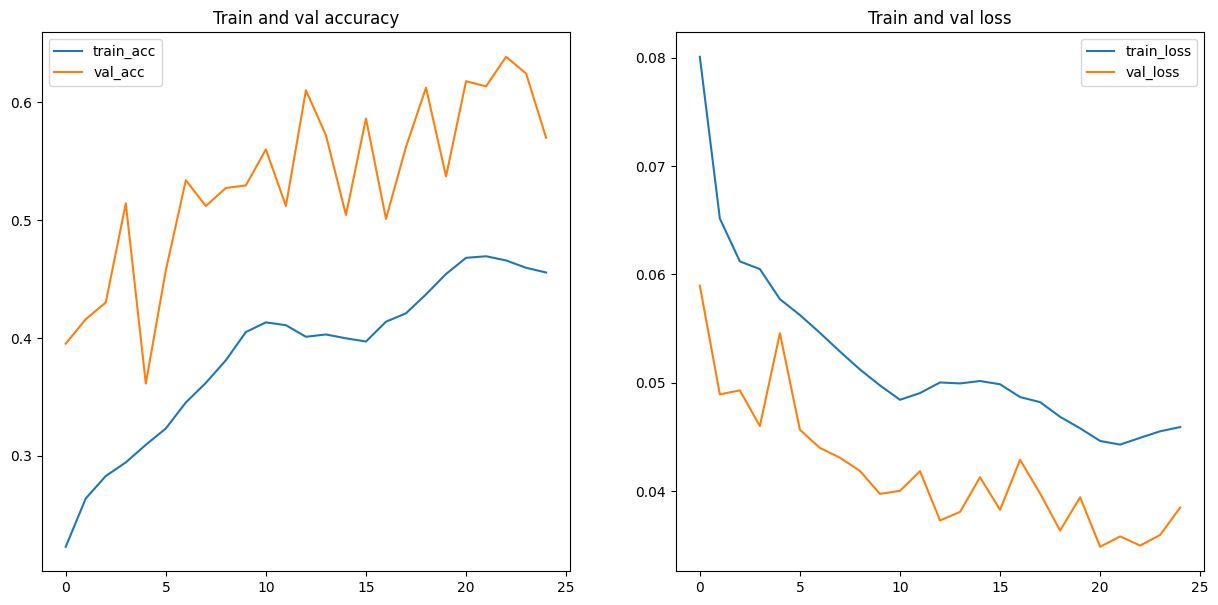

In [ ]:
cspdarknet53_model = CSPDarknet53(num_classes=8)
cspdarknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/cspdarknet53/cspdarknet53_train_985_val_174.pth"))
cspdarknet53_model.eval()

cspdarknet53_trained_model = train_model(cspdarknet53_model,
                                         save_dir=f"{MODEL_DIR}/cspdarknet53",
                                         num_epochs=25,
                                         name="cspdarknet53",
                                         lr=LEARNING_RATE,
                                         optimizer='adamw',
                                         train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.04305917231898921
Epoch 1 train accuracy: 0.48408792650918636
Epoch 1 val loss: 0.034353811082361047
Epoch 1 val accuracy: 0.638646288209607 

Start training epoch 2
Epoch 2 train loss: 0.0424666005453178
Epoch 2 train accuracy: 0.49663713910761154
Epoch 2 val loss: 0.035655650119073526
Epoch 2 val accuracy: 0.6026200873362445 

Start training epoch 3
Epoch 3 train loss: 0.042658830467328
Epoch 3 train accuracy: 0.4968011811023622
Epoch 3 val loss: 0.032715756299714335
Epoch 3 val accuracy: 0.6550218340611353 

Start training epoch 4
Epoch 4 train loss: 0.042934889389382884
Epoch 4 train accuracy: 0.49040354330708663
Epoch 4 val loss: 0.034360714874933904
Epoch 4 val accuracy: 0.6441048034934498 

Start training epoch 5
Epoch 5 train loss: 0.042720601969738335
Epoch 5 train accuracy: 0.49958989501312334
Epoch 5 val loss: 0.03614176556012516
Epoch 5 val accuracy: 0.6037117903930131 

Start training epoch 6
Epoch 6 train loss: 

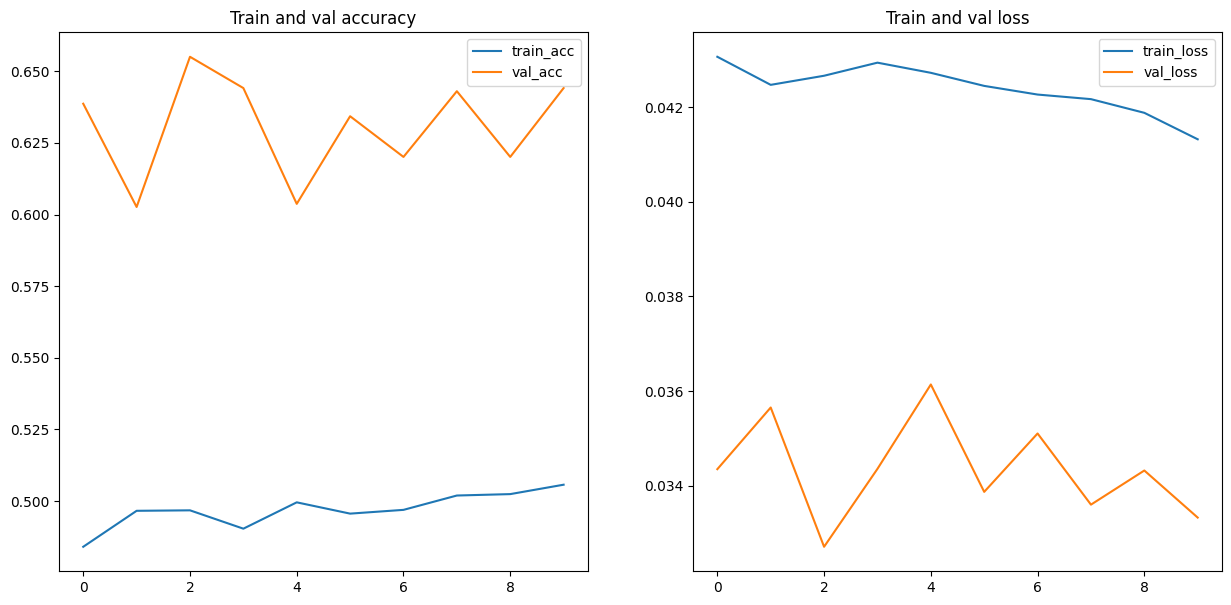

In [ ]:
cspdarknet53_model = CSPDarknet53(num_classes=8)
cspdarknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/cspdarknet53/cspdarknet53_train_465_val_638.pth"))
cspdarknet53_model.eval()

cspdarknet53_trained_model = train_model(cspdarknet53_model,
                                         save_dir=f"{MODEL_DIR}/cspdarknet53",
                                         num_epochs=10,
                                         name="cspdarknet53",
                                         lr=LEARNING_RATE / 5,
                                         train_dataloader=more_train_hard_classification_dataloader)

### Train more with Flowers102

In [ ]:
class Flowers102Model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.fc = nn.Linear(8, 102)

    def forward(self, x):
        out = self.model(x)
        out = self.fc(out)
        return out


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06557315719478271
Epoch 1 train accuracy: 0.4934129901960784
Epoch 1 val loss: 0.07829217553138733
Epoch 1 val accuracy: 0.42875 

Start training epoch 2
Epoch 2 train loss: 0.06322278520640205
Epoch 2 train accuracy: 0.5024509803921569
Epoch 2 val loss: 0.07810528203845024
Epoch 2 val accuracy: 0.42875 

Start training epoch 3
Epoch 3 train loss: 0.061222728031376995
Epoch 3 train accuracy: 0.5160845588235294
Epoch 3 val loss: 0.0801488584280014
Epoch 3 val accuracy: 0.3975 

Start training epoch 4
Epoch 4 train loss: 0.05881517561262145
Epoch 4 train accuracy: 0.5324754901960784
Epoch 4 val loss: 0.0720656219124794
Epoch 4 val accuracy: 0.4525 

Start training epoch 5
Epoch 5 train loss: 0.05676929881869286
Epoch 5 train accuracy: 0.5464154411764706
Epoch 5 val loss: 0.08502659678459168
Epoch 5 val accuracy: 0.36125 

Start training epoch 6
Epoch 6 train loss: 0.05450964487139501
Epoch 6 train accuracy: 0.5580575980392157
E

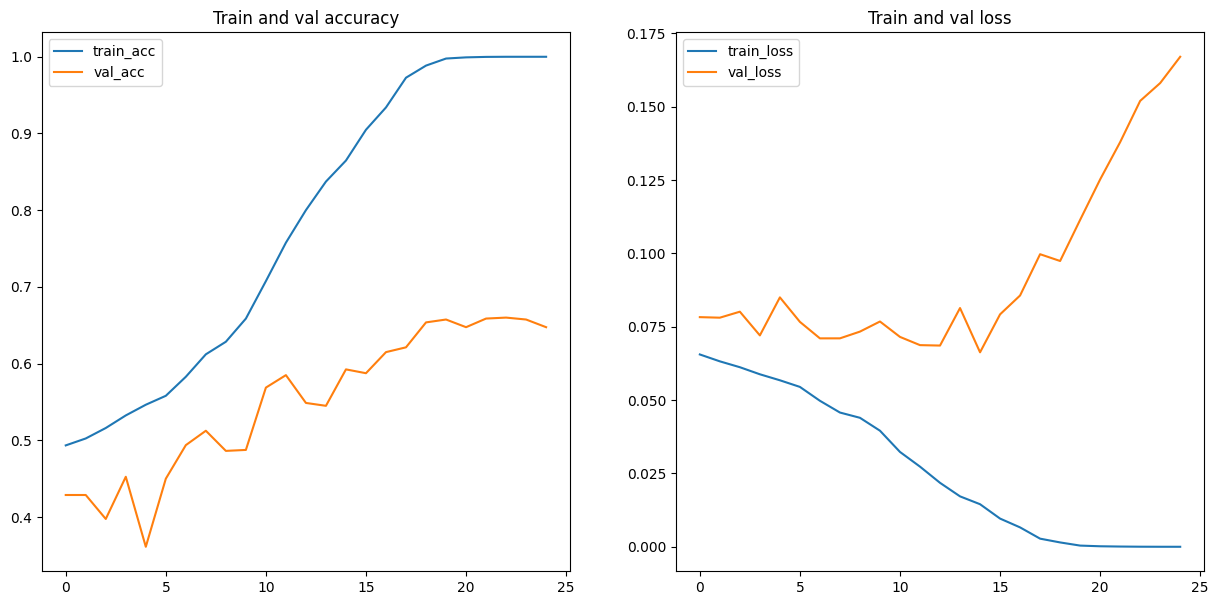

In [ ]:
# darknet53_model = darknet53(num_classes=8)
# darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_weather_train_627_val_722.pth"))
# darknet53_model.eval()

# flowers102_darknet53_model = Flowers102Model(darknet53_model)

flowers102_darknet53_trained_model, _, _ = train_model(flowers102_darknet53_model,
                                                 save_dir=f"{MODEL_DIR}/darknet53",
                                                 name="darknet53_flowers102",
                                                 num_epochs=25,
                                                 lr=LEARNING_RATE * 2,
                                                 optimizer='adamw',
                                                 train_dataloader=flowers102_train_dataloader,
                                                 val_dataloader=flowers102_val_dataloader
                                                 )



In [ ]:
flowers102_darknet53_model = Flowers102Model(darknet53_model)
flowers102_darknet53_model.load_state_dict(torch.load(f"{MODEL_DIR}/darknet53/darknet53_flowers102_train_999_val_658.pth"))
flowers102_darknet53_model.eval()

flowers102_darknet53_trained_model, _, _ = train_model(flowers102_darknet53_model,
                                                 save_dir=f"{MODEL_DIR}/darknet53",
                                                 name="darknet53_flowers102",
                                                 num_epochs=25,
                                                 lr=LEARNING_RATE,
                                                 optimizer='adamw',
                                                 train_dataloader=flowers102_train_hard_dataloader,
                                                 val_dataloader=flowers102_val_dataloader
                                                 )

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.10630879642478391
Epoch 1 train accuracy: 0.2789522058823529
Epoch 1 val loss: 0.05878004118800163
Epoch 1 val accuracy: 0.5775 

Start training epoch 2
Epoch 2 train loss: 0.08326942088338089
Epoch 2 train accuracy: 0.39231004901960786
Epoch 2 val loss: 0.05440214768052101
Epoch 2 val accuracy: 0.59375 

Start training epoch 3
Epoch 3 train loss: 0.08086393746163915
Epoch 3 train accuracy: 0.4071691176470588
Epoch 3 val loss: 0.05598399743437767
Epoch 3 val accuracy: 0.58 

Start training epoch 4
Epoch 4 train loss: 0.07898691963112238
Epoch 4 train accuracy: 0.41712622549019607
Epoch 4 val loss: 0.05134712666273117
Epoch 4 val accuracy: 0.6175 

Start training epoch 5
Epoch 5 train loss: 0.0769090205796209
Epoch 5 train accuracy: 0.42784926470588236
Epoch 5 val loss: 0.052086696699261664
Epoch 5 val accuracy: 0.595 

Start training epoch 6
Epoch 6 train loss: 0.07663609596955426
Epoch 6 train accuracy: 0.43045343137254904
E

Note: try to add He init

gradient explosion => Resnet 

### Resnet

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.08041837549080019
Epoch 1 train accuracy: 0.1983695652173913
Epoch 1 val loss: 0.0705948013926177
Epoch 1 val accuracy: 0.19323144104803494 

Start training epoch 2
Epoch 2 train loss: 0.06512608865033025
Epoch 2 train accuracy: 0.22880434782608697
Epoch 2 val loss: 0.06517989224221508
Epoch 2 val accuracy: 0.2314410480349345 

Start training epoch 3
Epoch 3 train loss: 0.06150211798756019
Epoch 3 train accuracy: 0.26059782608695653
Epoch 3 val loss: 0.063587891092467
Epoch 3 val accuracy: 0.2183406113537118 

Start training epoch 4
Epoch 4 train loss: 0.060111169484646426
Epoch 4 train accuracy: 0.29347826086956524
Epoch 4 val loss: 0.06580165900517759
Epoch 4 val accuracy: 0.2183406113537118 

Start training epoch 5
Epoch 5 train loss: 0.058408650237581
Epoch 5 train accuracy: 0.3222826086956522
Epoch 5 val loss: 0.06597627380529346
Epoch 5 val accuracy: 0.19868995633187772 

Start training epoch 6
Epoch 6 train loss: 0.056

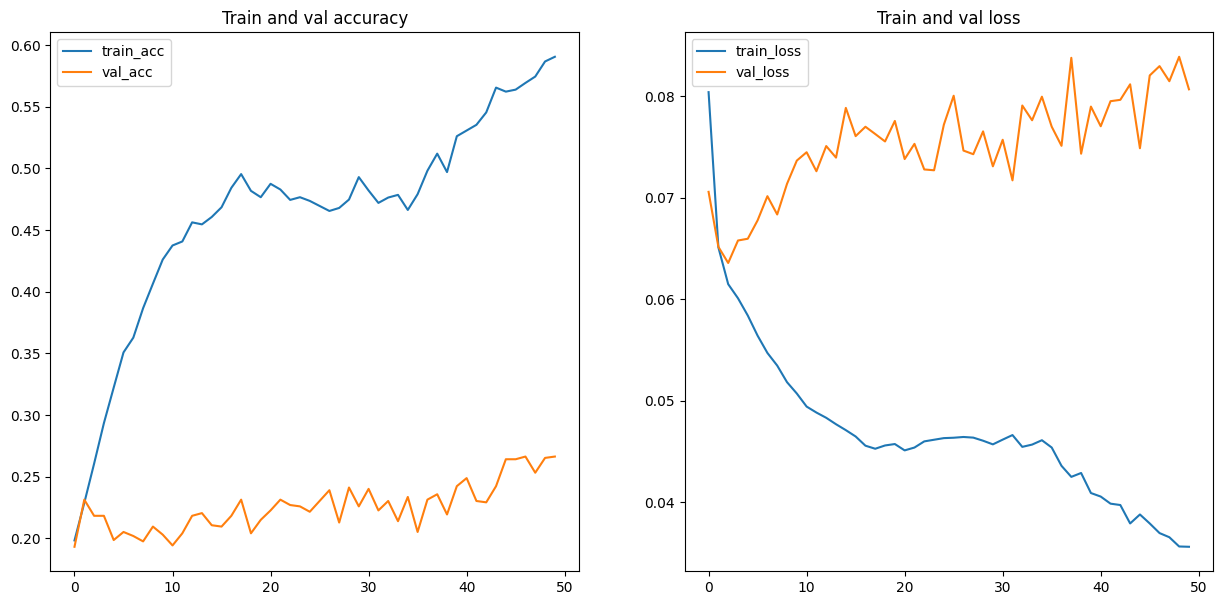

In [ ]:
resnet_model = ResNet50(num_classes=8)
resnet_trained_model, _, _ = train_model(resnet_model)

Train acc is still low. graident vanishing from 15 - 35 <br/>
=> Increase learning rate and he init

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06868585335171741
Epoch 1 train accuracy: 0.21032608695652175
Epoch 1 val loss: 0.06627626111934279
Epoch 1 val accuracy: 0.18449781659388648 

Start training epoch 2
Epoch 2 train loss: 0.06665543913841247
Epoch 2 train accuracy: 0.26603260869565215
Epoch 2 val loss: 0.06755361559609659
Epoch 2 val accuracy: 0.1703056768558952 

Start training epoch 3
Epoch 3 train loss: 0.06035031870655391
Epoch 3 train accuracy: 0.3244565217391304
Epoch 3 val loss: 0.07567374401738029
Epoch 3 val accuracy: 0.14847161572052403 

Start training epoch 4
Epoch 4 train loss: 0.05865319209254306
Epoch 4 train accuracy: 0.3557065217391304
Epoch 4 val loss: 0.07904136701442269
Epoch 4 val accuracy: 0.21179039301310043 

Start training epoch 5
Epoch 5 train loss: 0.05665029316492703
Epoch 5 train accuracy: 0.3845108695652174
Epoch 5 val loss: 0.07676846921183657
Epoch 5 val accuracy: 0.14847161572052403 

Start training epoch 6
Epoch 6 train loss: 

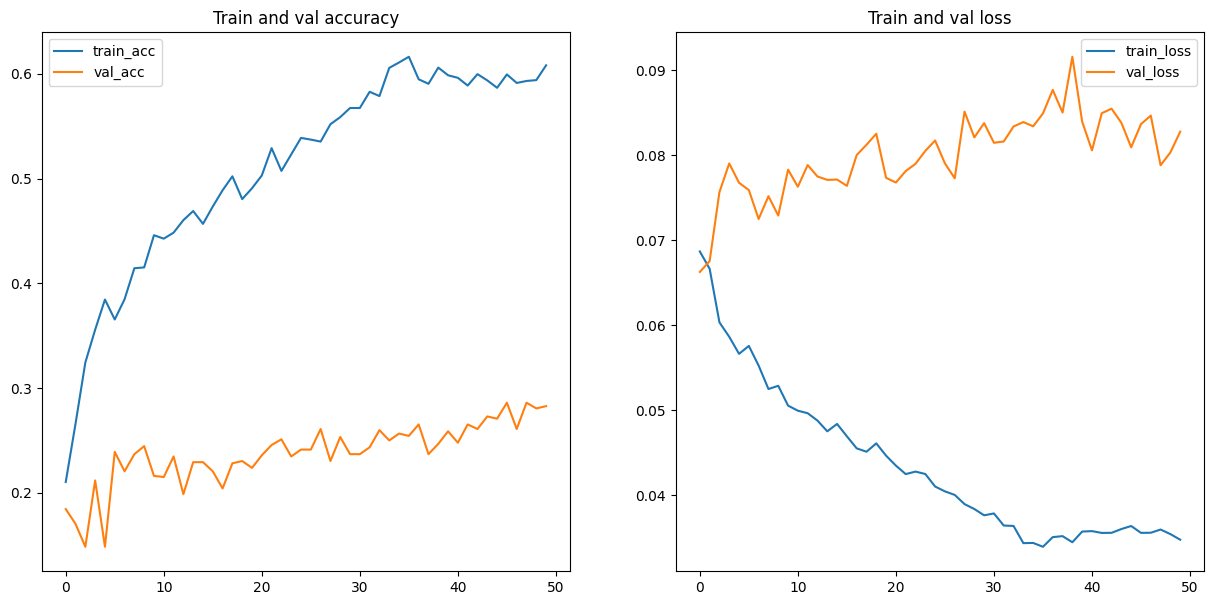

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet50(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE * 5,
                                         train_dataloader=train_easy_classification_dataloader)


Because we have increase the learning rate, the model tends to have vanishing exploding from epoch 30. We decide to decrease the epoch by the half, and increase the complex of model. We use resnet152 with learning rate = 2 * LEARNING_RATE

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06693442654998406
Epoch 1 train accuracy: 0.2141304347826087
Epoch 1 val loss: 0.06553313487481863
Epoch 1 val accuracy: 0.19323144104803494 

Start training epoch 2
Epoch 2 train loss: 0.06480237352459327
Epoch 2 train accuracy: 0.24619565217391304
Epoch 2 val loss: 0.0647456679802274
Epoch 2 val accuracy: 0.2096069868995633 

Start training epoch 3
Epoch 3 train loss: 0.06451027211935624
Epoch 3 train accuracy: 0.2673913043478261
Epoch 3 val loss: 0.06799215143424454
Epoch 3 val accuracy: 0.18995633187772926 

Start training epoch 4
Epoch 4 train loss: 0.06367240635597188
Epoch 4 train accuracy: 0.2817934782608696
Epoch 4 val loss: 0.06728788611670249
Epoch 4 val accuracy: 0.20087336244541484 

Start training epoch 5
Epoch 5 train loss: 0.06146146859163824
Epoch 5 train accuracy: 0.3157608695652174
Epoch 5 val loss: 0.06822169829143708
Epoch 5 val accuracy: 0.18777292576419213 

Start training epoch 6
Epoch 6 train loss: 0.

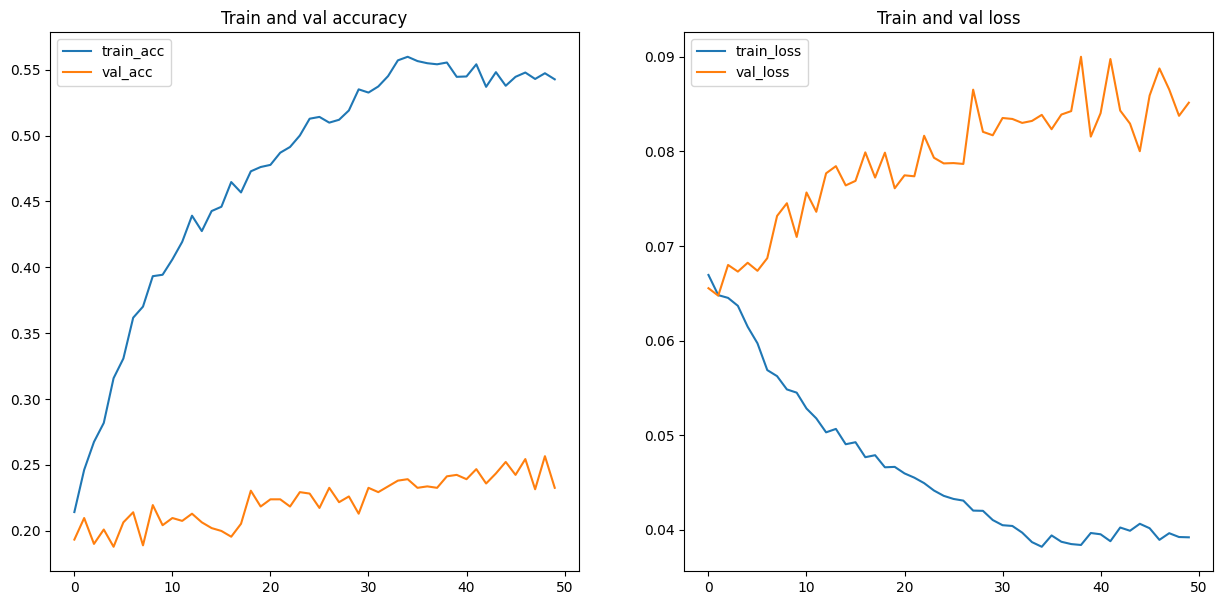

In [ ]:
resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE * 2)


keep this model, decrease learning rate to default learning rate because the model has gradient explosion from epoch 30 to 50

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_easy_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0628021695367668
Epoch 1 train accuracy: 0.2361413043478261
Epoch 1 val loss: 0.06428383687698164
Epoch 1 val accuracy: 0.2052401746724891 

Start training epoch 2
Epoch 2 train loss: 0.059934991760098415
Epoch 2 train accuracy: 0.2782608695652174
Epoch 2 val loss: 0.06639850152632035
Epoch 2 val accuracy: 0.21615720524017468 

Start training epoch 3
Epoch 3 train loss: 0.05633329159539679
Epoch 3 train accuracy: 0.3298913043478261
Epoch 3 val loss: 0.06784056563044219
Epoch 3 val accuracy: 0.19868995633187772 

Start training epoch 4
Epoch 4 train loss: 0.053595202902088995
Epoch 4 train accuracy: 0.3839673913043478
Epoch 4 val loss: 0.07167457857506765
Epoch 4 val accuracy: 0.2052401746724891 

Start training epoch 5
Epoch 5 train loss: 0.050572002938260203
Epoch 5 train accuracy: 0.4146739130434783
Epoch 5 val loss: 0.0768229473365967
Epoch 5 val accuracy: 0.1943231441048035 

Start training epoch 6
Epoch 6 train loss: 0.0

I think the model is overfitting, and now I will add a more complex data augmentation, and add dropout for avoid overfitting

In [ ]:
dropout_rate = 0.4

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x = self.dropout(x)
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout2d(dropout_rate)


    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      
      x = self.dropout(x)
      x = self.relu(x)

      return x


        
        
class ResNet(nn.Module):
    
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.11964087019795956
Epoch 1 train accuracy: 0.14945652173913043
Epoch 1 val loss: 0.12475124977561584
Epoch 1 val accuracy: 0.15938864628820962 

Start training epoch 2
Epoch 2 train loss: 0.11694414197750713
Epoch 2 train accuracy: 0.1513586956521739
Epoch 2 val loss: 0.12112178917014442
Epoch 2 val accuracy: 0.15283842794759825 

Start training epoch 3
Epoch 3 train loss: 0.11532568180042764
Epoch 3 train accuracy: 0.16277173913043477
Epoch 3 val loss: 0.11149902440054447
Epoch 3 val accuracy: 0.16593886462882096 

Start training epoch 4
Epoch 4 train loss: 0.10773398856753888
Epoch 4 train accuracy: 0.16277173913043477
Epoch 4 val loss: 0.10610150301820846
Epoch 4 val accuracy: 0.14737991266375547 

Start training epoch 5
Epoch 5 train loss: 0.10568700478128765
Epoch 5 train accuracy: 0.17146739130434782
Epoch 5 val loss: 0.10247485137922795
Epoch 5 val accuracy: 0.16812227074235808 

Start training epoch 6
Epoch 6 train los

We observe that the model has difficulty in convergence => we increase the learning rate and decrease dropout rate

In [ ]:
dropout_rate = 0.2

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x = self.dropout(x)
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout2d(dropout_rate)


    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      
      x = self.dropout(x)
      x = self.relu(x)

      return x


        
        
class ResNet(nn.Module):
    
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=2 * LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.09399612584839696
Epoch 1 train accuracy: 0.1608695652173913
Epoch 1 val loss: 0.0890188930336565
Epoch 1 val accuracy: 0.1965065502183406 

Start training epoch 2
Epoch 2 train loss: 0.08901701132240503
Epoch 2 train accuracy: 0.17282608695652174
Epoch 2 val loss: 0.08338980175001652
Epoch 2 val accuracy: 0.1615720524017467 

Start training epoch 3
Epoch 3 train loss: 0.08195935118457545
Epoch 3 train accuracy: 0.18206521739130435
Epoch 3 val loss: 0.0791134639077832
Epoch 3 val accuracy: 0.20087336244541484 

Start training epoch 4
Epoch 4 train loss: 0.07840061022535615
Epoch 4 train accuracy: 0.19456521739130433
Epoch 4 val loss: 0.07727783762211363
Epoch 4 val accuracy: 0.18777292576419213 

Start training epoch 5
Epoch 5 train loss: 0.0743304459621077
Epoch 5 train accuracy: 0.1923913043478261
Epoch 5 val loss: 0.07867184762871422
Epoch 5 val accuracy: 0.1943231441048035 

Start training epoch 6
Epoch 6 train loss: 0.07

Try with another SOTA model in 

### EfficientNet

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _RoundRepeats(r):
    return int(math.ceil(r))

def _DropPath(x, drop_prob, training):
    if drop_prob > 0 and training:
        keep_prob = 1 - drop_prob
        if x.is_cuda:
            mask = autograd.Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        else:
            mask = autograd.Variable(torch.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        x.div_(keep_prob)
        x.mul_(mask)

    return x

def _BatchNorm(channels, eps=1e-3, momentum=0.01):
    return nn.BatchNorm2d(channels, eps=eps, momentum=momentum)

def _Conv3x3Bn(in_channels, out_channels, stride, dropout_rate=0.0):
    layers = [
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        _BatchNorm(out_channels),
        Swish(),
    ]

    if dropout_rate > 0:
        layers.append(nn.Dropout2d(dropout_rate))
    

    return nn.Sequential(*layers)

def _Conv1x1Bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = Swish()
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_path_rate, dropout_rate=0.0):
        super(MBConvBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, 1, 0, bias=False),
                _BatchNorm(expand_channels),
                Swish()
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            nn.Conv2d(
                expand_channels,
                expand_channels,
                kernel_size,
                stride,
                kernel_size//2,
                groups=expand_channels,
                bias=False
            ),
            _BatchNorm(expand_channels),
            Swish()
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            nn.Conv2d(expand_channels, out_channels, 1, 1, 0, bias=False),
            _BatchNorm(out_channels)
        )
        conv.append(pw_projection)

        if dropout_rate > 0:
            conv.append(nn.Dropout2d(dropout_rate))

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + _DropPath(self.conv(x), self.drop_path_rate, self.training)
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    config = [
        #(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats)
        [32,  16,  3, 1, 1, 0.25, 1],
        [16,  24,  3, 2, 6, 0.25, 2],
        [24,  40,  5, 2, 6, 0.25, 2],
        [40,  80,  3, 2, 6, 0.25, 3],
        [80,  112, 5, 1, 6, 0.25, 3],
        [112, 192, 5, 2, 6, 0.25, 4],
        [192, 320, 3, 1, 6, 0.25, 1]
    ]

    def __init__(self, param, num_classes=1000, stem_channels=32, feature_size=1280, drop_connect_rate=0.2, dropout_rate=0.0):
        super(EfficientNet, self).__init__()
        
        self.dropout_rate = dropout_rate

        # scaling width
        width_coefficient = param[0]
        if width_coefficient != 1.0:
            stem_channels = _RoundChannels(stem_channels*width_coefficient)
            for conf in self.config:
                conf[0] = _RoundChannels(conf[0]*width_coefficient)
                conf[1] = _RoundChannels(conf[1]*width_coefficient)

        # scaling depth
        depth_coefficient = param[1]
        if depth_coefficient != 1.0:
            for conf in self.config:
                conf[6] = _RoundRepeats(conf[6]*depth_coefficient)

        # scaling resolution
        input_size = param[2]

        # stem convolution
        self.stem_conv = _Conv3x3Bn(3, stem_channels, 2, dropout_rate=dropout_rate)

        # total #blocks
        total_blocks = 0
        for conf in self.config:
            total_blocks += conf[6]

        # mobile inverted bottleneck
        blocks = []
        for in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats in self.config:
            # drop connect rate based on block index
            drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
            blocks.append(MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_rate))
            for _ in range(repeats-1):
                drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
                blocks.append(MBConvBlock(out_channels, out_channels, kernel_size, 1, expand_ratio, se_ratio, drop_rate, dropout_rate=dropout_rate))
        self.blocks = nn.Sequential(*blocks)

        # last several layers
        self.head_conv = _Conv1x1Bn(self.config[-1][1], feature_size)
        #self.avgpool = nn.AvgPool2d(input_size//32, stride=1)
        self.dropout = nn.Dropout(param[3])
        self.classifier = nn.Linear(feature_size, num_classes)

        self._initialize_weights()

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate) 

    def forward(self, x):
        x = self.stem_conv(x)
        if self.dropout_rate > 0:
            x = self.dropout1(x)

        x = self.blocks(x)
        if self.dropout_rate > 0:
            x = self.dropout2(x)

        x = self.head_conv(x)
        x = torch.mean(x, (2, 3))
        x = self.dropout(x)

        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
net_param = {
        # 'efficientnet type': (width_coef, depth_coef, resolution, dropout_rate)
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5)
}



Device: cuda:0

Start training epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b1c230e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1 train loss: 0.066096073453841
Epoch 1 train accuracy: 0.16793478260869565
Epoch 1 val loss: 0.06777919314834228
Epoch 1 val accuracy: 0.16593886462882096 

Start training epoch 2
Epoch 2 train loss: 0.06463233248695083
Epoch 2 train accuracy: 0.19184782608695652
Epoch 2 val loss: 0.06655172671813632
Epoch 2 val accuracy: 0.18013100436681223 

Start training epoch 3
Epoch 3 train loss: 0.06391376739610796
Epoch 3 train accuracy: 0.2154891304347826
Epoch 3 val loss: 0.06568048549531329
Epoch 3 val accuracy: 0.19104803493449782 

Start training epoch 4
Epoch 4 train loss: 0.06263585615417232
Epoch 4 train accuracy: 0.2266304347826087
Epoch 4 val loss: 0.06578604506092821
Epoch 4 val accuracy: 0.19868995633187772 

Start training epoch 5
Epoch 5 train loss: 0.06130439551628154
Epoch 5 train accuracy: 0.26711956521739133
Epoch 5 val loss: 0.06709470473002138
Epoch 5 val accuracy: 0.21069868995633187 

Start training epoch 6
Epoch 6 train loss: 0.05991271549592848
Epoch 6 train accur

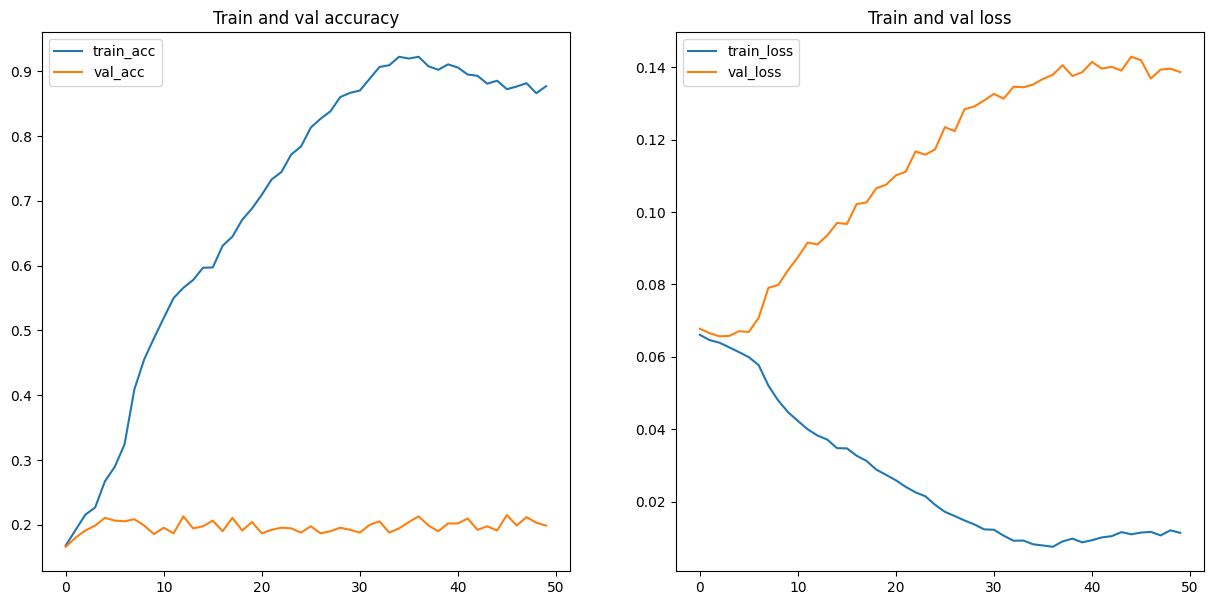

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_model.apply(init_weights)
effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8, dropout_rate=0.3)
effnet_model.apply(init_weights)
effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06747088231470273
Epoch 1 train accuracy: 0.14864130434782608
Epoch 1 val loss: 0.067166363438144
Epoch 1 val accuracy: 0.1812227074235808 

Start training epoch 2
Epoch 2 train loss: 0.06589684246674828
Epoch 2 train accuracy: 0.18858695652173912
Epoch 2 val loss: 0.0670157314387992
Epoch 2 val accuracy: 0.17139737991266377 

Start training epoch 3
Epoch 3 train loss: 0.06474755970032318
Epoch 3 train accuracy: 0.2127717391304348
Epoch 3 val loss: 0.06560670991131312
Epoch 3 val accuracy: 0.185589519650655 

Start training epoch 4
Epoch 4 train loss: 0.06487966957299605
Epoch 4 train accuracy: 0.2013586956521739
Epoch 4 val loss: 0.06540843896470215
Epoch 4 val accuracy: 0.2259825327510917 

Start training epoch 5
Epoch 5 train loss: 0.06436819408250892
Epoch 5 train accuracy: 0.20625
Epoch 5 val loss: 0.06605563895150564
Epoch 5 val accuracy: 0.20851528384279475 

Start training epoch 6
Epoch 6 train loss: 0.064185752039370

Random erasing: https://github.com/zhunzhong07/Random-Erasing/blob/master/transforms.py <br/>
Weather transforms: https://albumentations.ai/docs/examples/example_weather_transforms/


We see that dropout model is not effective here. So we add more image using image augmentation technique. Our target is 2000 images per classes:

In [ ]:
MORE_TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/more_train"

# TRAIN_DIR = "./data/train"
# MORE_TRAIN_DIR = "./data/more_train"

# classes_ratio_dict = {
#     "Hydrangeas": 3,
#     "Babi": 1,
#     "Calimerio": 4,
#     "Chrysanthemum": 2,
#     "Pingpong": 4,
#     "Lisianthus": 1,
#     "Rosy": 10,
#     "Tana": 2 
# }

# create_images_transform = A.Compose([
#     A.OneOf([
#         A.ColorJitter(0.75),
#         A.HueSaturationValue(0.75)
#     ], p=0.5),
#     A.Equalize(),
#     A.GaussNoise(),
#     A.GaussianBlur((1, 3)),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RGBShift(5, 5, 5),
#     A.Sharpen(),
#     A.Affine(scale=1.2, shear=(-5, 5), p=0.75),
# ])



# def create_dir(dir_path):
#     if os.path.exists(dir_path):
#         shutil.rmtree(dir_path)
#     os.mkdir(dir_path)

# def create_images_from_image(image_path, 
#                              to_class_dir_path,
#                              ratio, 
#                              transform):
#         image = cv2.imread(image_path)
#         image_name = f"{to_class_dir_path}/{str(uuid4())}.jpg"

#         for _ in range(ratio + 1):
#             new_image = transform(image=image)["image"]
#             image_name = f"{to_class_dir_path}/{str(uuid4())}.jpg"
#             cv2.imwrite(image_name, new_image)

# def create_images(from_dir_path, to_dir_path, transform, ratio_dict):
#     create_dir(to_dir_path)
    
#     for class_name, ratio in ratio_dict.items():
#         create_dir(f"{to_dir_path}/{class_name}")

#         for image_name in os.listdir(f"{from_dir_path}/{class_name}"):
#             image_path = f"{from_dir_path}/{class_name}/{image_name}"
#             to_class_dir_path = f"{to_dir_path}/{class_name}"
#             create_images_from_image(image_path, 
#                                      to_class_dir_path,
#                                      ratio, 
#                                      transform)


In [ ]:
# create_images(TRAIN_DIR, MORE_TRAIN_DIR, 
#               create_images_transform, classes_ratio_dict)

name  num_images
0       Pingpong        1440
1      Calimerio        1410
2  Chrysanthemum        1668
3           Tana        1494
4     Hydrangeas        1655
5     Lisianthus        1550
6           Babi        1488
7           Rosy        1496

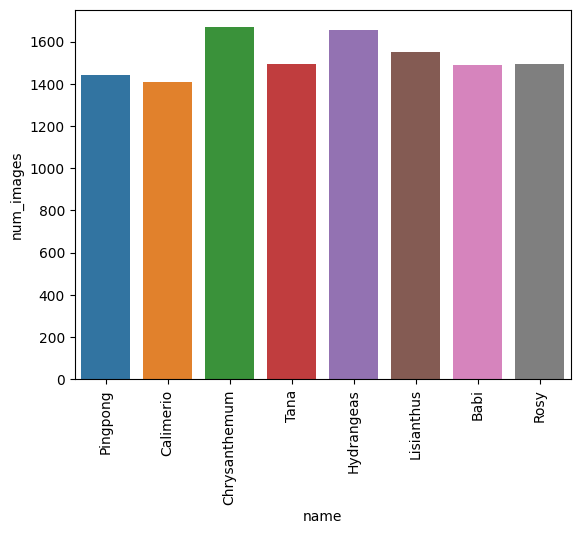

In [ ]:
more_train_images_by_class = get_images_by_class(MORE_TRAIN_DIR)
plot_num_per_class(more_train_images_by_class)

In [ ]:
more_train_images_df = get_images_df(MORE_TRAIN_DIR)
print(len(more_train_images_df))
more_train_images_df.head()

12201


image_id     class           dir_path
0  4fe74f8d-6cad-4369-b50c-dd6cd7ae390b  Pingpong  ./data/more_train
1  6b5af305-863a-475a-b4f8-81b76307765b  Pingpong  ./data/more_train
2  149663de-134f-44f6-8eaf-e73b5558bdf0  Pingpong  ./data/more_train
3  f215260a-72be-4728-a317-9e10f7d71b6b  Pingpong  ./data/more_train
4  0badeac7-8f59-4fcc-afa7-f415a6cf498c  Pingpong  ./data/more_train

In [ ]:
# Define a new dataset with new transform for augmentation 
more_train_easy_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.05, val_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.05,0.05), contrast_limit=(-0.05, 0.05), p=0.5),
        ToTensorV2(),
    ]
)

more_train_easy_classification_dataset = ClassificationDataset(TRAIN_DIR, more_train_easy_transforms)

more_train_easy_classification_dataloader = DataLoader(
    more_train_easy_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
print(len(more_train_classification_dataloader))

381


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

more_train_classification_dataloader = DataLoader(
    more_train_classification_dataset, batch_size=16, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

effnet_model = EfficientNet(net_param['efficientnet-b4'], num_classes=8)
effnet_model.apply(init_weights)

effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.13464490052439723
Epoch 1 train accuracy: 0.14189632545931757
Epoch 1 val loss: 0.06930003624295564
Epoch 1 val accuracy: 0.12117903930131005 

Start training epoch 2
Epoch 2 train loss: 0.13023512257052844
Epoch 2 train accuracy: 0.18823818897637795
Epoch 2 val loss: 0.07164087136760029
Epoch 2 val accuracy: 0.1408296943231441 

Start training epoch 3
Epoch 3 train loss: 0.12084705225165122
Epoch 3 train accuracy: 0.2585301837270341
Epoch 3 val loss: 0.0747317174636641
Epoch 3 val accuracy: 0.15065502183406113 

Start training epoch 4
Epoch 4 train loss: 0.11095693330048263
Epoch 4 train accuracy: 0.32841207349081364
Epoch 4 val loss: 0.07840321457021622
Epoch 4 val accuracy: 0.1648471615720524 

Start training epoch 5
Epoch 5 train loss: 0.10158536673139712
Epoch 5 train accuracy: 0.3805774278215223
Epoch 5 val loss: 0.08188222472324122
Epoch 5 val accuracy: 0.18231441048034935 

Start training epoch 6
Epoch 6 train loss: 0

In [ ]:
resnet_model = ResNet152(num_classes=8)
resnet_trained_model, _, _ = train_model(resnet_model)

Device: cuda:0



KeyboardInterrupt: ignored

### [DenseNet](https://github.com/andreasveit/densenet-pytorch/blob/master/densenet.py)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.fc = nn.LazyLinear(num_classes)
        
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.trans1(self.block1(out))

        out = self.trans2(self.block2(out))
        
        out = self.block3(out)
        
        out = self.relu(self.bn1(out))

        out = F.avg_pool2d(out, 8)
        
        out = out.reshape(out.shape[0], -1)
        
        return self.fc(out)

In [ ]:
train_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

val_classification_dataloader = DataLoader(
    val_classification_dataset, batch_size=16,
    pin_memory=True, num_workers=4
)

densenet_model = DenseNet3(100, num_classes=8)
densenet_trained_model, _, _ = train_model(densenet_model, 
                                           train_dataloader=train_classification_dataloader, 
                                           val_dataloader=val_classification_dataloader)

NameError: ignored

### Xception

In [ ]:
model_urls = {
    'xception':'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(**kwargs):
    model = Xception(**kwargs)
    return model

In [ ]:
xception_model = xception(num_classes=8)
xception_trained_model, _, _ = train_model(xception_model)

### MobileNetV2

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenet_v2(n_class=1000, input_size=224):
    model = MobileNetV2(width_mult=1, 
                        n_class=n_class, 
                        input_size=input_size)
    return model

In [ ]:
mobilenet_v2_model = mobilenet_v2(n_class=8, input_size=256)
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model)

### Darknet-53

In [ ]:
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())


# Residual block
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out


class Darknet53(nn.Module):
    def __init__(self, block, num_classes):
        super(Darknet53, self).__init__()

        self.num_classes = num_classes

        self.conv1 = conv_batch(3, 32)
        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.global_avg_pool(out)
        out = out.view(-1, 1024)
        out = self.fc(out)

        return out

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)


def darknet53(num_classes):
    return Darknet53(DarkResidualBlock, num_classes)


In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_trained_model, _, _ = train_model(darknet53_model)

### EfficientNet

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _RoundRepeats(r):
    return int(math.ceil(r))

def _DropPath(x, drop_prob, training):
    if drop_prob > 0 and training:
        keep_prob = 1 - drop_prob
        if x.is_cuda:
            mask = autograd.Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        else:
            mask = autograd.Variable(torch.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        x.div_(keep_prob)
        x.mul_(mask)

    return x

def _BatchNorm(channels, eps=1e-3, momentum=0.01):
    return nn.BatchNorm2d(channels, eps=eps, momentum=momentum)

def _Conv3x3Bn(in_channels, out_channels, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

def _Conv1x1Bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = Swish()
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_path_rate):
        super(MBConvBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, 1, 0, bias=False),
                _BatchNorm(expand_channels),
                Swish()
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            nn.Conv2d(
                expand_channels,
                expand_channels,
                kernel_size,
                stride,
                kernel_size//2,
                groups=expand_channels,
                bias=False
            ),
            _BatchNorm(expand_channels),
            Swish()
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            nn.Conv2d(expand_channels, out_channels, 1, 1, 0, bias=False),
            _BatchNorm(out_channels)
        )
        conv.append(pw_projection)

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + _DropPath(self.conv(x), self.drop_path_rate, self.training)
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    config = [
        #(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats)
        [32,  16,  3, 1, 1, 0.25, 1],
        [16,  24,  3, 2, 6, 0.25, 2],
        [24,  40,  5, 2, 6, 0.25, 2],
        [40,  80,  3, 2, 6, 0.25, 3],
        [80,  112, 5, 1, 6, 0.25, 3],
        [112, 192, 5, 2, 6, 0.25, 4],
        [192, 320, 3, 1, 6, 0.25, 1]
    ]

    def __init__(self, param, num_classes=1000, stem_channels=32, feature_size=1280, drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()

        # scaling width
        width_coefficient = param[0]
        if width_coefficient != 1.0:
            stem_channels = _RoundChannels(stem_channels*width_coefficient)
            for conf in self.config:
                conf[0] = _RoundChannels(conf[0]*width_coefficient)
                conf[1] = _RoundChannels(conf[1]*width_coefficient)

        # scaling depth
        depth_coefficient = param[1]
        if depth_coefficient != 1.0:
            for conf in self.config:
                conf[6] = _RoundRepeats(conf[6]*depth_coefficient)

        # scaling resolution
        input_size = param[2]

        # stem convolution
        self.stem_conv = _Conv3x3Bn(3, stem_channels, 2)

        # total #blocks
        total_blocks = 0
        for conf in self.config:
            total_blocks += conf[6]

        # mobile inverted bottleneck
        blocks = []
        for in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats in self.config:
            # drop connect rate based on block index
            drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
            blocks.append(MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_rate))
            for _ in range(repeats-1):
                drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
                blocks.append(MBConvBlock(out_channels, out_channels, kernel_size, 1, expand_ratio, se_ratio, drop_rate))
        self.blocks = nn.Sequential(*blocks)

        # last several layers
        self.head_conv = _Conv1x1Bn(self.config[-1][1], feature_size)
        #self.avgpool = nn.AvgPool2d(input_size//32, stride=1)
        self.dropout = nn.Dropout(param[3])
        self.classifier = nn.Linear(feature_size, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.blocks(x)
        x = self.head_conv(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.mean(x, (2, 3))
        x = self.dropout(x)
        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
net_param = {
        # 'efficientnet type': (width_coef, depth_coef, resolution, dropout_rate)
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5)
}

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_trained_model, _, _ = train_model(effnet_model)

Device: cuda:0

Start training epoch 1


KeyboardInterrupt: ignored

In [ ]:
effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_trained_model, _, _ = train_model(effnet_model)

### CSPDarkNet53

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


ACTIVATIONS = {
    'mish': Mish(),
    'leaky': nn.LeakyReLU(negative_slope=0.1),
    'linear': nn.Identity()
}


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='mish'):
        super(Conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            ACTIVATIONS[activation]
        )

    def forward(self, x):
        return self.conv(x)


class CSPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, residual_activation='linear'):
        super(CSPBlock, self).__init__()

        if hidden_channels is None:
            hidden_channels = out_channels

        self.block = nn.Sequential(
            Conv(in_channels, hidden_channels, 1),
            Conv(hidden_channels, out_channels, 3)
        )

        self.activation = ACTIVATIONS[residual_activation]

    def forward(self, x):
        return self.activation(x+self.block(x))


class CSPFirstStage(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPFirstStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels, 1)
        self.split_conv1 = Conv(out_channels, out_channels, 1)

        self.blocks_conv = nn.Sequential(
            CSPBlock(out_channels, out_channels, in_channels),
            Conv(out_channels, out_channels, 1)
        )

        self.concat_conv = Conv(out_channels*2, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks):
        super(CSPStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels//2, 1)
        self.split_conv1 = Conv(out_channels, out_channels//2, 1)

        self.blocks_conv = nn.Sequential(
            *[CSPBlock(out_channels//2, out_channels//2)
                       for _ in range(num_blocks)],
            Conv(out_channels//2, out_channels//2, 1)
        )

        self.concat_conv = Conv(out_channels, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPDarknet53(nn.Module):
    def __init__(self, 
               stem_channels=32, 
               feature_channels=[64, 128, 256, 512, 1024], 
               num_features=3,
               num_classes=1000):
        super(CSPDarknet53, self).__init__()
        self.stem_conv = Conv(3, stem_channels, 3)
        self.stages = nn.ModuleList([
      CSPFirstStage(stem_channels, feature_channels[0]),
      CSPStage(feature_channels[0], feature_channels[1], 2),
      CSPStage(feature_channels[1], feature_channels[2], 8),
      CSPStage(feature_channels[2], feature_channels[3], 8),
      CSPStage(feature_channels[3], feature_channels[4], 4)
    ])

        self.feature_channels = feature_channels
        self.num_classes = num_classes

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(1024, self.num_classes, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                    
    def extract_features(self, x):
        features = []

        x = self.stem_conv(x)

        x = self.stages[0](x)#//2
        x = self.stages[1](x)#//4
        x8 = self.stages[2](x)#//8
        features.append(x8)

        x16 = self.stages[3](x8)#//16
        features.append(x16)

        x32 = self.stages[4](x16)#//32
        features.append(x32)

        return features
    
    def forward(self, x):
        features = self.extract_features(x)
        x = self.gap(features[-1])
        x = self.fc(x)
        x = x.flatten(start_dim=1)
        return x

In [ ]:
cspdarknet53_model = CSPDarknet53(num_classes=8)
cspdarknet53_trained_model, _, _ = train_model(cspdarknet53_model)

### EfficientNetV2

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                nn.SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=1000, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()


def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model)

Device: cuda:0

Start training epoch 1


KeyboardInterrupt: ignored

## Task 2

In [47]:
class SearchEngine():
    def __init__(self, 
                 name, 
                 extractor, 
                 embedding_dim, 
                 train_images_df=more_train_images_df,
                 transforms=val_transforms,
                 train_dataloader=more_train_dataloader,
                 val_dataloader=val_dataloader,
                 num_images=SEARCH_NUM_IMAGES):
        self.name, self.extractor, self.embedding_dim = name, extractor, embedding_dim
        self.train_images_df = train_images_df
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.transforms = transforms
        self.num_images = num_images
        self.embedding = None

        self.extractor.to(device)
        self.extractor.eval()

    def create_embedding(self):
        self.extractor.eval()
        embedding = torch.randn(self.embedding_dim)

        with torch.no_grad():
            for batch_idx, (train_img, target_img) in enumerate(self.train_dataloader):
                train_img = train_img.to(device)
                enc_output = self.extractor.extract(train_img).cpu()
                embedding = torch.cat((embedding, enc_output), 0)
                print(f"Finish batch {batch_idx}")

        return embedding


    def build(self):
        self.embedding = self.create_embedding()
        numpy_embedding = self.embedding.cpu().detach().numpy()
        flattened_numpy_embedding = numpy_embedding.reshape((numpy_embedding.shape[0], -1))
        np.save(f"{EMBEDDING_DIR}/{self.name}_embedding.npy", flattened_numpy_embedding)

    def load_embedding(self):
        self.embedding = np.load(f"{EMBEDDING_DIR}/{self.name}_embedding.npy")

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def get_similar_images(self, image_path, num_images=SEARCH_NUM_IMAGES):
        image = self.load_image(image_path)

        self.load_embedding()
        
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        
        with torch.no_grad():
            image = image.to(device)
            image = torch.unsqueeze(image, 0)
            image_embedding = self.extractor.extract(image)

        flattened_image_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
        flattened_numpy_image_embedding = flattened_image_embedding.cpu().detach().numpy()

        knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
        knn.fit(self.embedding)

        _, indices = knn.kneighbors(flattened_numpy_image_embedding)
        return indices

    def get_masked_index_list(self, index_list):
        masked_index_list = np.zeros(self.embdding_dim[0], dtype=int)
        masked_index_list[index_list] = 1
        return masked_index_list


    def plot_similar_images(self, image_path:str, num_images=SEARCH_NUM_IMAGES,
                            nrows=2, ncols=5):
        index_list = self.get_similar_images(image_path, num_images).squeeze(0)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(self.load_image(image_path))
        ax.axis("off")

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 8))

        for i, idx in enumerate(index_list):
            row = i // ncols
            col = i % ncols

            image = self.load_image(get_image_path(self.train_images_df, idx))
            
            axes[row][col].imshow(image)
            axes[row][col].axis("off")

            print(self.train_images_df.iloc[idx]["class"])

        pass




    def evaluate(self):
        embedding = self.load_embedding() 
        for idx, (x, y) in self.val_dataloader:
            pass
            

### Darknet53

In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_model.load_state_dict(
    torch.load(f"{MODEL_DIR}/darknet53/darknet53_strong_train_740_val_780.pth"
))
darknet53_model.eval()

it = iter(more_train_dataloader)
x, y = next(it)
DARKNET53_EMBEDDING_DIM = darknet53_model.extract(x).shape
print(DARKNET53_EMBEDDING_DIM)

torch.Size([32, 1024, 1, 1])


In [ ]:
darknet53_search_engine = SearchEngine(
    name='darknet53', 
    extractor=darknet53_model, 
    embedding_dim=DARKNET53_EMBEDDING_DIM
)

In [ ]:
# darknet53_search_engine.build()

Hydrangeas
Lisianthus
Tana
Hydrangeas
Rosy
Tana
Calimerio
Pingpong
Chrysanthemum
Babi


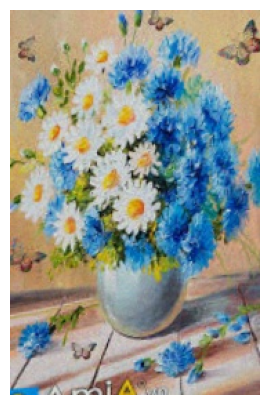

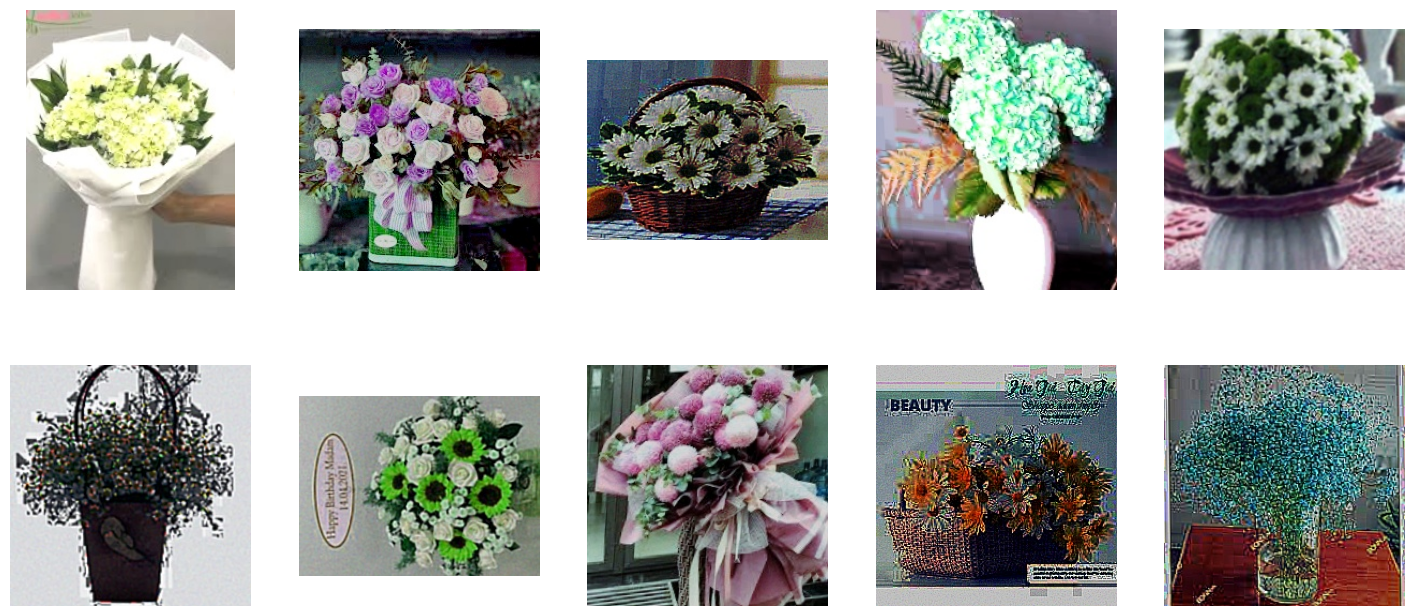

In [ ]:
darknet53_search_engine.plot_similar_images(get_image_path(more_train_images_df, 15))

### AutoEncoder Resnet18

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        self.encoder, self.decoder = encoder, decoder 

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super().__init__()

        self.stride, self.i_downsample = stride, i_downsample

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.gelu = nn.GELU()

    def forward(self, x):
        idenity = x.clone()
        out = self.gelu(self.bn1(self.conv1(x)))
        out = self.gelu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        out += identity
        return self.gelu(out)


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super().__init__()

        self.i_downsample, self.stride = i_downsample, stride

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.gelu = nn.GELU()

    def forward(self, x):
        identiy = x.clone()
        out = self.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        out += identity
        return out

class ResNetEncoder(nn.Module):
    expansion = 4

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_planes != planes * ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes * ResBlock.expansion

        for _ in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.gelu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

    def __init__(self, ResBlock, layer_list, num_classes=1000, num_channels=3, encode_dim=ENCODE_DIM):
        super().__init__()
        
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.gelu = nn.GELU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, encode_dim)
        




def ResNet18(num_classes=1000):
    return ResNet(Bottleneck, [2, 2, 2, 2], num_classes, num_channels=3)

class ResNetDecoder(nn.Module):
    expansion = 4
    def __init__(self, encode_dim=ENCODE_DIM):
        super().__init__()

        self.fc = nn.Linear(encode_dim, 512 * self.expansion)
        self.unflatten = nn.Unflatten(dim=1, (512 * self.expansion, 1, 1))
        self.gelu = nn.GELU()
        
        self.layer1 = nn.ConvTranspose2d(512 * self.expansion, 256 * self.expansion, stride=2)
        self.layer2 = nn.ConvTranspose2d(256 * self.expansion, 128 * self.expansion, stride=2)
        self.layer3 = nn.ConvTranspose2d(128 * self.expansion, 64 * self.expansion, stride=2)
        
        
        

class Decoder(nn.Module):
	def __init__(self):
		super(Decoder,self).__init__()
		self.dfc3 = nn.Linear(zsize, 4096)
		self.bn3 = nn.BatchNorm2d(4096)
		self.dfc2 = nn.Linear(4096, 4096)
		self.bn2 = nn.BatchNorm2d(4096)
		self.dfc1 = nn.Linear(4096,256 * 6 * 6)
		self.bn1 = nn.BatchNorm2d(256*6*6)
		self.upsample1=nn.Upsample(scale_factor=2)
		self.dconv5 = nn.ConvTranspose2d(256, 256, 3, padding = 0)
		self.dconv4 = nn.ConvTranspose2d(256, 384, 3, padding = 1)
		self.dconv3 = nn.ConvTranspose2d(384, 192, 3, padding = 1)
		self.dconv2 = nn.ConvTranspose2d(192, 64, 5, padding = 2)
		self.dconv1 = nn.ConvTranspose2d(64, 3, 12, stride = 4, padding = 4)
        

In [43]:
"""
---
title: U-Net
summary: >
    PyTorch implementation and tutorial of U-Net model.
---

# U-Net

This is an implementation of the U-Net model from the paper,
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://papers.labml.ai/paper/1505.04597).

U-Net consists of a contracting path and an expansive path.
The contracting path is a series of convolutional layers and pooling layers,
where the resolution of the feature map gets progressively reduced.
Expansive path is a series of up-sampling layers and convolutional layers
where the resolution of the feature map gets progressively increased.

At every step in the expansive path the corresponding feature map from the contracting path
concatenated with the current feature map.

![U-Net diagram from paper](unet.png)

Here is the [training code](experiment.html) for an experiment that trains a U-Net
on [Carvana dataset](carvana.html).
"""
import torch
import torchvision.transforms.functional
from torch import nn


class DoubleConvolution(nn.Module):
    """
    ### Two $3 \times 3$ Convolution Layers

    Each step in the contraction path and expansive path have two $3 \times 3$
    convolutional layers followed by ReLU activations.

    In the U-Net paper they used $0$ padding,
    but we use $1$ padding so that final feature map is not cropped.
    """

    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: is the number of input channels
        :param out_channels: is the number of output channels
        """
        super().__init__()

        # First $3 \times 3$ convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second $3 \times 3$ convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)


class DownSample(nn.Module):
    """
    ### Down-sample

    Each step in the contracting path down-samples the feature map with
    a $2 \times 2$ max pooling layer.
    """

    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)


class UpSample(nn.Module):
    """
    ### Up-sample

    Each step in the expansive path up-samples the feature map with
    a $2 \times 2$ up-convolution.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)


class CropAndConcat(nn.Module):
    """
    ### Crop and Concatenate the feature map

    At every step in the expansive path the corresponding feature map from the contracting path
    concatenated with the current feature map.
    """
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        """
        :param x: current feature map in the expansive path
        :param contracting_x: corresponding feature map from the contracting path
        """

        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        #
        return x


class UNet(nn.Module):
    """
    ## U-Net
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: number of channels in the input image
        :param out_channels: number of channels in the result feature map
        """
        super().__init__()

        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from $64$.
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                        [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                      [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        # Final $1 \times 1$ convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: input image
        """
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two $3 \times 3$ convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two $3 \times 3$ convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two $3 \times 3$ convolutional layers
            x = self.up_conv[i](x)

        # Final $1 \times 1$ convolution layer
        x = self.final_conv(x)

        #
        return x

In [65]:
def correlation_loss(output, target):
    x, y = output.clone(), target.clone()

    vx, vy = x - torch.mean(x), y - torch.mean(y) 
    conv = torch.mean(vx * vy)
    sigma_x = torch.sqrt(torch.mean(vx ** 2))
    sigma_y = torch.sqrt(torch.mean(vy ** 2))
    
    cost = -conv / (sigma_x * sigma_y)
    return cost


In [66]:
def train_unet_model(
    model,
    save_dir,
    name="unet",
    lr=LEARNING_RATE,
    optimizer='sgd',
    num_epochs=25,
    train_dataloader=more_train_encoder_dataloader,
    val_dataloader=val_encoder_dataloader
):
    torch.cuda.empty_cache()
    time.sleep(5)

    model.eval()
    model.to(device)

    best_loss = 1e9

    if optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = 1e9

    for epoch in range(num_epochs):
        print(f"Start traing epoch {epoch}")

        train_loss, total = 0, 0

        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = correlation_loss(y_hat, x)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total += x.shape[0]

        train_losses.append(train_loss / total)
        print(f"Epoch {epoch} train loss = {train_losses[-1]}")

        with torch.no_grad():
            val_loss, total = 0, 0
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)

                y_hat = model(x)
                loss = correlation_loss(y_hat, x)

                val_loss += loss
                total += x.shape[0]

            val_losses.append(val_loss / total)
            print(f"Epoch {epoch} val loss = {val_losses[-1]}\n")

            if val_losses[-1] < best_val_loss:
                model_name = f"{name}_train_{train_losses[-1]}_val_{val_losses[-1]}"
                print(f"Saving {model_name}.pth\n")
                torch.save(model.state_dict(), f"{save_dir}/{model_name}.pth")
                best_val_loss = val_losses[-1]


    fig, axes = plt.subplots()
    axes.plot(train_loss, label="train loss")
    axes.plot(val_loss, label="val loss")
    axes.legend()

    return model
        

In [63]:
torch.cuda.empty_cache()

In [67]:
unet_model = UNet(
    in_channels=3, 
    out_channels=3
)
unet_trained_model = train_unet_model(
    unet_model,
    save_dir=f"{MODEL_DIR}/unet",
    name="unet",
)

Start traing epoch 0
Epoch 0 train loss = -0.059034569874795
Epoch 0 val loss = -0.0617167130112648

Saving unet_train_-0.059034569874795_val_-0.0617167130112648.pth



RuntimeError: ignored